# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [15]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = tf.concat([h1, actions_logits], axis=1)
        h2 = mlp(inputs=h2, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h2, units=state_size)
        return next_states_

In [16]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = mlp(inputs=h1, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        actions_ = mlp(inputs=h2, units=action_size)
        return actions_

In [17]:
def model_loss(actions, actions_logits, states, next_states, targetQs, 
               state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [18]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [23]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [25]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [27]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_.reshape(-1)

In [28]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits_, axis=1)[0]
    #print(action)
    
    return action, action_logits_.reshape(-1)

In [29]:
# l = []
# l.append([0, 1])

In [30]:
# l[0][0]

In [31]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action, action_logits = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done), action_logits])
            
            # Explore (Env) or Exploit (Model)
            #total_step += 1
            #explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            explore_p = np.random.normal(0, 1)
            if np.abs(explore_p) < 1e-2:
                print('np.abs(explore_p) < 1e-2:', explore_p)
                next_state = env_(sess, state=state, action_logits=action_logits)
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                gloss, dloss = learn(sess, memory, batch_size)
                loss_batch.append([gloss, dloss])
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'gloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[0]),
                  'dloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[1]))
            
            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
        
        else: print('len(memory.buffer) >= batch_size:', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

len(memory.buffer) >= batch_size: 10 20
np.abs(explore_p) < 1e-2: 0.00808028404725816
Episode:1 meanR:45.0000 R:45.0 gloss:1.4633 dloss:0.9181
Episode:2 meanR:27.5000 R:10.0 gloss:0.6610 dloss:0.9379
Episode:3 meanR:21.0000 R:8.0 gloss:1.5751 dloss:0.8735
Episode:4 meanR:17.7500 R:8.0 gloss:1.4849 dloss:0.8504
Episode:5 meanR:15.8000 R:8.0 gloss:1.1330 dloss:0.8472
Episode:6 meanR:16.5000 R:20.0 gloss:1.0369 dloss:0.8824
Episode:7 meanR:15.4286 R:9.0 gloss:0.8595 dloss:0.9269
np.abs(explore_p) < 1e-2: -0.0033147615419553155
Episode:8 meanR:14.6250 R:9.0 gloss:1.1137 dloss:0.9578
np.abs(explore_p) < 1e-2: 0.009189396974722068
Episode:9 meanR:14.0000 R:9.0 gloss:0.9791 dloss:0.9687
Episode:10 meanR:13.6000 R:10.0 gloss:0.7169 dloss:0.9880
Episode:11 meanR:13.3636 R:11.0 gloss:0.5962 dloss:1.0134
Episode:12 meanR:13.0000 R:9.0 gloss:0.5304 dloss:1.0456
Episode:13 meanR:12.7692 R:10.0 gloss:0.4571 dloss:1.1066
Episode:14 meanR:12.4286 R:8.0 gloss:0.3306 dloss:1.1682
Episode:15 meanR:12.266

Episode:132 meanR:9.4300 R:11.0 gloss:0.0155 dloss:0.1272
Episode:133 meanR:9.4500 R:11.0 gloss:0.0139 dloss:0.1415
Episode:134 meanR:9.4600 R:10.0 gloss:0.0179 dloss:0.1581
Episode:135 meanR:9.4800 R:12.0 gloss:0.0191 dloss:0.1204
Episode:136 meanR:9.4800 R:10.0 gloss:0.0133 dloss:0.1019
Episode:137 meanR:9.4900 R:11.0 gloss:0.0145 dloss:0.1179
np.abs(explore_p) < 1e-2: 0.009472098891030005
Episode:138 meanR:9.5000 R:10.0 gloss:0.0166 dloss:0.1756
Episode:139 meanR:9.4900 R:9.0 gloss:0.0173 dloss:0.2291
Episode:140 meanR:9.4900 R:9.0 gloss:0.0199 dloss:0.2461
Episode:141 meanR:9.5000 R:10.0 gloss:0.0308 dloss:0.3931
Episode:142 meanR:9.4900 R:9.0 gloss:0.0496 dloss:0.3978
np.abs(explore_p) < 1e-2: 5.724493360611604e-05
Episode:143 meanR:9.4900 R:10.0 gloss:0.0349 dloss:0.2851
Episode:144 meanR:9.4800 R:9.0 gloss:0.0252 dloss:0.3826
Episode:145 meanR:9.4800 R:9.0 gloss:0.0337 dloss:2.6022
Episode:146 meanR:9.4700 R:9.0 gloss:0.0425 dloss:0.5743
np.abs(explore_p) < 1e-2: 0.0068719072406

Episode:255 meanR:23.8100 R:101.0 gloss:0.0663 dloss:10.7248
Episode:256 meanR:24.4400 R:73.0 gloss:0.0644 dloss:14.9015
Episode:257 meanR:25.2000 R:89.0 gloss:0.0672 dloss:10.8961
Episode:258 meanR:25.3900 R:32.0 gloss:0.0668 dloss:12.4804
Episode:259 meanR:25.5800 R:31.0 gloss:0.0643 dloss:15.3181
np.abs(explore_p) < 1e-2: 0.009555302599163668
Episode:260 meanR:25.9100 R:45.0 gloss:0.0689 dloss:14.2148
np.abs(explore_p) < 1e-2: -0.0032844294525257826
Episode:261 meanR:26.0800 R:28.0 gloss:0.0626 dloss:7.0801
Episode:262 meanR:26.4300 R:45.0 gloss:0.0672 dloss:16.1799
Episode:263 meanR:26.6300 R:33.0 gloss:0.0682 dloss:18.8965
Episode:264 meanR:26.8900 R:37.0 gloss:0.0681 dloss:10.8074
np.abs(explore_p) < 1e-2: 0.0045302534290532475
Episode:265 meanR:27.0700 R:29.0 gloss:0.0666 dloss:17.6955
Episode:266 meanR:27.4700 R:54.0 gloss:0.0717 dloss:12.1320
Episode:267 meanR:27.7400 R:41.0 gloss:0.0646 dloss:10.0699
np.abs(explore_p) < 1e-2: 0.006463269918245565
Episode:268 meanR:28.2600 R:6

np.abs(explore_p) < 1e-2: -0.0038672793284682014
Episode:358 meanR:60.7500 R:40.0 gloss:0.0482 dloss:9.0338
np.abs(explore_p) < 1e-2: -0.0070760832945522545
Episode:359 meanR:62.0200 R:158.0 gloss:0.0466 dloss:15.8082
Episode:360 meanR:62.2500 R:68.0 gloss:0.0454 dloss:19.7198
Episode:361 meanR:63.0800 R:111.0 gloss:0.0445 dloss:18.9405
np.abs(explore_p) < 1e-2: -0.009943557872509508
Episode:362 meanR:63.2100 R:58.0 gloss:0.0461 dloss:18.6163
np.abs(explore_p) < 1e-2: 0.0012554628591308593
np.abs(explore_p) < 1e-2: 0.00033753795187263194
np.abs(explore_p) < 1e-2: 0.009533748138633754
Episode:363 meanR:64.6300 R:175.0 gloss:0.0460 dloss:17.9725
Episode:364 meanR:64.7100 R:45.0 gloss:0.0475 dloss:14.7785
np.abs(explore_p) < 1e-2: 0.007989397297379327
Episode:365 meanR:64.9600 R:54.0 gloss:0.0477 dloss:9.9638
np.abs(explore_p) < 1e-2: -0.002584313242050124
Episode:366 meanR:65.3800 R:96.0 gloss:0.0457 dloss:24.9560
np.abs(explore_p) < 1e-2: 0.006996599451991686
Episode:367 meanR:66.0700 R

np.abs(explore_p) < 1e-2: -0.005553761046624214
np.abs(explore_p) < 1e-2: -0.004452860628459929
np.abs(explore_p) < 1e-2: 0.005579844782523128
np.abs(explore_p) < 1e-2: 0.00991857760629777
np.abs(explore_p) < 1e-2: -0.006576874251823097
Episode:428 meanR:145.5600 R:389.0 gloss:0.0459 dloss:19.6141
np.abs(explore_p) < 1e-2: -0.008420942937726867
Episode:429 meanR:147.3600 R:279.0 gloss:0.0450 dloss:21.6327
np.abs(explore_p) < 1e-2: -0.009685248808939608
np.abs(explore_p) < 1e-2: -0.008310717408359656
Episode:430 meanR:151.8400 R:500.0 gloss:0.0478 dloss:25.5711
np.abs(explore_p) < 1e-2: -0.0003570541979984331
np.abs(explore_p) < 1e-2: -0.00227093174453909
np.abs(explore_p) < 1e-2: 0.008382702397881584
Episode:431 meanR:156.2300 R:500.0 gloss:0.0463 dloss:21.6747
np.abs(explore_p) < 1e-2: 0.0010997165235104654
np.abs(explore_p) < 1e-2: 0.003846328873335582
np.abs(explore_p) < 1e-2: -0.008383924167990556
np.abs(explore_p) < 1e-2: 0.0027097533021834997
np.abs(explore_p) < 1e-2: -0.00655216

np.abs(explore_p) < 1e-2: -0.003501301826900276
np.abs(explore_p) < 1e-2: 0.0016375441403413645
np.abs(explore_p) < 1e-2: 0.0047521075241327955
np.abs(explore_p) < 1e-2: 0.007638941064328723
np.abs(explore_p) < 1e-2: 0.0037890812074247476
np.abs(explore_p) < 1e-2: 0.0007846719778809622
np.abs(explore_p) < 1e-2: -0.007958495018110438
Episode:469 meanR:252.4600 R:500.0 gloss:0.0447 dloss:119.2285
Episode:470 meanR:253.1200 R:172.0 gloss:0.0493 dloss:108.9252
np.abs(explore_p) < 1e-2: 0.0015875707589779707
np.abs(explore_p) < 1e-2: 0.0033779247375647753
Episode:471 meanR:255.5900 R:332.0 gloss:0.0454 dloss:144.5375
Episode:472 meanR:258.4600 R:391.0 gloss:0.0459 dloss:140.6090
np.abs(explore_p) < 1e-2: -0.005574852956433169
np.abs(explore_p) < 1e-2: 0.009112469882359059
np.abs(explore_p) < 1e-2: 0.00903739038637201
Episode:473 meanR:263.0700 R:500.0 gloss:0.0457 dloss:138.0399
np.abs(explore_p) < 1e-2: 0.005623673579656679
Episode:474 meanR:267.0700 R:500.0 gloss:0.0478 dloss:169.7577
np.

np.abs(explore_p) < 1e-2: -0.007593634863530028
np.abs(explore_p) < 1e-2: -0.0028634171562596468
np.abs(explore_p) < 1e-2: 0.00744294641306169
Episode:502 meanR:356.6200 R:500.0 gloss:0.0469 dloss:1272.9016
np.abs(explore_p) < 1e-2: -0.006948758822732764
Episode:503 meanR:360.2700 R:500.0 gloss:0.0459 dloss:1384.7845
np.abs(explore_p) < 1e-2: 0.006587922344713513
np.abs(explore_p) < 1e-2: -0.004121055788381134
np.abs(explore_p) < 1e-2: -0.0011031576261228268
np.abs(explore_p) < 1e-2: -0.007202413228011727
Episode:504 meanR:363.1600 R:437.0 gloss:0.0474 dloss:1246.7532
np.abs(explore_p) < 1e-2: -0.004976922658788039
np.abs(explore_p) < 1e-2: -0.008060751725056953
np.abs(explore_p) < 1e-2: 0.007940119752685798
Episode:505 meanR:366.6900 R:495.0 gloss:0.0483 dloss:1518.6033
np.abs(explore_p) < 1e-2: -0.008691672563217769
np.abs(explore_p) < 1e-2: -0.006068910165099117
np.abs(explore_p) < 1e-2: 0.0058236341739196255
np.abs(explore_p) < 1e-2: -0.0017205740523666445
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: -0.00817789083128633
Episode:536 meanR:405.3500 R:314.0 gloss:0.0471 dloss:293.4491
np.abs(explore_p) < 1e-2: -0.002282682209284706
np.abs(explore_p) < 1e-2: -0.00251892875430856
np.abs(explore_p) < 1e-2: 0.004983076485364559
Episode:537 meanR:403.6700 R:332.0 gloss:0.0464 dloss:309.0568
np.abs(explore_p) < 1e-2: 0.005709996938694815
np.abs(explore_p) < 1e-2: 0.0024920823978244327
np.abs(explore_p) < 1e-2: -0.009922027817733561
np.abs(explore_p) < 1e-2: -0.004979343840081341
Episode:538 meanR:404.1600 R:401.0 gloss:0.0513 dloss:277.9191
np.abs(explore_p) < 1e-2: 0.005687266841605179
np.abs(explore_p) < 1e-2: 0.004323409783787654
np.abs(explore_p) < 1e-2: 0.0025591758252004417
Episode:539 meanR:406.0000 R:354.0 gloss:0.0478 dloss:238.1722
np.abs(explore_p) < 1e-2: -0.00612433448898157
np.abs(explore_p) < 1e-2: 0.004041342657541663
np.abs(explore_p) < 1e-2: 0.004825910757583994
Episode:540 meanR:407.0700 R:339.0 gloss:0.0473 dloss:257.3706
np.abs(explore_p) < 1e

Episode:582 meanR:369.5500 R:282.0 gloss:0.0447 dloss:62.6848
np.abs(explore_p) < 1e-2: 0.00159859480692957
np.abs(explore_p) < 1e-2: 0.009847674239409679
Episode:583 meanR:368.0100 R:302.0 gloss:0.0465 dloss:84.0020
np.abs(explore_p) < 1e-2: -0.005783055319820186
np.abs(explore_p) < 1e-2: -0.009797133583646204
np.abs(explore_p) < 1e-2: 0.009882418640255547
Episode:584 meanR:368.4200 R:283.0 gloss:0.0415 dloss:63.6398
np.abs(explore_p) < 1e-2: 0.008086441018615274
Episode:585 meanR:365.9900 R:257.0 gloss:0.0444 dloss:71.2730
np.abs(explore_p) < 1e-2: -0.004484467830820582
np.abs(explore_p) < 1e-2: 0.005478346962536056
np.abs(explore_p) < 1e-2: 0.005802193744125241
Episode:586 meanR:363.5800 R:259.0 gloss:0.0418 dloss:70.6040
np.abs(explore_p) < 1e-2: -0.008231668250966646
np.abs(explore_p) < 1e-2: 0.005412629138270484
Episode:587 meanR:363.5100 R:353.0 gloss:0.0434 dloss:58.2958
np.abs(explore_p) < 1e-2: -0.008052360232774851
np.abs(explore_p) < 1e-2: 0.008014180062472134
Episode:588 m

np.abs(explore_p) < 1e-2: 0.009429533072444426
Episode:632 meanR:304.3700 R:269.0 gloss:0.0407 dloss:74.3469
Episode:633 meanR:303.6200 R:281.0 gloss:0.0413 dloss:82.4463
np.abs(explore_p) < 1e-2: 0.008661578543108553
Episode:634 meanR:301.9700 R:254.0 gloss:0.0411 dloss:87.4392
Episode:635 meanR:301.0700 R:241.0 gloss:0.0372 dloss:48.6385
np.abs(explore_p) < 1e-2: -0.0005487584212982568
np.abs(explore_p) < 1e-2: -0.006448764288831859
Episode:636 meanR:300.8300 R:290.0 gloss:0.0389 dloss:111.0907
np.abs(explore_p) < 1e-2: 0.00818204273869536
np.abs(explore_p) < 1e-2: 0.008277923903426805
Episode:637 meanR:299.8500 R:234.0 gloss:0.0406 dloss:82.1170
np.abs(explore_p) < 1e-2: -0.0021198166359638502
np.abs(explore_p) < 1e-2: -0.0011365695913013497
np.abs(explore_p) < 1e-2: 0.0020304066386884977
np.abs(explore_p) < 1e-2: 0.009759876858327398
Episode:638 meanR:298.1000 R:226.0 gloss:0.0421 dloss:94.9318
np.abs(explore_p) < 1e-2: 0.00016069000468593413
np.abs(explore_p) < 1e-2: 0.00387702538

np.abs(explore_p) < 1e-2: -0.008733648469510937
np.abs(explore_p) < 1e-2: -0.006054615539796595
Episode:680 meanR:300.4400 R:500.0 gloss:0.0359 dloss:30.2473
np.abs(explore_p) < 1e-2: 0.004873266542642764
np.abs(explore_p) < 1e-2: 0.005334784980075923
Episode:681 meanR:301.1400 R:441.0 gloss:0.0352 dloss:34.1091
np.abs(explore_p) < 1e-2: -0.0005314854617484351
np.abs(explore_p) < 1e-2: -0.005055606788587812
np.abs(explore_p) < 1e-2: 0.0053531651389828365
np.abs(explore_p) < 1e-2: -0.006433762495266797
np.abs(explore_p) < 1e-2: 0.0027714878316597255
Episode:682 meanR:301.5500 R:323.0 gloss:0.0346 dloss:35.6342
np.abs(explore_p) < 1e-2: 0.00072669409432393
Episode:683 meanR:301.4000 R:287.0 gloss:0.0355 dloss:26.6299
np.abs(explore_p) < 1e-2: 0.0012089428302890022
np.abs(explore_p) < 1e-2: -0.005753342669955646
np.abs(explore_p) < 1e-2: 0.00024309479601075244
np.abs(explore_p) < 1e-2: -0.0012213289289527197
Episode:684 meanR:303.5700 R:500.0 gloss:0.0357 dloss:18.6992
np.abs(explore_p) <

np.abs(explore_p) < 1e-2: -0.0015274772700751595
np.abs(explore_p) < 1e-2: 0.008873574221157017
np.abs(explore_p) < 1e-2: -0.004253558303304957
np.abs(explore_p) < 1e-2: -0.004332263043936911
np.abs(explore_p) < 1e-2: 0.004177609753810871
Episode:722 meanR:358.6900 R:500.0 gloss:0.0345 dloss:44.9993
np.abs(explore_p) < 1e-2: 0.0004573150149160686
np.abs(explore_p) < 1e-2: -0.002216430867774428
Episode:723 meanR:360.3500 R:471.0 gloss:0.0360 dloss:52.6519
np.abs(explore_p) < 1e-2: -0.001738000124626997
np.abs(explore_p) < 1e-2: -0.005438753523273353
np.abs(explore_p) < 1e-2: 0.008117645279245193
Episode:724 meanR:362.5500 R:451.0 gloss:0.0336 dloss:49.1005
np.abs(explore_p) < 1e-2: -0.002702014499843061
Episode:725 meanR:362.9100 R:273.0 gloss:0.0347 dloss:49.0702
np.abs(explore_p) < 1e-2: -0.005022830268869498
np.abs(explore_p) < 1e-2: 0.003077099761446565
np.abs(explore_p) < 1e-2: -0.0013507658041102153
np.abs(explore_p) < 1e-2: 0.0043800562376352745
np.abs(explore_p) < 1e-2: -0.00920

np.abs(explore_p) < 1e-2: 0.009221635147953548
np.abs(explore_p) < 1e-2: 0.00426632632917344
Episode:757 meanR:411.1400 R:365.0 gloss:0.0362 dloss:799.2874
np.abs(explore_p) < 1e-2: 0.00469610628716394
np.abs(explore_p) < 1e-2: 0.005697449368818812
np.abs(explore_p) < 1e-2: 0.002450650312553729
Episode:758 meanR:413.2200 R:500.0 gloss:0.0336 dloss:750.6525
np.abs(explore_p) < 1e-2: 0.0017777154825577635
np.abs(explore_p) < 1e-2: -0.008501534546462509
Episode:759 meanR:414.8900 R:500.0 gloss:0.0318 dloss:836.2132
np.abs(explore_p) < 1e-2: -0.0019167607340421875
np.abs(explore_p) < 1e-2: 0.001159285137258174
Episode:760 meanR:415.0800 R:321.0 gloss:0.0321 dloss:979.3084
Episode:761 meanR:416.2400 R:394.0 gloss:0.0326 dloss:900.3642
np.abs(explore_p) < 1e-2: 0.007898259820026041
np.abs(explore_p) < 1e-2: 0.005115025886077593
np.abs(explore_p) < 1e-2: -0.002186130066586804
np.abs(explore_p) < 1e-2: -0.007993600840079409
np.abs(explore_p) < 1e-2: 0.0003871603291383173
Episode:762 meanR:417.

Episode:793 meanR:438.9100 R:500.0 gloss:0.0298 dloss:2238.4565
np.abs(explore_p) < 1e-2: 0.0007878229231854753
np.abs(explore_p) < 1e-2: -0.006817026711368124
np.abs(explore_p) < 1e-2: 0.009138371371510627
np.abs(explore_p) < 1e-2: -0.00223864471511041
np.abs(explore_p) < 1e-2: 0.006851496784074563
np.abs(explore_p) < 1e-2: 0.0037281781181935703
np.abs(explore_p) < 1e-2: -0.001533019857569406
Episode:794 meanR:438.8100 R:490.0 gloss:0.0296 dloss:2373.1670
np.abs(explore_p) < 1e-2: -0.004705657461878647
Episode:795 meanR:439.8500 R:500.0 gloss:0.0324 dloss:2391.1245
np.abs(explore_p) < 1e-2: -0.0029457002543339162
np.abs(explore_p) < 1e-2: -0.004712424990755125
np.abs(explore_p) < 1e-2: 0.00537069126728425
np.abs(explore_p) < 1e-2: 0.0016664573515614489
Episode:796 meanR:440.4900 R:500.0 gloss:0.0322 dloss:2224.7021
np.abs(explore_p) < 1e-2: 0.006050710733849926
np.abs(explore_p) < 1e-2: 0.00970341876122261
np.abs(explore_p) < 1e-2: 0.0006986371704480537
Episode:797 meanR:442.7900 R:50

Episode:824 meanR:447.1500 R:500.0 gloss:0.0301 dloss:2579.8008
np.abs(explore_p) < 1e-2: -0.0014278224462202782
np.abs(explore_p) < 1e-2: -0.00915320218280996
np.abs(explore_p) < 1e-2: -0.009435437463098328
np.abs(explore_p) < 1e-2: -0.007562230235844128
np.abs(explore_p) < 1e-2: 0.00147448107005567
Episode:825 meanR:449.4200 R:500.0 gloss:0.0318 dloss:3188.4084
np.abs(explore_p) < 1e-2: 0.00028252402729988824
np.abs(explore_p) < 1e-2: 0.009813415179937314
Episode:826 meanR:449.8000 R:500.0 gloss:0.0327 dloss:3247.1519
np.abs(explore_p) < 1e-2: 0.0045785640280608855
np.abs(explore_p) < 1e-2: 0.009058572414093266
np.abs(explore_p) < 1e-2: 0.004348589387039473
np.abs(explore_p) < 1e-2: 0.009680945529220858
np.abs(explore_p) < 1e-2: 0.005619528143904473
np.abs(explore_p) < 1e-2: 0.002964372165552397
Episode:827 meanR:449.8000 R:500.0 gloss:0.0322 dloss:3392.5996
np.abs(explore_p) < 1e-2: -0.0006071784354207384
np.abs(explore_p) < 1e-2: 0.006107815872800328
np.abs(explore_p) < 1e-2: 0.008

np.abs(explore_p) < 1e-2: 0.0020006281549315563
np.abs(explore_p) < 1e-2: 0.007180414098915758
np.abs(explore_p) < 1e-2: 0.006400211871269867
Episode:855 meanR:478.5100 R:500.0 gloss:0.0330 dloss:4109.0503
np.abs(explore_p) < 1e-2: -0.00986468795408385
np.abs(explore_p) < 1e-2: -0.0009370100081549228
np.abs(explore_p) < 1e-2: -0.005230549135867567
np.abs(explore_p) < 1e-2: 0.008539332902298939
np.abs(explore_p) < 1e-2: -0.0011218371699962765
np.abs(explore_p) < 1e-2: -0.00010235719457557166
np.abs(explore_p) < 1e-2: -0.001423842489506227
np.abs(explore_p) < 1e-2: 0.009617072849703685
Episode:856 meanR:479.0300 R:500.0 gloss:0.0330 dloss:3869.1250
np.abs(explore_p) < 1e-2: -0.0023454524719978918
np.abs(explore_p) < 1e-2: 0.00610654748567127
np.abs(explore_p) < 1e-2: 0.007441574598380057
np.abs(explore_p) < 1e-2: -0.0033593754099988916
np.abs(explore_p) < 1e-2: -0.0077448369126975475
np.abs(explore_p) < 1e-2: -0.005218946517755472
Episode:857 meanR:480.3800 R:500.0 gloss:0.0346 dloss:385

np.abs(explore_p) < 1e-2: -0.0035565170992412883
np.abs(explore_p) < 1e-2: -0.0004677836184519602
Episode:888 meanR:492.4400 R:500.0 gloss:0.0336 dloss:3727.3010
np.abs(explore_p) < 1e-2: -0.002196595942327151
np.abs(explore_p) < 1e-2: 0.0011228727450693587
np.abs(explore_p) < 1e-2: 0.009590335035548734
np.abs(explore_p) < 1e-2: 0.0016361294327005506
np.abs(explore_p) < 1e-2: 0.00775550763411408
np.abs(explore_p) < 1e-2: 0.008721433329637002
np.abs(explore_p) < 1e-2: -0.004034604713593049
Episode:889 meanR:493.3900 R:500.0 gloss:0.0343 dloss:2998.2891
np.abs(explore_p) < 1e-2: 0.0008861717356717396
np.abs(explore_p) < 1e-2: 0.00918691418441327
np.abs(explore_p) < 1e-2: 0.00399098356335531
np.abs(explore_p) < 1e-2: -0.0036065278257131515
Episode:890 meanR:494.3800 R:500.0 gloss:0.0354 dloss:2812.3413
np.abs(explore_p) < 1e-2: -0.0038876971479954807
Episode:891 meanR:494.3800 R:500.0 gloss:0.0350 dloss:3643.7710
np.abs(explore_p) < 1e-2: 0.006984276245039513
np.abs(explore_p) < 1e-2: -0.

np.abs(explore_p) < 1e-2: 0.00222848406093009
Episode:921 meanR:497.3500 R:500.0 gloss:0.0342 dloss:1477.9757
np.abs(explore_p) < 1e-2: -0.008651909281224253
np.abs(explore_p) < 1e-2: -0.009703714619763437
Episode:922 meanR:497.3500 R:500.0 gloss:0.0379 dloss:1073.9535
np.abs(explore_p) < 1e-2: 0.006701124916542946
np.abs(explore_p) < 1e-2: 0.005601723724976629
np.abs(explore_p) < 1e-2: -0.0062334965466196365
np.abs(explore_p) < 1e-2: -0.008989330306417537
np.abs(explore_p) < 1e-2: 0.0076472128444085305
Episode:923 meanR:497.3500 R:500.0 gloss:0.0334 dloss:1162.5754
np.abs(explore_p) < 1e-2: 0.0033755455198513132
np.abs(explore_p) < 1e-2: 0.007844698327012189
np.abs(explore_p) < 1e-2: -0.0020308505512033476
np.abs(explore_p) < 1e-2: -0.008656635592090709
np.abs(explore_p) < 1e-2: 0.007023833633467315
np.abs(explore_p) < 1e-2: -0.005602505738355628
Episode:924 meanR:497.3500 R:500.0 gloss:0.0346 dloss:1100.0596
Episode:925 meanR:497.3500 R:500.0 gloss:0.0346 dloss:884.7188
np.abs(explor

np.abs(explore_p) < 1e-2: 0.003161106096078769
np.abs(explore_p) < 1e-2: -0.0013980653261694285
np.abs(explore_p) < 1e-2: -0.00014856791430454814
np.abs(explore_p) < 1e-2: 0.0002714022568821275
Episode:958 meanR:491.5900 R:500.0 gloss:0.0359 dloss:214.8781
np.abs(explore_p) < 1e-2: -0.006895352990457358
np.abs(explore_p) < 1e-2: -0.007299689584027937
np.abs(explore_p) < 1e-2: -0.008523264193760606
np.abs(explore_p) < 1e-2: 0.009586340065665257
np.abs(explore_p) < 1e-2: 0.007862444540285285
Episode:959 meanR:491.5900 R:500.0 gloss:0.0346 dloss:165.4055
np.abs(explore_p) < 1e-2: -0.004191252141077597
Episode:960 meanR:491.5900 R:500.0 gloss:0.0329 dloss:183.3489
np.abs(explore_p) < 1e-2: -0.002574949937323804
np.abs(explore_p) < 1e-2: 0.0004902299701687872
np.abs(explore_p) < 1e-2: -0.00734935543375893
np.abs(explore_p) < 1e-2: 0.005270516066005718
np.abs(explore_p) < 1e-2: 0.003990166678735996
np.abs(explore_p) < 1e-2: -0.007698554668235008
np.abs(explore_p) < 1e-2: -0.00388794544162390

Episode:990 meanR:490.2600 R:500.0 gloss:0.0334 dloss:188.9515
np.abs(explore_p) < 1e-2: 0.003615119989458308
np.abs(explore_p) < 1e-2: -0.0005472747335040506
np.abs(explore_p) < 1e-2: 0.007875397194422913
np.abs(explore_p) < 1e-2: -0.007592340320321552
Episode:991 meanR:490.2600 R:500.0 gloss:0.0316 dloss:159.7061
np.abs(explore_p) < 1e-2: 0.0042816343460588885
np.abs(explore_p) < 1e-2: 0.0022614073398730464
np.abs(explore_p) < 1e-2: -0.0052696536350307355
Episode:992 meanR:490.2600 R:500.0 gloss:0.0332 dloss:126.3131
np.abs(explore_p) < 1e-2: -0.006676685757070489
np.abs(explore_p) < 1e-2: 0.005180261530041815
Episode:993 meanR:490.0800 R:482.0 gloss:0.0339 dloss:164.7088
np.abs(explore_p) < 1e-2: -0.002515081121900892
np.abs(explore_p) < 1e-2: -0.00019020742849031988
np.abs(explore_p) < 1e-2: -0.001967124853193462
np.abs(explore_p) < 1e-2: -0.0035396329211762495
np.abs(explore_p) < 1e-2: 0.0030215653904564397
np.abs(explore_p) < 1e-2: -0.00985813805227702
np.abs(explore_p) < 1e-2: -

np.abs(explore_p) < 1e-2: 0.0007457688256934323
Episode:1023 meanR:491.5900 R:500.0 gloss:0.0321 dloss:88.0744
np.abs(explore_p) < 1e-2: 0.00859828838271329
Episode:1024 meanR:491.5900 R:500.0 gloss:0.0319 dloss:63.5161
np.abs(explore_p) < 1e-2: -0.00218656703777572
np.abs(explore_p) < 1e-2: -0.0014767791644707503
np.abs(explore_p) < 1e-2: 0.00957234073416823
np.abs(explore_p) < 1e-2: -0.003159081676832391
np.abs(explore_p) < 1e-2: -0.0031704711653485623
Episode:1025 meanR:491.5900 R:500.0 gloss:0.0341 dloss:82.9753
np.abs(explore_p) < 1e-2: -0.009463586013911042
np.abs(explore_p) < 1e-2: 0.003582047905060089
np.abs(explore_p) < 1e-2: 0.0029542108035249016
np.abs(explore_p) < 1e-2: -0.007940852616719243
np.abs(explore_p) < 1e-2: -0.006480948504640567
np.abs(explore_p) < 1e-2: -0.0023967303128997397
Episode:1026 meanR:491.6600 R:500.0 gloss:0.0343 dloss:80.1401
np.abs(explore_p) < 1e-2: 0.0007469763323981977
np.abs(explore_p) < 1e-2: -0.005652834012995248
np.abs(explore_p) < 1e-2: -0.00

np.abs(explore_p) < 1e-2: -0.003886248503905769
np.abs(explore_p) < 1e-2: 0.004933186604416041
np.abs(explore_p) < 1e-2: -0.001971903829716523
Episode:1055 meanR:493.1700 R:500.0 gloss:0.0336 dloss:67.8591
np.abs(explore_p) < 1e-2: -0.003704054545313631
np.abs(explore_p) < 1e-2: 0.008989518681044237
np.abs(explore_p) < 1e-2: 0.0025539419472379934
Episode:1056 meanR:493.1700 R:500.0 gloss:0.0335 dloss:68.4582
np.abs(explore_p) < 1e-2: 0.0011856874435833627
np.abs(explore_p) < 1e-2: 0.006113839380683256
np.abs(explore_p) < 1e-2: 0.0007819176879101993
np.abs(explore_p) < 1e-2: -2.7064452790220083e-05
np.abs(explore_p) < 1e-2: -0.0019352385564052439
Episode:1057 meanR:494.0700 R:500.0 gloss:0.0331 dloss:66.8450
np.abs(explore_p) < 1e-2: 0.008446444574773884
np.abs(explore_p) < 1e-2: -0.0033060751929674622
Episode:1058 meanR:494.0700 R:500.0 gloss:0.0327 dloss:55.9284
np.abs(explore_p) < 1e-2: 0.002365037442004128
np.abs(explore_p) < 1e-2: -0.008767533925018106
np.abs(explore_p) < 1e-2: -0.

np.abs(explore_p) < 1e-2: 0.003588876459583503
np.abs(explore_p) < 1e-2: 0.0018662712643785406
Episode:1089 meanR:487.5400 R:441.0 gloss:0.0319 dloss:9.7417
np.abs(explore_p) < 1e-2: -0.0054736753427494225
np.abs(explore_p) < 1e-2: 0.00234048187279852
np.abs(explore_p) < 1e-2: 0.0019431725442827592
np.abs(explore_p) < 1e-2: -0.005687559588131425
np.abs(explore_p) < 1e-2: -0.008961722519768721
Episode:1090 meanR:487.1900 R:465.0 gloss:0.0320 dloss:10.8060
np.abs(explore_p) < 1e-2: 0.0037586931252571996
np.abs(explore_p) < 1e-2: -0.008752772213154642
np.abs(explore_p) < 1e-2: 0.002979092321827212
Episode:1091 meanR:486.5800 R:439.0 gloss:0.0334 dloss:12.6873
np.abs(explore_p) < 1e-2: -0.0013929410858362042
np.abs(explore_p) < 1e-2: 0.008678981535900748
np.abs(explore_p) < 1e-2: 0.0067631055243420534
np.abs(explore_p) < 1e-2: -0.004466011102792516
np.abs(explore_p) < 1e-2: -0.0005179398541632287
Episode:1092 meanR:486.5800 R:500.0 gloss:0.0331 dloss:11.6013
np.abs(explore_p) < 1e-2: 0.004

np.abs(explore_p) < 1e-2: 0.005778274789850701
np.abs(explore_p) < 1e-2: 0.0008779057749034382
Episode:1124 meanR:476.7300 R:500.0 gloss:0.0321 dloss:12.1311
np.abs(explore_p) < 1e-2: -0.007868232095525968
np.abs(explore_p) < 1e-2: -0.0039177272575676185
Episode:1125 meanR:475.5700 R:384.0 gloss:0.0321 dloss:9.7475
np.abs(explore_p) < 1e-2: 0.007968931435867408
np.abs(explore_p) < 1e-2: 0.00803581288897273
np.abs(explore_p) < 1e-2: 0.008342829669487082
Episode:1126 meanR:474.5800 R:401.0 gloss:0.0316 dloss:12.4374
np.abs(explore_p) < 1e-2: -0.00932628083434551
Episode:1127 meanR:474.8100 R:500.0 gloss:0.0306 dloss:12.0896
np.abs(explore_p) < 1e-2: -0.0014134278508112776
Episode:1128 meanR:475.2100 R:500.0 gloss:0.0311 dloss:7.7244
np.abs(explore_p) < 1e-2: 0.008367328227022101
np.abs(explore_p) < 1e-2: -0.004208583650532918
np.abs(explore_p) < 1e-2: -0.0007395967829978351
np.abs(explore_p) < 1e-2: 0.004941898770515883
Episode:1129 meanR:474.7400 R:453.0 gloss:0.0315 dloss:11.9667
np.ab

Episode:1160 meanR:469.9500 R:500.0 gloss:0.0309 dloss:7.4555
np.abs(explore_p) < 1e-2: 0.009895809226203837
np.abs(explore_p) < 1e-2: 0.0022560498305628724
np.abs(explore_p) < 1e-2: -0.0019208424604904946
np.abs(explore_p) < 1e-2: -0.00033726721728276126
np.abs(explore_p) < 1e-2: -0.0015853237426431564
Episode:1161 meanR:469.8900 R:494.0 gloss:0.0309 dloss:10.1507
np.abs(explore_p) < 1e-2: 0.006904756904084702
np.abs(explore_p) < 1e-2: -0.0069158000196084994
np.abs(explore_p) < 1e-2: 0.005327866612241384
np.abs(explore_p) < 1e-2: -0.0025006326448150477
np.abs(explore_p) < 1e-2: -0.0012692851398495091
Episode:1162 meanR:469.2100 R:432.0 gloss:0.0300 dloss:10.6578
np.abs(explore_p) < 1e-2: -0.0015240334598789595
Episode:1163 meanR:467.8500 R:364.0 gloss:0.0296 dloss:10.1931
np.abs(explore_p) < 1e-2: 0.002565909168253234
np.abs(explore_p) < 1e-2: -0.0056543035708867305
np.abs(explore_p) < 1e-2: -0.002177877311482677
np.abs(explore_p) < 1e-2: 0.0013086468233572406
np.abs(explore_p) < 1e-2

np.abs(explore_p) < 1e-2: -0.007352360656272574
np.abs(explore_p) < 1e-2: -0.009972181559218527
np.abs(explore_p) < 1e-2: -0.009336045977033662
np.abs(explore_p) < 1e-2: -0.001345725694469431
np.abs(explore_p) < 1e-2: 0.002770473123762368
np.abs(explore_p) < 1e-2: 0.0073065039394142215
Episode:1196 meanR:473.4500 R:500.0 gloss:0.0284 dloss:8.8407
np.abs(explore_p) < 1e-2: -0.0065099773014480975
np.abs(explore_p) < 1e-2: -0.0016387768157037355
np.abs(explore_p) < 1e-2: -0.009503445005454712
np.abs(explore_p) < 1e-2: -0.009818165638966512
np.abs(explore_p) < 1e-2: -0.009369966878659
Episode:1197 meanR:473.2800 R:483.0 gloss:0.0288 dloss:10.5529
np.abs(explore_p) < 1e-2: 0.008686653887817437
np.abs(explore_p) < 1e-2: 0.006531354989574429
np.abs(explore_p) < 1e-2: -0.008167298248054967
np.abs(explore_p) < 1e-2: -0.005942030770447694
np.abs(explore_p) < 1e-2: -0.0019186744010514982
Episode:1198 meanR:473.2800 R:500.0 gloss:0.0308 dloss:6.6678
np.abs(explore_p) < 1e-2: -0.003371583203294339


np.abs(explore_p) < 1e-2: 0.0066932813558539
np.abs(explore_p) < 1e-2: -0.001016324645368352
Episode:1228 meanR:482.7800 R:500.0 gloss:0.0301 dloss:7.1769
np.abs(explore_p) < 1e-2: -0.008013230252153242
np.abs(explore_p) < 1e-2: 0.008298220966706132
np.abs(explore_p) < 1e-2: 0.009801210680383471
np.abs(explore_p) < 1e-2: -0.003267247293113608
Episode:1229 meanR:483.2500 R:500.0 gloss:0.0291 dloss:6.2755
np.abs(explore_p) < 1e-2: -0.005300888231855551
np.abs(explore_p) < 1e-2: 0.004179544706998544
np.abs(explore_p) < 1e-2: -0.006546834817557315
Episode:1230 meanR:483.7300 R:500.0 gloss:0.0298 dloss:8.6760
np.abs(explore_p) < 1e-2: -0.0036975857951507883
np.abs(explore_p) < 1e-2: -0.0012761750641776838
np.abs(explore_p) < 1e-2: -0.00250392854178468
np.abs(explore_p) < 1e-2: -0.005636316569261529
np.abs(explore_p) < 1e-2: 0.006104629463734474
Episode:1231 meanR:483.7300 R:500.0 gloss:0.0294 dloss:7.2112
np.abs(explore_p) < 1e-2: -0.0036386468411786096
np.abs(explore_p) < 1e-2: -0.00745986

np.abs(explore_p) < 1e-2: -0.005836575172076508
np.abs(explore_p) < 1e-2: 0.0024855471454463744
np.abs(explore_p) < 1e-2: 0.008699939076080026
np.abs(explore_p) < 1e-2: -0.005360539688088614
np.abs(explore_p) < 1e-2: 0.002165190175277163
np.abs(explore_p) < 1e-2: -0.00780923607451672
np.abs(explore_p) < 1e-2: -5.333982496727252e-05
Episode:1260 meanR:490.6900 R:500.0 gloss:0.0301 dloss:10.3250
np.abs(explore_p) < 1e-2: 0.001462469325757176
Episode:1261 meanR:490.7500 R:500.0 gloss:0.0283 dloss:7.3795
np.abs(explore_p) < 1e-2: 0.003229986759883933
np.abs(explore_p) < 1e-2: -0.00032970790702010496
np.abs(explore_p) < 1e-2: 0.008385423681836406
np.abs(explore_p) < 1e-2: -0.00993945233968429
np.abs(explore_p) < 1e-2: 0.0014752850775573963
np.abs(explore_p) < 1e-2: -0.0014509623260637787
np.abs(explore_p) < 1e-2: 0.005531442577769558
np.abs(explore_p) < 1e-2: 0.006561239934280409
np.abs(explore_p) < 1e-2: -0.00811491058833294
np.abs(explore_p) < 1e-2: -0.008859414534410404
Episode:1262 mean

np.abs(explore_p) < 1e-2: -0.008835711036268212
np.abs(explore_p) < 1e-2: -0.005084298972730095
np.abs(explore_p) < 1e-2: -0.004271493561426309
np.abs(explore_p) < 1e-2: -0.0038921894917505343
np.abs(explore_p) < 1e-2: -0.001871803924881836
np.abs(explore_p) < 1e-2: 0.0015999485554078275
Episode:1292 meanR:494.4300 R:500.0 gloss:0.0308 dloss:6.7633
np.abs(explore_p) < 1e-2: 0.006251373743387284
np.abs(explore_p) < 1e-2: 0.002428194776917693
np.abs(explore_p) < 1e-2: 2.8024016189980926e-06
np.abs(explore_p) < 1e-2: 0.0015012557964912134
Episode:1293 meanR:495.2700 R:500.0 gloss:0.0288 dloss:5.8789
np.abs(explore_p) < 1e-2: 0.001981287373459819
np.abs(explore_p) < 1e-2: -0.0008175079993501359
np.abs(explore_p) < 1e-2: 0.0032197547342260073
np.abs(explore_p) < 1e-2: -0.007546761742125915
np.abs(explore_p) < 1e-2: -0.008851850270208985
np.abs(explore_p) < 1e-2: -0.008039156901115337
np.abs(explore_p) < 1e-2: 0.004364661536067261
Episode:1294 meanR:495.4100 R:500.0 gloss:0.0282 dloss:4.1707

np.abs(explore_p) < 1e-2: 0.007899409704864505
np.abs(explore_p) < 1e-2: -0.006420058558712142
np.abs(explore_p) < 1e-2: -0.006832608925218949
np.abs(explore_p) < 1e-2: -0.0041857337911009535
Episode:1322 meanR:497.7300 R:500.0 gloss:0.0306 dloss:5.3535
np.abs(explore_p) < 1e-2: -0.007939776660243059
np.abs(explore_p) < 1e-2: -0.003783400271843584
np.abs(explore_p) < 1e-2: 0.0014201068297115854
np.abs(explore_p) < 1e-2: 0.008329295042451744
np.abs(explore_p) < 1e-2: 0.008362477999531288
np.abs(explore_p) < 1e-2: 0.006696642305423757
np.abs(explore_p) < 1e-2: -0.007181768182951607
Episode:1323 meanR:497.7300 R:500.0 gloss:0.0321 dloss:7.5961
np.abs(explore_p) < 1e-2: -0.008893851658392573
np.abs(explore_p) < 1e-2: 0.005768372097662585
Episode:1324 meanR:496.3400 R:361.0 gloss:0.0332 dloss:12.5623
np.abs(explore_p) < 1e-2: 0.009039237869042687
np.abs(explore_p) < 1e-2: -0.008100305544105344
np.abs(explore_p) < 1e-2: -0.0007722238942688368
np.abs(explore_p) < 1e-2: 0.00806742451116672
np.

np.abs(explore_p) < 1e-2: 0.005166807307081774
np.abs(explore_p) < 1e-2: 0.002073788403529363
np.abs(explore_p) < 1e-2: 0.007056062626351537
np.abs(explore_p) < 1e-2: 0.009148679692821047
np.abs(explore_p) < 1e-2: -0.0040585154849046325
np.abs(explore_p) < 1e-2: 0.007463296251808266
np.abs(explore_p) < 1e-2: -0.0007177074869600623
Episode:1352 meanR:494.9400 R:500.0 gloss:0.0304 dloss:7.8092
np.abs(explore_p) < 1e-2: -0.0024375489917390462
np.abs(explore_p) < 1e-2: 0.006512744623426235
Episode:1353 meanR:494.9400 R:500.0 gloss:0.0313 dloss:10.0789
np.abs(explore_p) < 1e-2: 0.004841976774219427
np.abs(explore_p) < 1e-2: -0.0004334693714651336
np.abs(explore_p) < 1e-2: 0.006668581774063571
np.abs(explore_p) < 1e-2: 0.0051325151503690105
np.abs(explore_p) < 1e-2: 0.0040871356841987025
Episode:1354 meanR:493.9400 R:400.0 gloss:0.0313 dloss:11.8521
np.abs(explore_p) < 1e-2: -0.0013540696217673007
np.abs(explore_p) < 1e-2: 0.006021920451395078
np.abs(explore_p) < 1e-2: 0.0033434877551870505


np.abs(explore_p) < 1e-2: -0.0031722784189863523
np.abs(explore_p) < 1e-2: 0.005396792236279608
Episode:1386 meanR:487.2300 R:459.0 gloss:0.0306 dloss:9.5773
np.abs(explore_p) < 1e-2: -0.007672134681974173
Episode:1387 meanR:488.0900 R:500.0 gloss:0.0337 dloss:8.5687
np.abs(explore_p) < 1e-2: -0.0026087488864700754
np.abs(explore_p) < 1e-2: 0.007169248402199417
np.abs(explore_p) < 1e-2: -0.0017270888392051072
Episode:1388 meanR:486.3600 R:327.0 gloss:0.0333 dloss:10.7067
np.abs(explore_p) < 1e-2: -0.008360040408272247
np.abs(explore_p) < 1e-2: -0.0053911187272141165
np.abs(explore_p) < 1e-2: -0.005245542782027657
Episode:1389 meanR:486.3600 R:500.0 gloss:0.0319 dloss:6.2726
np.abs(explore_p) < 1e-2: 0.0027339243189411244
Episode:1390 meanR:485.4700 R:411.0 gloss:0.0330 dloss:7.5265
np.abs(explore_p) < 1e-2: -0.003924246503012377
np.abs(explore_p) < 1e-2: 0.00020543711709286556
np.abs(explore_p) < 1e-2: -0.005978694759293428
np.abs(explore_p) < 1e-2: 0.009107314969740557
Episode:1391 me

np.abs(explore_p) < 1e-2: 0.008097844313093036
np.abs(explore_p) < 1e-2: -0.007030281781780544
np.abs(explore_p) < 1e-2: -0.0031370638728201792
np.abs(explore_p) < 1e-2: -0.0021853608614477095
np.abs(explore_p) < 1e-2: 0.0010066220257582618
Episode:1421 meanR:484.1200 R:500.0 gloss:0.0334 dloss:10.5059
np.abs(explore_p) < 1e-2: 0.008088435013257364
np.abs(explore_p) < 1e-2: -0.009693664665690988
np.abs(explore_p) < 1e-2: 0.007306646397879084
Episode:1422 meanR:484.1200 R:500.0 gloss:0.0313 dloss:10.6323
np.abs(explore_p) < 1e-2: 0.003364022660488506
Episode:1423 meanR:484.1200 R:500.0 gloss:0.0332 dloss:8.5968
np.abs(explore_p) < 1e-2: -0.007225889084135056
np.abs(explore_p) < 1e-2: 0.00854777117450031
np.abs(explore_p) < 1e-2: -0.008845027624590595
np.abs(explore_p) < 1e-2: -0.002649344600258748
np.abs(explore_p) < 1e-2: -0.006054222236968713
np.abs(explore_p) < 1e-2: -0.005482123799842596
Episode:1424 meanR:485.5100 R:500.0 gloss:0.0329 dloss:8.6854
np.abs(explore_p) < 1e-2: -0.00369

np.abs(explore_p) < 1e-2: 0.009449737567978863
np.abs(explore_p) < 1e-2: -0.006944457415471123
np.abs(explore_p) < 1e-2: 0.004222147031323909
Episode:1460 meanR:481.4900 R:500.0 gloss:0.0320 dloss:6.3063
np.abs(explore_p) < 1e-2: 0.0002967562540707649
Episode:1461 meanR:482.1400 R:500.0 gloss:0.0328 dloss:10.0191
np.abs(explore_p) < 1e-2: -0.005274680696342661
np.abs(explore_p) < 1e-2: -0.004669368956431262
np.abs(explore_p) < 1e-2: -0.0065083079489544
np.abs(explore_p) < 1e-2: 0.005789127807922698
Episode:1462 meanR:482.1400 R:500.0 gloss:0.0324 dloss:5.8506
np.abs(explore_p) < 1e-2: -0.00908637298811927
np.abs(explore_p) < 1e-2: 0.0037864658307171385
np.abs(explore_p) < 1e-2: -0.008911548916793896
np.abs(explore_p) < 1e-2: -0.0020896911448437467
Episode:1463 meanR:482.1400 R:500.0 gloss:0.0310 dloss:6.0921
np.abs(explore_p) < 1e-2: 0.00018543560313028456
np.abs(explore_p) < 1e-2: -0.009668850128667625
np.abs(explore_p) < 1e-2: -0.006088307204411729
np.abs(explore_p) < 1e-2: 0.0054518

np.abs(explore_p) < 1e-2: -0.006245801579188112
np.abs(explore_p) < 1e-2: -0.005512704647681437
Episode:1491 meanR:479.8300 R:499.0 gloss:0.0300 dloss:6.2292
np.abs(explore_p) < 1e-2: 0.004270940209204369
np.abs(explore_p) < 1e-2: -0.007794657865850768
np.abs(explore_p) < 1e-2: 0.0012203585525717624
Episode:1492 meanR:479.8300 R:500.0 gloss:0.0322 dloss:7.1957
np.abs(explore_p) < 1e-2: -0.0033182658692243517
np.abs(explore_p) < 1e-2: -6.242226161031066e-05
np.abs(explore_p) < 1e-2: 0.003216771698532682
np.abs(explore_p) < 1e-2: 0.007551615659013021
np.abs(explore_p) < 1e-2: 0.00908850355400281
np.abs(explore_p) < 1e-2: 0.006984773087163625
np.abs(explore_p) < 1e-2: -0.007582128285598144
Episode:1493 meanR:478.5600 R:373.0 gloss:0.0314 dloss:6.6460
np.abs(explore_p) < 1e-2: -0.005704229593143257
np.abs(explore_p) < 1e-2: 0.008118695873647715
np.abs(explore_p) < 1e-2: 0.004492616110479413
np.abs(explore_p) < 1e-2: -0.004645192385550553
np.abs(explore_p) < 1e-2: -0.009057659791452134
np.a

Episode:1521 meanR:479.1800 R:500.0 gloss:0.0326 dloss:7.9442
Episode:1522 meanR:479.1800 R:500.0 gloss:0.0312 dloss:9.1775
np.abs(explore_p) < 1e-2: -0.0010300810882271135
np.abs(explore_p) < 1e-2: -0.0065520112464538234
np.abs(explore_p) < 1e-2: 0.005733566361227401
np.abs(explore_p) < 1e-2: -0.006263057954150235
np.abs(explore_p) < 1e-2: -0.0075628986203573
np.abs(explore_p) < 1e-2: -0.005562964330769951
np.abs(explore_p) < 1e-2: -0.009389628113525042
Episode:1523 meanR:479.1800 R:500.0 gloss:0.0325 dloss:5.6539
np.abs(explore_p) < 1e-2: -0.005818654273487459
np.abs(explore_p) < 1e-2: 0.0023775944722268945
np.abs(explore_p) < 1e-2: -0.0016164626613100162
np.abs(explore_p) < 1e-2: -0.00044566801170016756
np.abs(explore_p) < 1e-2: -0.004191161543281324
Episode:1524 meanR:479.1800 R:500.0 gloss:0.0312 dloss:5.4080
np.abs(explore_p) < 1e-2: -0.0007943013634199595
np.abs(explore_p) < 1e-2: 0.00716808498818699
np.abs(explore_p) < 1e-2: -9.110572725857593e-05
np.abs(explore_p) < 1e-2: 0.00

Episode:1553 meanR:481.5300 R:500.0 gloss:0.0335 dloss:5.3857
np.abs(explore_p) < 1e-2: -0.002840678451195949
np.abs(explore_p) < 1e-2: 0.006552669690335815
np.abs(explore_p) < 1e-2: -0.006530310403314903
np.abs(explore_p) < 1e-2: 0.0011455493711240443
np.abs(explore_p) < 1e-2: -0.0019327210388435506
np.abs(explore_p) < 1e-2: 0.009032381051345937
Episode:1554 meanR:481.5600 R:500.0 gloss:0.0317 dloss:6.2075
np.abs(explore_p) < 1e-2: -0.009411435652626116
np.abs(explore_p) < 1e-2: 0.0014035109714685117
np.abs(explore_p) < 1e-2: -0.005708497578661272
np.abs(explore_p) < 1e-2: 0.008376098333634186
Episode:1555 meanR:481.5600 R:500.0 gloss:0.0324 dloss:3.3618
np.abs(explore_p) < 1e-2: -0.0037113523575676814
np.abs(explore_p) < 1e-2: -0.006966938956591362
Episode:1556 meanR:481.4700 R:479.0 gloss:0.0305 dloss:9.9097
np.abs(explore_p) < 1e-2: 0.007867018749057665
np.abs(explore_p) < 1e-2: -0.0034668171449437684
np.abs(explore_p) < 1e-2: 0.0008963184196929034
np.abs(explore_p) < 1e-2: 0.00528

Episode:1584 meanR:490.7400 R:370.0 gloss:0.0303 dloss:10.0870
np.abs(explore_p) < 1e-2: -0.0012652933541168253
np.abs(explore_p) < 1e-2: -0.008639604213581042
np.abs(explore_p) < 1e-2: 0.0003418289150634713
np.abs(explore_p) < 1e-2: 0.005198849830328792
Episode:1585 meanR:490.9500 R:500.0 gloss:0.0311 dloss:4.4698
np.abs(explore_p) < 1e-2: -0.005205573438984763
np.abs(explore_p) < 1e-2: 0.009599795349109111
np.abs(explore_p) < 1e-2: 0.00572511301855064
np.abs(explore_p) < 1e-2: 0.006374381442029766
np.abs(explore_p) < 1e-2: -0.005251496932442679
Episode:1586 meanR:490.4800 R:453.0 gloss:0.0296 dloss:10.7860
np.abs(explore_p) < 1e-2: 0.0037651590598315188
np.abs(explore_p) < 1e-2: -0.007603608885986312
Episode:1587 meanR:491.2700 R:500.0 gloss:0.0321 dloss:6.1337
np.abs(explore_p) < 1e-2: 0.008412425266711819
np.abs(explore_p) < 1e-2: -0.00711574176247885
np.abs(explore_p) < 1e-2: 0.004462855335724329
np.abs(explore_p) < 1e-2: -0.005290272538605317
Episode:1588 meanR:491.2700 R:500.0 g

np.abs(explore_p) < 1e-2: -0.005083253598809856
Episode:1616 meanR:493.2100 R:500.0 gloss:0.0309 dloss:4.3800
np.abs(explore_p) < 1e-2: 0.006898884828102925
np.abs(explore_p) < 1e-2: -0.0018441885008727572
Episode:1617 meanR:493.2100 R:500.0 gloss:0.0330 dloss:7.6352
np.abs(explore_p) < 1e-2: 0.005562235432885791
Episode:1618 meanR:493.2100 R:500.0 gloss:0.0306 dloss:4.6256
np.abs(explore_p) < 1e-2: -0.004406412670953874
np.abs(explore_p) < 1e-2: 0.006266436390760858
np.abs(explore_p) < 1e-2: -0.0072713912576306
Episode:1619 meanR:493.2100 R:500.0 gloss:0.0311 dloss:8.0082
np.abs(explore_p) < 1e-2: 0.0010793033342699576
np.abs(explore_p) < 1e-2: -0.0023265278742641404
Episode:1620 meanR:492.9400 R:473.0 gloss:0.0311 dloss:11.1597
np.abs(explore_p) < 1e-2: -0.006505174096465191
Episode:1621 meanR:492.9400 R:500.0 gloss:0.0308 dloss:5.9240
np.abs(explore_p) < 1e-2: 0.009980738103333523
np.abs(explore_p) < 1e-2: -0.005229746279061235
np.abs(explore_p) < 1e-2: 0.009083954904593334
np.abs(e

Episode:1648 meanR:493.0200 R:500.0 gloss:0.0320 dloss:10.6680
np.abs(explore_p) < 1e-2: -0.008661411180108203
np.abs(explore_p) < 1e-2: 0.0035412889056802713
np.abs(explore_p) < 1e-2: 0.00038240871690597175
np.abs(explore_p) < 1e-2: 0.006498779687392746
np.abs(explore_p) < 1e-2: 0.008622138021644615
Episode:1649 meanR:493.0200 R:500.0 gloss:0.0327 dloss:6.6390
np.abs(explore_p) < 1e-2: 0.002713965563206393
np.abs(explore_p) < 1e-2: -0.00030745665101170944
np.abs(explore_p) < 1e-2: 0.005068386693753973
Episode:1650 meanR:493.3500 R:500.0 gloss:0.0309 dloss:9.3471
np.abs(explore_p) < 1e-2: -0.0027529319403684555
np.abs(explore_p) < 1e-2: 0.005958903142178168
Episode:1651 meanR:494.4900 R:500.0 gloss:0.0326 dloss:8.7044
np.abs(explore_p) < 1e-2: 0.009632120490797856
np.abs(explore_p) < 1e-2: 0.008531464290559091
np.abs(explore_p) < 1e-2: -0.005082369156047566
Episode:1652 meanR:494.4900 R:500.0 gloss:0.0331 dloss:6.8772
np.abs(explore_p) < 1e-2: -0.009826846208397928
np.abs(explore_p) < 

np.abs(explore_p) < 1e-2: 0.00700800386711906
np.abs(explore_p) < 1e-2: -0.004052176216401816
np.abs(explore_p) < 1e-2: -0.0006227637289515624
Episode:1684 meanR:496.5200 R:500.0 gloss:0.0328 dloss:7.2639
np.abs(explore_p) < 1e-2: -0.005236923716008257
np.abs(explore_p) < 1e-2: -0.002579766524239792
np.abs(explore_p) < 1e-2: 0.001021781867320856
np.abs(explore_p) < 1e-2: -0.002283508499999618
np.abs(explore_p) < 1e-2: -0.0010312065790014967
Episode:1685 meanR:496.5200 R:500.0 gloss:0.0311 dloss:11.6377
np.abs(explore_p) < 1e-2: -0.00024711205201109
np.abs(explore_p) < 1e-2: -0.002799175330889004
Episode:1686 meanR:496.9900 R:500.0 gloss:0.0313 dloss:9.6128
np.abs(explore_p) < 1e-2: -0.004154764649144523
Episode:1687 meanR:496.9900 R:500.0 gloss:0.0313 dloss:9.6263
np.abs(explore_p) < 1e-2: -0.006455160214721569
Episode:1688 meanR:496.9900 R:500.0 gloss:0.0322 dloss:9.2338
np.abs(explore_p) < 1e-2: 0.008134228525915799
np.abs(explore_p) < 1e-2: -0.0008539696773294835
np.abs(explore_p) <

np.abs(explore_p) < 1e-2: -0.0006732812600551803
np.abs(explore_p) < 1e-2: 0.004091600426155594
np.abs(explore_p) < 1e-2: 0.0017381419548244772
np.abs(explore_p) < 1e-2: -0.008462849170329469
Episode:1718 meanR:488.9900 R:454.0 gloss:0.0326 dloss:8.9890
np.abs(explore_p) < 1e-2: 0.0013390921846222602
np.abs(explore_p) < 1e-2: -0.002106876574792564
Episode:1719 meanR:488.5100 R:452.0 gloss:0.0326 dloss:8.9807
np.abs(explore_p) < 1e-2: 0.0019042034708541197
Episode:1720 meanR:488.7800 R:500.0 gloss:0.0327 dloss:7.7264
np.abs(explore_p) < 1e-2: 0.00972013444265897
np.abs(explore_p) < 1e-2: 0.006978460576554207
np.abs(explore_p) < 1e-2: 0.0027499301660520036
np.abs(explore_p) < 1e-2: 0.00046429525369117217
np.abs(explore_p) < 1e-2: 0.009776374429122082
Episode:1721 meanR:488.5300 R:475.0 gloss:0.0350 dloss:8.5235
np.abs(explore_p) < 1e-2: 0.0028395247051876105
np.abs(explore_p) < 1e-2: -0.006978179844941002
Episode:1722 meanR:488.3800 R:485.0 gloss:0.0328 dloss:7.7359
np.abs(explore_p) < 1

Episode:1757 meanR:467.5800 R:500.0 gloss:0.0333 dloss:5.5500
np.abs(explore_p) < 1e-2: 0.006270375062109413
np.abs(explore_p) < 1e-2: -0.009225740284492096
Episode:1758 meanR:467.2700 R:469.0 gloss:0.0313 dloss:12.9578
np.abs(explore_p) < 1e-2: -0.0034073842496525715
np.abs(explore_p) < 1e-2: -0.0008859638369830487
np.abs(explore_p) < 1e-2: -0.00046767530134866734
np.abs(explore_p) < 1e-2: 0.0029421113591060343
np.abs(explore_p) < 1e-2: 0.005049623081115395
np.abs(explore_p) < 1e-2: -0.009640060879469394
Episode:1759 meanR:467.2700 R:500.0 gloss:0.0313 dloss:6.8460
np.abs(explore_p) < 1e-2: -0.006608175615502592
np.abs(explore_p) < 1e-2: 0.003642904015677566
Episode:1760 meanR:465.8700 R:360.0 gloss:0.0320 dloss:7.0285
np.abs(explore_p) < 1e-2: -0.0021480400428739495
Episode:1761 meanR:465.0100 R:414.0 gloss:0.0324 dloss:11.6352
Episode:1762 meanR:463.6400 R:363.0 gloss:0.0330 dloss:10.7238
np.abs(explore_p) < 1e-2: -0.008767612877969946
np.abs(explore_p) < 1e-2: 0.007187069844818367


np.abs(explore_p) < 1e-2: -0.005887138597572013
np.abs(explore_p) < 1e-2: -0.006642734570419193
Episode:1794 meanR:442.4300 R:500.0 gloss:0.0322 dloss:3.7897
np.abs(explore_p) < 1e-2: -0.0021970034827544656
np.abs(explore_p) < 1e-2: 0.003093593754497255
np.abs(explore_p) < 1e-2: -0.0015546786662656727
Episode:1795 meanR:442.7800 R:433.0 gloss:0.0321 dloss:8.3923
np.abs(explore_p) < 1e-2: -0.0007287533236710086
np.abs(explore_p) < 1e-2: 0.005369757940734196
np.abs(explore_p) < 1e-2: -0.008450442941974173
Episode:1796 meanR:442.2400 R:410.0 gloss:0.0321 dloss:8.6537
np.abs(explore_p) < 1e-2: -0.0010243910114210786
np.abs(explore_p) < 1e-2: 7.776282366488964e-05
np.abs(explore_p) < 1e-2: -0.006430083826124244
np.abs(explore_p) < 1e-2: -0.001428554635755578
Episode:1797 meanR:441.4800 R:424.0 gloss:0.0321 dloss:5.8534
np.abs(explore_p) < 1e-2: -0.005031402631812167
np.abs(explore_p) < 1e-2: 0.0012053851309288515
np.abs(explore_p) < 1e-2: -0.0010609201425033365
np.abs(explore_p) < 1e-2: -0.

np.abs(explore_p) < 1e-2: -0.00734599848269755
np.abs(explore_p) < 1e-2: -0.007072681964472929
Episode:1828 meanR:436.6800 R:454.0 gloss:0.0317 dloss:2.7821
np.abs(explore_p) < 1e-2: 0.0019506499809815057
Episode:1829 meanR:437.4400 R:398.0 gloss:0.0305 dloss:6.0999
np.abs(explore_p) < 1e-2: -0.0032559530323193623
np.abs(explore_p) < 1e-2: -0.005085487738664542
np.abs(explore_p) < 1e-2: -0.004469438647591974
Episode:1830 meanR:438.6000 R:500.0 gloss:0.0303 dloss:5.9624
np.abs(explore_p) < 1e-2: -0.0012294540591054576
np.abs(explore_p) < 1e-2: 0.009973672093795273
np.abs(explore_p) < 1e-2: 0.002353387921292826
np.abs(explore_p) < 1e-2: 0.008563832667929908
Episode:1831 meanR:439.0800 R:500.0 gloss:0.0322 dloss:5.3296
np.abs(explore_p) < 1e-2: 0.0062407979649088665
np.abs(explore_p) < 1e-2: 0.0017646172278629434
Episode:1832 meanR:440.1400 R:500.0 gloss:0.0319 dloss:4.9011
np.abs(explore_p) < 1e-2: -0.007973265591852229
np.abs(explore_p) < 1e-2: 0.0021052328790485335
np.abs(explore_p) < 

Episode:1863 meanR:447.2000 R:500.0 gloss:0.0309 dloss:8.3993
np.abs(explore_p) < 1e-2: -0.00289210422273954
Episode:1864 meanR:446.9700 R:477.0 gloss:0.0296 dloss:4.0279
Episode:1865 meanR:446.9700 R:500.0 gloss:0.0332 dloss:2.9145
np.abs(explore_p) < 1e-2: -0.0031671448447626797
np.abs(explore_p) < 1e-2: 0.001467428456490411
np.abs(explore_p) < 1e-2: -0.0060670791569047275
np.abs(explore_p) < 1e-2: 0.005152400972936403
np.abs(explore_p) < 1e-2: -0.004214124180186349
Episode:1866 meanR:447.6000 R:500.0 gloss:0.0306 dloss:3.7702
np.abs(explore_p) < 1e-2: -0.00967212332192577
Episode:1867 meanR:449.2800 R:500.0 gloss:0.0309 dloss:5.4157
np.abs(explore_p) < 1e-2: -0.006914663570651008
np.abs(explore_p) < 1e-2: 0.007072652291719368
np.abs(explore_p) < 1e-2: 0.00965558309346421
np.abs(explore_p) < 1e-2: 0.0021059940790045715
np.abs(explore_p) < 1e-2: -0.008798289431899189
Episode:1868 meanR:449.8900 R:500.0 gloss:0.0312 dloss:4.8363
np.abs(explore_p) < 1e-2: -0.007183265350004095
np.abs(ex

np.abs(explore_p) < 1e-2: -0.005494613433202984
np.abs(explore_p) < 1e-2: -0.0027063653834783707
np.abs(explore_p) < 1e-2: -0.008530322375405552
Episode:1898 meanR:469.8200 R:500.0 gloss:0.0322 dloss:2.0199
np.abs(explore_p) < 1e-2: 0.003167125457941055
np.abs(explore_p) < 1e-2: 0.007289285761973967
np.abs(explore_p) < 1e-2: 0.0004441643440021742
np.abs(explore_p) < 1e-2: -0.001470734764472226
np.abs(explore_p) < 1e-2: 0.007695115788388457
np.abs(explore_p) < 1e-2: 0.004336479745714419
np.abs(explore_p) < 1e-2: 0.0002476058265421899
np.abs(explore_p) < 1e-2: -0.005541628728558641
Episode:1899 meanR:469.6900 R:487.0 gloss:0.0314 dloss:8.2391
np.abs(explore_p) < 1e-2: -0.0026627628933703386
np.abs(explore_p) < 1e-2: 0.003665904352138341
Episode:1900 meanR:471.6900 R:500.0 gloss:0.0331 dloss:3.5116
np.abs(explore_p) < 1e-2: 0.0008594256917436352
np.abs(explore_p) < 1e-2: -0.007447272783703705
Episode:1901 meanR:472.3300 R:500.0 gloss:0.0332 dloss:5.8983
np.abs(explore_p) < 1e-2: -0.001300

np.abs(explore_p) < 1e-2: -0.0068253137723373195
np.abs(explore_p) < 1e-2: -0.009319606671729718
np.abs(explore_p) < 1e-2: 0.003141932009101263
np.abs(explore_p) < 1e-2: 0.006711589176423042
Episode:1927 meanR:482.5400 R:500.0 gloss:0.0305 dloss:4.8524
np.abs(explore_p) < 1e-2: -0.0013262259172253695
np.abs(explore_p) < 1e-2: -0.004585073375147718
np.abs(explore_p) < 1e-2: -0.00029311163705756076
np.abs(explore_p) < 1e-2: 0.00827623408566412
np.abs(explore_p) < 1e-2: 0.0014494432465016979
Episode:1928 meanR:483.0000 R:500.0 gloss:0.0325 dloss:4.4003
np.abs(explore_p) < 1e-2: -0.0007816078816407817
np.abs(explore_p) < 1e-2: 0.003274019286191872
np.abs(explore_p) < 1e-2: -0.0005813839176639731
Episode:1929 meanR:484.0200 R:500.0 gloss:0.0325 dloss:3.5220
np.abs(explore_p) < 1e-2: 0.0054260304275489234
np.abs(explore_p) < 1e-2: -0.005374146322826496
np.abs(explore_p) < 1e-2: 0.009277853274320699
np.abs(explore_p) < 1e-2: -0.004837154754501066
Episode:1930 meanR:483.9600 R:494.0 gloss:0.03

Episode:1959 meanR:490.3700 R:500.0 gloss:0.0328 dloss:5.7203
np.abs(explore_p) < 1e-2: 0.004502550105691679
Episode:1960 meanR:490.3700 R:500.0 gloss:0.0330 dloss:5.6002
np.abs(explore_p) < 1e-2: 0.006501141305760028
np.abs(explore_p) < 1e-2: -0.001005665348155521
np.abs(explore_p) < 1e-2: -0.009514247553533422
np.abs(explore_p) < 1e-2: 0.008450582834226584
np.abs(explore_p) < 1e-2: 0.004192918549006382
Episode:1961 meanR:491.0600 R:500.0 gloss:0.0329 dloss:5.7927
np.abs(explore_p) < 1e-2: 0.0006997138431146619
np.abs(explore_p) < 1e-2: -0.005092084182421648
Episode:1962 meanR:491.0600 R:500.0 gloss:0.0316 dloss:2.9897
np.abs(explore_p) < 1e-2: -0.009665768112865876
np.abs(explore_p) < 1e-2: -0.0011193351212787886
np.abs(explore_p) < 1e-2: -0.00020942354516087272
np.abs(explore_p) < 1e-2: -0.0015194575299988424
Episode:1963 meanR:491.0600 R:500.0 gloss:0.0332 dloss:6.1505
np.abs(explore_p) < 1e-2: 5.0318443160785915e-05
np.abs(explore_p) < 1e-2: 0.001796344686251296
np.abs(explore_p) 

np.abs(explore_p) < 1e-2: 0.009792042783343865
np.abs(explore_p) < 1e-2: 0.00871332629569808
np.abs(explore_p) < 1e-2: -0.0071733672731461974
np.abs(explore_p) < 1e-2: -0.007721984978697457
np.abs(explore_p) < 1e-2: 0.0062032793762116355
np.abs(explore_p) < 1e-2: -0.006725270087837485
Episode:1994 meanR:491.2000 R:500.0 gloss:0.0346 dloss:8.0008
np.abs(explore_p) < 1e-2: -0.0028633044246695913
np.abs(explore_p) < 1e-2: 0.008928113067432618
Episode:1995 meanR:491.2000 R:500.0 gloss:0.0338 dloss:8.1553
np.abs(explore_p) < 1e-2: 0.004450188304177374
np.abs(explore_p) < 1e-2: 0.00855961626350852
np.abs(explore_p) < 1e-2: -0.005196785314024465
np.abs(explore_p) < 1e-2: -0.0025076082557137407
Episode:1996 meanR:491.2000 R:500.0 gloss:0.0356 dloss:9.4971
np.abs(explore_p) < 1e-2: 0.007374522565859549
np.abs(explore_p) < 1e-2: 0.00868306338454965
np.abs(explore_p) < 1e-2: 0.008220484156922567
np.abs(explore_p) < 1e-2: 0.006887622975910784
np.abs(explore_p) < 1e-2: 0.0029687616443944184
Episode

Episode:2028 meanR:490.4300 R:500.0 gloss:0.0371 dloss:5.5566
np.abs(explore_p) < 1e-2: 0.004015831629692872
np.abs(explore_p) < 1e-2: -0.003286742561509525
Episode:2029 meanR:490.4300 R:500.0 gloss:0.0345 dloss:5.5505
Episode:2030 meanR:490.4900 R:500.0 gloss:0.0344 dloss:8.8971
np.abs(explore_p) < 1e-2: -0.009259419894314834
np.abs(explore_p) < 1e-2: -0.007439750810940433
Episode:2031 meanR:490.4900 R:500.0 gloss:0.0341 dloss:10.7826
np.abs(explore_p) < 1e-2: -0.00024376695740630769
np.abs(explore_p) < 1e-2: 0.005396477955833665
np.abs(explore_p) < 1e-2: -0.00619966011846443
np.abs(explore_p) < 1e-2: -0.008792705873223079
np.abs(explore_p) < 1e-2: 0.009311094889368475
Episode:2032 meanR:490.8300 R:500.0 gloss:0.0350 dloss:5.2186
Episode:2033 meanR:490.5000 R:399.0 gloss:0.0369 dloss:12.3592
np.abs(explore_p) < 1e-2: 0.009421447496465826
np.abs(explore_p) < 1e-2: 0.005765980212437183
np.abs(explore_p) < 1e-2: -0.0049437274207102646
np.abs(explore_p) < 1e-2: -0.001546515730826212
Episo

Episode:2063 meanR:489.4200 R:500.0 gloss:0.0346 dloss:6.1267
np.abs(explore_p) < 1e-2: -0.0024963236545574655
np.abs(explore_p) < 1e-2: -0.008878470396492241
np.abs(explore_p) < 1e-2: -0.005141486224849614
np.abs(explore_p) < 1e-2: -0.00011078646185927471
Episode:2064 meanR:489.4200 R:500.0 gloss:0.0362 dloss:8.5943
np.abs(explore_p) < 1e-2: -0.0042519874283755595
np.abs(explore_p) < 1e-2: 0.00605696174796068
np.abs(explore_p) < 1e-2: 0.003069780329321674
np.abs(explore_p) < 1e-2: -0.0027441109236897906
Episode:2065 meanR:489.4200 R:500.0 gloss:0.0353 dloss:9.7017
np.abs(explore_p) < 1e-2: -0.005203075245602476
np.abs(explore_p) < 1e-2: 0.005585930395636548
np.abs(explore_p) < 1e-2: 0.0030473894966661533
np.abs(explore_p) < 1e-2: 0.0035674343562471307
np.abs(explore_p) < 1e-2: 0.005081109696464713
np.abs(explore_p) < 1e-2: -0.005865025921308423
Episode:2066 meanR:489.4200 R:500.0 gloss:0.0363 dloss:10.2063
np.abs(explore_p) < 1e-2: -0.008463790685233908
np.abs(explore_p) < 1e-2: -0.00

np.abs(explore_p) < 1e-2: 0.00047276298265225834
np.abs(explore_p) < 1e-2: 0.004410303625324644
np.abs(explore_p) < 1e-2: -0.0059011663102408705
Episode:2094 meanR:490.2100 R:500.0 gloss:0.0364 dloss:8.5438
np.abs(explore_p) < 1e-2: -0.0011185364484732907
np.abs(explore_p) < 1e-2: 0.009537276144796913
np.abs(explore_p) < 1e-2: 0.003040258877033933
np.abs(explore_p) < 1e-2: -0.004360330304977079
Episode:2095 meanR:490.2100 R:500.0 gloss:0.0357 dloss:8.0631
np.abs(explore_p) < 1e-2: -0.0010070267273309243
np.abs(explore_p) < 1e-2: 0.0005203696656918036
np.abs(explore_p) < 1e-2: 0.006873380167847045
np.abs(explore_p) < 1e-2: 0.00737483433822655
np.abs(explore_p) < 1e-2: -0.006004720010759205
Episode:2096 meanR:490.2100 R:500.0 gloss:0.0371 dloss:9.2733
np.abs(explore_p) < 1e-2: -0.0045312536989311775
np.abs(explore_p) < 1e-2: 0.003634626157547476
np.abs(explore_p) < 1e-2: -0.004630590661171798
Episode:2097 meanR:490.2100 R:500.0 gloss:0.0353 dloss:4.4756
np.abs(explore_p) < 1e-2: -0.00480

Episode:2126 meanR:491.8800 R:493.0 gloss:0.0342 dloss:6.3578
np.abs(explore_p) < 1e-2: 0.0027383586932937065
np.abs(explore_p) < 1e-2: -0.0012742801807136385
np.abs(explore_p) < 1e-2: 0.002171772860393009
np.abs(explore_p) < 1e-2: 0.00765798013733135
np.abs(explore_p) < 1e-2: 0.0046835796312304934
np.abs(explore_p) < 1e-2: 0.005494158146411869
np.abs(explore_p) < 1e-2: 0.009817277244254541
Episode:2127 meanR:491.8800 R:500.0 gloss:0.0350 dloss:10.3294
np.abs(explore_p) < 1e-2: 0.0013593117140766405
np.abs(explore_p) < 1e-2: 0.005587114523559782
np.abs(explore_p) < 1e-2: -0.005213751329570344
np.abs(explore_p) < 1e-2: -0.0011003491395376137
Episode:2128 meanR:491.8800 R:500.0 gloss:0.0361 dloss:10.9807
np.abs(explore_p) < 1e-2: 0.006340043016890809
np.abs(explore_p) < 1e-2: 0.0026165739600684623
np.abs(explore_p) < 1e-2: -0.004201252101520928
np.abs(explore_p) < 1e-2: 0.007493651878624509
Episode:2129 meanR:491.8800 R:500.0 gloss:0.0358 dloss:10.7257
np.abs(explore_p) < 1e-2: 0.0046844

np.abs(explore_p) < 1e-2: -0.009578149866386547
Episode:2159 meanR:489.7700 R:500.0 gloss:0.0367 dloss:9.8132
np.abs(explore_p) < 1e-2: -0.0031437647850387283
Episode:2160 meanR:489.7700 R:500.0 gloss:0.0346 dloss:8.8650
np.abs(explore_p) < 1e-2: -0.0030378307798101245
np.abs(explore_p) < 1e-2: 0.0020839926337924597
np.abs(explore_p) < 1e-2: -0.009674944175282509
Episode:2161 meanR:489.7700 R:500.0 gloss:0.0366 dloss:10.1837
np.abs(explore_p) < 1e-2: 0.0013024448315549716
np.abs(explore_p) < 1e-2: 0.0035485206889758042
Episode:2162 meanR:489.7700 R:500.0 gloss:0.0347 dloss:7.6174
np.abs(explore_p) < 1e-2: -0.008998517825906339
Episode:2163 meanR:489.7700 R:500.0 gloss:0.0362 dloss:5.6408
np.abs(explore_p) < 1e-2: 0.007364562126036456
np.abs(explore_p) < 1e-2: 0.005835105261571709
np.abs(explore_p) < 1e-2: 0.007709948440432001
np.abs(explore_p) < 1e-2: 0.0044948491184560605
Episode:2164 meanR:489.7700 R:500.0 gloss:0.0363 dloss:11.3899
np.abs(explore_p) < 1e-2: 0.004602017189884821
np.a

np.abs(explore_p) < 1e-2: 0.002173421894213757
np.abs(explore_p) < 1e-2: 0.009464324804080965
Episode:2193 meanR:492.0100 R:500.0 gloss:0.0351 dloss:7.6661
np.abs(explore_p) < 1e-2: 0.003622678531594426
np.abs(explore_p) < 1e-2: 0.005425750916264568
Episode:2194 meanR:492.0100 R:500.0 gloss:0.0353 dloss:12.3123
Episode:2195 meanR:492.0100 R:500.0 gloss:0.0362 dloss:11.1352
np.abs(explore_p) < 1e-2: 0.0005216460939657716
np.abs(explore_p) < 1e-2: -0.0003383919916049911
np.abs(explore_p) < 1e-2: 0.0031021820920899483
np.abs(explore_p) < 1e-2: -0.004169734213516089
np.abs(explore_p) < 1e-2: 0.0004293667073628389
Episode:2196 meanR:492.0100 R:500.0 gloss:0.0390 dloss:5.2239
np.abs(explore_p) < 1e-2: 0.006731553153924589
np.abs(explore_p) < 1e-2: 0.006439277677816937
Episode:2197 meanR:492.0100 R:500.0 gloss:0.0362 dloss:11.6956
np.abs(explore_p) < 1e-2: 0.006927763535454066
np.abs(explore_p) < 1e-2: 0.008260891710160687
np.abs(explore_p) < 1e-2: 0.009989423929105415
np.abs(explore_p) < 1e-

Episode:2228 meanR:490.3900 R:500.0 gloss:0.0349 dloss:12.3031
np.abs(explore_p) < 1e-2: -0.0037093219696613844
Episode:2229 meanR:490.3900 R:500.0 gloss:0.0361 dloss:7.1855
np.abs(explore_p) < 1e-2: -0.0013648579154371056
np.abs(explore_p) < 1e-2: 0.005593299826554069
np.abs(explore_p) < 1e-2: -0.009636717710347657
np.abs(explore_p) < 1e-2: 0.0005942991735888021
np.abs(explore_p) < 1e-2: -0.006874798993426219
np.abs(explore_p) < 1e-2: 0.004394920127730774
np.abs(explore_p) < 1e-2: -0.008476739936486979
Episode:2230 meanR:489.4100 R:402.0 gloss:0.0359 dloss:11.4836
np.abs(explore_p) < 1e-2: -0.006047733403918001
np.abs(explore_p) < 1e-2: 0.0018773540497807547
np.abs(explore_p) < 1e-2: 0.00497107339273683
np.abs(explore_p) < 1e-2: -0.00027911982874293933
np.abs(explore_p) < 1e-2: -0.004071754215000172
np.abs(explore_p) < 1e-2: 0.004803055794696952
np.abs(explore_p) < 1e-2: -0.0001383278752359465
Episode:2231 meanR:489.4100 R:500.0 gloss:0.0357 dloss:6.8103
np.abs(explore_p) < 1e-2: 0.00

np.abs(explore_p) < 1e-2: -0.00996252761402608
Episode:2260 meanR:489.7200 R:422.0 gloss:0.0356 dloss:7.6609
np.abs(explore_p) < 1e-2: 0.007427652330505753
np.abs(explore_p) < 1e-2: -0.008525439925538036
np.abs(explore_p) < 1e-2: 0.007137958336619016
Episode:2261 meanR:489.7200 R:500.0 gloss:0.0339 dloss:22.3687
np.abs(explore_p) < 1e-2: -0.00784159456699575
np.abs(explore_p) < 1e-2: -0.006321949609488766
np.abs(explore_p) < 1e-2: -0.004263553460399042
np.abs(explore_p) < 1e-2: -0.008425290559483106
np.abs(explore_p) < 1e-2: -0.009555381876194577
Episode:2262 meanR:489.7200 R:500.0 gloss:0.0339 dloss:9.3503
np.abs(explore_p) < 1e-2: 0.0038312304533804882
np.abs(explore_p) < 1e-2: 0.009082165927751589
np.abs(explore_p) < 1e-2: 0.006578123172455241
np.abs(explore_p) < 1e-2: -0.007156966167530771
np.abs(explore_p) < 1e-2: -0.007023760284348221
np.abs(explore_p) < 1e-2: 0.005785460522973157
np.abs(explore_p) < 1e-2: -0.006792735107886501
Episode:2263 meanR:489.1300 R:441.0 gloss:0.0349 dlo

np.abs(explore_p) < 1e-2: 0.0010883448972139743
Episode:2289 meanR:485.9500 R:500.0 gloss:0.0349 dloss:11.1402
np.abs(explore_p) < 1e-2: 0.00776994190589146
np.abs(explore_p) < 1e-2: -0.0020648046821201507
np.abs(explore_p) < 1e-2: 0.009333383265434855
np.abs(explore_p) < 1e-2: 0.003479667157852877
np.abs(explore_p) < 1e-2: -0.009009505119826252
np.abs(explore_p) < 1e-2: 0.003604105083823005
Episode:2290 meanR:484.5300 R:358.0 gloss:0.0356 dloss:14.3211
np.abs(explore_p) < 1e-2: -0.005578763815817912
np.abs(explore_p) < 1e-2: -0.0021930655357379624
np.abs(explore_p) < 1e-2: 0.006855647107372001
np.abs(explore_p) < 1e-2: -0.007197956735972488
np.abs(explore_p) < 1e-2: 0.004727045862502469
Episode:2291 meanR:484.5300 R:500.0 gloss:0.0357 dloss:14.6211
np.abs(explore_p) < 1e-2: 0.007073511798722084
np.abs(explore_p) < 1e-2: -0.0022661339965179108
np.abs(explore_p) < 1e-2: -0.007784211128855918
np.abs(explore_p) < 1e-2: 0.003246421025404008
np.abs(explore_p) < 1e-2: 0.005847569455198416
Ep

np.abs(explore_p) < 1e-2: 0.007780363571554565
np.abs(explore_p) < 1e-2: -0.008267403763950004
Episode:2321 meanR:483.6100 R:500.0 gloss:0.0354 dloss:26.3514
np.abs(explore_p) < 1e-2: 0.0016489982787570366
Episode:2322 meanR:483.6100 R:500.0 gloss:0.0357 dloss:19.4290
np.abs(explore_p) < 1e-2: -0.006588605370779927
np.abs(explore_p) < 1e-2: -0.001219555937807665
np.abs(explore_p) < 1e-2: -0.0039501965566224335
np.abs(explore_p) < 1e-2: 0.0005647758392939653
Episode:2323 meanR:483.6100 R:500.0 gloss:0.0321 dloss:23.2445
np.abs(explore_p) < 1e-2: -0.001885894206215465
np.abs(explore_p) < 1e-2: -0.009599727386260106
np.abs(explore_p) < 1e-2: 0.0035122387185601957
np.abs(explore_p) < 1e-2: 0.0043220361837197
Episode:2324 meanR:483.6100 R:500.0 gloss:0.0340 dloss:17.2391
np.abs(explore_p) < 1e-2: -0.0070716705148906826
Episode:2325 meanR:483.6100 R:500.0 gloss:0.0358 dloss:15.3265
np.abs(explore_p) < 1e-2: -0.001239654980008853
np.abs(explore_p) < 1e-2: -0.007254147360432744
np.abs(explore_

np.abs(explore_p) < 1e-2: -0.004722750590944687
np.abs(explore_p) < 1e-2: 0.002856913049649992
Episode:2358 meanR:474.0700 R:488.0 gloss:0.0369 dloss:27.2788
Episode:2359 meanR:474.0700 R:500.0 gloss:0.0337 dloss:30.5141
np.abs(explore_p) < 1e-2: -0.0013804484864036108
np.abs(explore_p) < 1e-2: -0.008752705682629527
np.abs(explore_p) < 1e-2: 0.008372257204963202
np.abs(explore_p) < 1e-2: -0.0027373869934333283
Episode:2360 meanR:474.4000 R:455.0 gloss:0.0336 dloss:40.4866
np.abs(explore_p) < 1e-2: 0.008895895087889714
np.abs(explore_p) < 1e-2: -0.0025242113696533953
np.abs(explore_p) < 1e-2: -0.005506686033006248
np.abs(explore_p) < 1e-2: 0.007467435292666999
Episode:2361 meanR:474.4000 R:500.0 gloss:0.0334 dloss:24.2915
np.abs(explore_p) < 1e-2: -0.00865047485613841
np.abs(explore_p) < 1e-2: 0.0027928726498113814
np.abs(explore_p) < 1e-2: -0.008590547454857805
Episode:2362 meanR:474.4000 R:500.0 gloss:0.0357 dloss:26.4045
np.abs(explore_p) < 1e-2: 0.003906910549393042
np.abs(explore_p

np.abs(explore_p) < 1e-2: 0.00967737528642902
Episode:2392 meanR:474.6800 R:500.0 gloss:0.0336 dloss:31.1055
np.abs(explore_p) < 1e-2: 0.009018001067398427
np.abs(explore_p) < 1e-2: 0.007991508882363763
np.abs(explore_p) < 1e-2: -0.001005225515781321
np.abs(explore_p) < 1e-2: -0.007405477929319713
np.abs(explore_p) < 1e-2: -2.6017328480867596e-05
Episode:2393 meanR:474.6800 R:500.0 gloss:0.0335 dloss:25.8919
np.abs(explore_p) < 1e-2: 0.0038233674356151354
np.abs(explore_p) < 1e-2: -0.00742071832545955
np.abs(explore_p) < 1e-2: -0.001029882640314198
np.abs(explore_p) < 1e-2: -0.009597034286507345
np.abs(explore_p) < 1e-2: -0.00994881915362703
np.abs(explore_p) < 1e-2: 0.00016245067113704228
np.abs(explore_p) < 1e-2: 0.009749622217493413
np.abs(explore_p) < 1e-2: -0.00718444028190623
np.abs(explore_p) < 1e-2: -0.0051328877482123055
np.abs(explore_p) < 1e-2: 0.002457043734268401
np.abs(explore_p) < 1e-2: 0.00048280738999313666
Episode:2394 meanR:475.6200 R:500.0 gloss:0.0330 dloss:30.6301

np.abs(explore_p) < 1e-2: 0.009414943484790357
np.abs(explore_p) < 1e-2: -0.007870612756605142
np.abs(explore_p) < 1e-2: 0.001722534200503478
Episode:2431 meanR:469.5700 R:500.0 gloss:0.0339 dloss:38.4674
np.abs(explore_p) < 1e-2: -0.0069235898290214105
Episode:2432 meanR:469.4600 R:343.0 gloss:0.0351 dloss:36.3235
np.abs(explore_p) < 1e-2: -0.0036234214241575974
np.abs(explore_p) < 1e-2: -0.00993426510273164
np.abs(explore_p) < 1e-2: -0.0041816084282303165
np.abs(explore_p) < 1e-2: 0.007181741742720536
Episode:2433 meanR:469.4600 R:500.0 gloss:0.0330 dloss:23.3198
np.abs(explore_p) < 1e-2: 0.0062701947823653416
Episode:2434 meanR:468.6300 R:338.0 gloss:0.0335 dloss:36.3306
np.abs(explore_p) < 1e-2: -0.009440546014000482
Episode:2435 meanR:469.5900 R:421.0 gloss:0.0344 dloss:25.9232
np.abs(explore_p) < 1e-2: 0.0024105020584908148
np.abs(explore_p) < 1e-2: -0.005097964733429619
np.abs(explore_p) < 1e-2: 0.00433969416357479
np.abs(explore_p) < 1e-2: 0.001676938335824645
np.abs(explore_p)

np.abs(explore_p) < 1e-2: -0.009999674004484684
np.abs(explore_p) < 1e-2: -0.002329888515250667
Episode:2468 meanR:475.5000 R:500.0 gloss:0.0332 dloss:27.4764
np.abs(explore_p) < 1e-2: -0.004338763893993791
np.abs(explore_p) < 1e-2: 0.007532214881002221
np.abs(explore_p) < 1e-2: -0.005757514574535949
np.abs(explore_p) < 1e-2: -0.007138820841675145
np.abs(explore_p) < 1e-2: -0.00814168488464505
Episode:2469 meanR:475.5000 R:500.0 gloss:0.0352 dloss:50.6981
np.abs(explore_p) < 1e-2: -0.008442149558187444
np.abs(explore_p) < 1e-2: 0.0030435179261891986
np.abs(explore_p) < 1e-2: -0.0023052412221157225
np.abs(explore_p) < 1e-2: -0.0038703318655728997
np.abs(explore_p) < 1e-2: 0.006966022945465075
np.abs(explore_p) < 1e-2: -0.0059919128660068715
np.abs(explore_p) < 1e-2: 0.0009650324113067808
Episode:2470 meanR:474.8600 R:408.0 gloss:0.0338 dloss:25.1680
np.abs(explore_p) < 1e-2: -0.0053317291459735626
np.abs(explore_p) < 1e-2: 0.0028753219486644587
np.abs(explore_p) < 1e-2: 0.00143544738615

np.abs(explore_p) < 1e-2: -0.009710940420422502
np.abs(explore_p) < 1e-2: -0.001010688989039674
np.abs(explore_p) < 1e-2: 0.004951284515903872
Episode:2504 meanR:477.4600 R:500.0 gloss:0.0352 dloss:23.9744
np.abs(explore_p) < 1e-2: 0.0046870326514034805
Episode:2505 meanR:477.4600 R:500.0 gloss:0.0343 dloss:29.2972
np.abs(explore_p) < 1e-2: -0.0026430284031656896
np.abs(explore_p) < 1e-2: 0.006353725864574366
np.abs(explore_p) < 1e-2: 0.006731094201724162
Episode:2506 meanR:477.4600 R:500.0 gloss:0.0355 dloss:29.2601
np.abs(explore_p) < 1e-2: 0.003946182323173011
np.abs(explore_p) < 1e-2: -0.0008313981561549837
np.abs(explore_p) < 1e-2: -0.0021825415483487562
Episode:2507 meanR:477.4600 R:500.0 gloss:0.0345 dloss:16.9800
np.abs(explore_p) < 1e-2: 0.003975884775207934
np.abs(explore_p) < 1e-2: 0.007668876301709976
np.abs(explore_p) < 1e-2: -0.003390988313463295
np.abs(explore_p) < 1e-2: -0.007157906195102645
np.abs(explore_p) < 1e-2: 0.003933146787091848
np.abs(explore_p) < 1e-2: 0.0094

Episode:2614 meanR:9.1400 R:9.0 gloss:0.1208 dloss:270.3180
Episode:2615 meanR:9.1400 R:9.0 gloss:0.2046 dloss:280.6343
Episode:2616 meanR:9.1300 R:9.0 gloss:0.1325 dloss:258.8601
Episode:2617 meanR:9.1300 R:10.0 gloss:0.1830 dloss:13731.8076
Episode:2618 meanR:9.1300 R:9.0 gloss:0.1373 dloss:283.2198
Episode:2619 meanR:9.1200 R:8.0 gloss:0.2850 dloss:318.1667
np.abs(explore_p) < 1e-2: -0.008340782643895117
Episode:2620 meanR:9.1400 R:10.0 gloss:0.6471 dloss:1775.4980
Episode:2621 meanR:9.1300 R:9.0 gloss:1.7212 dloss:290.9352
Episode:2622 meanR:9.1200 R:8.0 gloss:0.8844 dloss:340.4675
Episode:2623 meanR:9.1100 R:8.0 gloss:0.1571 dloss:24489.3945
Episode:2624 meanR:9.1200 R:10.0 gloss:0.3852 dloss:290.0800
Episode:2625 meanR:9.1100 R:9.0 gloss:0.2426 dloss:282.2185
Episode:2626 meanR:9.1000 R:9.0 gloss:0.2292 dloss:49798.9648
Episode:2627 meanR:9.1200 R:10.0 gloss:0.1982 dloss:319.3039
Episode:2628 meanR:9.1200 R:9.0 gloss:0.0610 dloss:303.7707
Episode:2629 meanR:9.1200 R:9.0 gloss:0.0

Episode:2741 meanR:9.2700 R:9.0 gloss:0.5841 dloss:3054.7607
Episode:2742 meanR:9.2800 R:9.0 gloss:0.6012 dloss:9275.7383
Episode:2743 meanR:9.2900 R:11.0 gloss:0.2442 dloss:7172.5737
Episode:2744 meanR:9.2800 R:9.0 gloss:0.8023 dloss:8882.6982
Episode:2745 meanR:9.2800 R:10.0 gloss:0.4993 dloss:18404.5293
Episode:2746 meanR:9.2800 R:10.0 gloss:0.4249 dloss:20630.7637
Episode:2747 meanR:9.3100 R:12.0 gloss:0.4755 dloss:6623.0269
Episode:2748 meanR:9.3400 R:11.0 gloss:0.3730 dloss:2338.2107
Episode:2749 meanR:9.3600 R:11.0 gloss:0.2101 dloss:63.6560
Episode:2750 meanR:9.3800 R:12.0 gloss:0.5169 dloss:60.1293
Episode:2751 meanR:9.4100 R:12.0 gloss:0.5407 dloss:2167.9539
Episode:2752 meanR:9.4400 R:13.0 gloss:0.4406 dloss:5935.4380
Episode:2753 meanR:9.4500 R:10.0 gloss:0.5715 dloss:14242.6670
Episode:2754 meanR:9.4600 R:10.0 gloss:1.4313 dloss:68.4004
Episode:2755 meanR:9.5100 R:13.0 gloss:0.5999 dloss:4319.6841
Episode:2756 meanR:9.5200 R:10.0 gloss:0.6537 dloss:69.1945
Episode:2757 mea

Episode:2868 meanR:12.7000 R:9.0 gloss:0.4167 dloss:4.6384
np.abs(explore_p) < 1e-2: -0.009069992899771827
Episode:2869 meanR:12.6400 R:10.0 gloss:0.6919 dloss:4.4795
Episode:2870 meanR:12.4900 R:10.0 gloss:0.5662 dloss:2179.2290
Episode:2871 meanR:11.0400 R:8.0 gloss:0.5460 dloss:4463.9146
Episode:2872 meanR:10.6600 R:10.0 gloss:0.1660 dloss:4.6178
Episode:2873 meanR:10.5900 R:9.0 gloss:0.1792 dloss:3758.2236
Episode:2874 meanR:10.5100 R:8.0 gloss:0.1116 dloss:2539.9001
Episode:2875 meanR:10.4600 R:8.0 gloss:0.2604 dloss:9543.4668
np.abs(explore_p) < 1e-2: -0.0036060324072922346
Episode:2876 meanR:10.4200 R:10.0 gloss:0.1076 dloss:3639.2961
Episode:2877 meanR:10.3800 R:9.0 gloss:0.4484 dloss:4007.9788
Episode:2878 meanR:10.3200 R:9.0 gloss:0.3054 dloss:8046.1426
Episode:2879 meanR:10.2800 R:10.0 gloss:0.5417 dloss:7292.4033
Episode:2880 meanR:10.2300 R:10.0 gloss:0.3340 dloss:8.2324
Episode:2881 meanR:10.1600 R:9.0 gloss:0.1256 dloss:5.8578
Episode:2882 meanR:10.0900 R:8.0 gloss:0.073

Episode:2995 meanR:9.5100 R:10.0 gloss:0.2872 dloss:3784.9329
Episode:2996 meanR:9.5000 R:9.0 gloss:0.3105 dloss:5985.2280
Episode:2997 meanR:9.5000 R:10.0 gloss:0.1308 dloss:7379.4531
Episode:2998 meanR:9.4900 R:9.0 gloss:0.2507 dloss:10.9430
Episode:2999 meanR:9.4700 R:8.0 gloss:0.3655 dloss:2462.4949
Episode:3000 meanR:9.4700 R:10.0 gloss:0.5159 dloss:6229.4639
Episode:3001 meanR:9.4700 R:10.0 gloss:0.4086 dloss:471.3412
Episode:3002 meanR:9.4700 R:11.0 gloss:0.2925 dloss:7955.0215
np.abs(explore_p) < 1e-2: -0.00892663852506334
Episode:3003 meanR:9.5000 R:12.0 gloss:0.2736 dloss:2141.2104
Episode:3004 meanR:9.5000 R:9.0 gloss:0.2109 dloss:1684.7732
Episode:3005 meanR:9.5100 R:10.0 gloss:0.2995 dloss:352.3392
Episode:3006 meanR:9.5100 R:10.0 gloss:0.3246 dloss:1463.0630
Episode:3007 meanR:9.5300 R:10.0 gloss:0.2648 dloss:1481.3215
Episode:3008 meanR:9.5500 R:11.0 gloss:0.4341 dloss:6430.8140
Episode:3009 meanR:9.5600 R:11.0 gloss:0.2534 dloss:7525.2549
np.abs(explore_p) < 1e-2: -0.00

Episode:3119 meanR:12.8900 R:17.0 gloss:0.1190 dloss:1120.7390
Episode:3120 meanR:13.0300 R:24.0 gloss:0.0991 dloss:386.6234
Episode:3121 meanR:13.2100 R:28.0 gloss:0.1312 dloss:754.4742
Episode:3122 meanR:14.0200 R:91.0 gloss:0.3026 dloss:1214.3167
Episode:3123 meanR:14.9600 R:105.0 gloss:0.1269 dloss:1716.9954
np.abs(explore_p) < 1e-2: 0.0027369058091255287
Episode:3124 meanR:15.9000 R:103.0 gloss:0.1500 dloss:991.1635
np.abs(explore_p) < 1e-2: 0.00377189149239063
Episode:3125 meanR:16.9500 R:115.0 gloss:0.1070 dloss:1023.7962
np.abs(explore_p) < 1e-2: 0.0024039784840529173
Episode:3126 meanR:18.3900 R:153.0 gloss:0.1482 dloss:760.3372
np.abs(explore_p) < 1e-2: -0.007068160562993075
np.abs(explore_p) < 1e-2: 0.009583552200112054
Episode:3127 meanR:20.3400 R:204.0 gloss:0.1391 dloss:648.2133
np.abs(explore_p) < 1e-2: -0.005858566743781441
np.abs(explore_p) < 1e-2: 0.005237031474493615
np.abs(explore_p) < 1e-2: -0.006247766321005355
Episode:3128 meanR:22.5900 R:236.0 gloss:0.1650 dloss

np.abs(explore_p) < 1e-2: 0.0037208761215836075
Episode:3164 meanR:165.4500 R:500.0 gloss:0.0799 dloss:727.0647
np.abs(explore_p) < 1e-2: -0.0018978098566300435
Episode:3165 meanR:169.4100 R:407.0 gloss:0.1266 dloss:537.6637
np.abs(explore_p) < 1e-2: 0.009067679665196659
Episode:3166 meanR:173.5400 R:423.0 gloss:0.0827 dloss:601.1403
np.abs(explore_p) < 1e-2: -0.004998102481746566
np.abs(explore_p) < 1e-2: -0.0027848274461984854
np.abs(explore_p) < 1e-2: 0.0011486254164410137
np.abs(explore_p) < 1e-2: -0.006454947867699009
np.abs(explore_p) < 1e-2: -0.006759784717957171
np.abs(explore_p) < 1e-2: 0.006799416459894827
Episode:3167 meanR:177.5800 R:415.0 gloss:0.1139 dloss:522.5508
np.abs(explore_p) < 1e-2: 0.0021849956308018946
np.abs(explore_p) < 1e-2: 0.006118011018130167
np.abs(explore_p) < 1e-2: 0.0017701474269205622
Episode:3168 meanR:179.9700 R:248.0 gloss:0.0786 dloss:327.1921
np.abs(explore_p) < 1e-2: 0.006796550511705722
Episode:3169 meanR:182.6700 R:280.0 gloss:0.1246 dloss:450

np.abs(explore_p) < 1e-2: 0.0027524149714995673
np.abs(explore_p) < 1e-2: -0.009122008904945588
np.abs(explore_p) < 1e-2: -0.0035769493370741067
np.abs(explore_p) < 1e-2: -0.009999333951543721
np.abs(explore_p) < 1e-2: 0.002353476546077496
np.abs(explore_p) < 1e-2: -0.001503968386244283
np.abs(explore_p) < 1e-2: -0.0030220924904893563
np.abs(explore_p) < 1e-2: 0.0068443976447966366
Episode:3206 meanR:304.2400 R:500.0 gloss:0.0666 dloss:142.3378
np.abs(explore_p) < 1e-2: 0.008498625684544115
np.abs(explore_p) < 1e-2: 0.0008144991619420184
np.abs(explore_p) < 1e-2: 0.008675692728067196
np.abs(explore_p) < 1e-2: -0.008642821799820613
np.abs(explore_p) < 1e-2: -0.009938844383252536
Episode:3207 meanR:309.0200 R:500.0 gloss:0.0614 dloss:200.7179
np.abs(explore_p) < 1e-2: 0.0021120264091085235
np.abs(explore_p) < 1e-2: -0.0047770877804297705
np.abs(explore_p) < 1e-2: -0.001963487120394013
np.abs(explore_p) < 1e-2: 0.002047709618869307
np.abs(explore_p) < 1e-2: -0.0018445136450093065
np.abs(e

np.abs(explore_p) < 1e-2: 0.009723726271886368
np.abs(explore_p) < 1e-2: -0.0035539993500332168
np.abs(explore_p) < 1e-2: -0.006790982930265161
np.abs(explore_p) < 1e-2: 0.0077680685000321055
Episode:3236 meanR:411.3300 R:404.0 gloss:0.0956 dloss:72.9128
np.abs(explore_p) < 1e-2: -1.5941846768725015e-05
np.abs(explore_p) < 1e-2: -0.000269127021459077
np.abs(explore_p) < 1e-2: 0.00810776556594595
np.abs(explore_p) < 1e-2: 0.007653054386244369
np.abs(explore_p) < 1e-2: -0.0069787586485526324
Episode:3237 meanR:410.8700 R:454.0 gloss:0.0663 dloss:116.4643
np.abs(explore_p) < 1e-2: -0.009632171707342266
np.abs(explore_p) < 1e-2: -0.00565381978263026
np.abs(explore_p) < 1e-2: -0.004047289803943614
Episode:3238 meanR:411.6000 R:500.0 gloss:0.0916 dloss:76.4498
np.abs(explore_p) < 1e-2: 0.006503907482622448
np.abs(explore_p) < 1e-2: 0.008835163298926188
np.abs(explore_p) < 1e-2: -0.00738019526912889
np.abs(explore_p) < 1e-2: -0.0017570334218619376
np.abs(explore_p) < 1e-2: -0.0021965838382973

Episode:3267 meanR:428.8900 R:500.0 gloss:0.0650 dloss:74.2676
np.abs(explore_p) < 1e-2: 0.002524445360984413
np.abs(explore_p) < 1e-2: -0.0039956205910693775
np.abs(explore_p) < 1e-2: -0.002514532105619518
np.abs(explore_p) < 1e-2: 0.0020902030017209547
np.abs(explore_p) < 1e-2: 0.008055243457519647
np.abs(explore_p) < 1e-2: -0.003046763330482343
np.abs(explore_p) < 1e-2: 0.004290917070693099
Episode:3268 meanR:431.4100 R:500.0 gloss:0.0892 dloss:98.0578
np.abs(explore_p) < 1e-2: -0.007090444187008816
Episode:3269 meanR:433.6100 R:500.0 gloss:0.1532 dloss:80.3397
np.abs(explore_p) < 1e-2: -0.006825474840148724
np.abs(explore_p) < 1e-2: 0.008149665379733391
np.abs(explore_p) < 1e-2: -0.0005657863112129527
np.abs(explore_p) < 1e-2: 0.008553091860132533
np.abs(explore_p) < 1e-2: 0.0014115349322301697
np.abs(explore_p) < 1e-2: 0.008559065752137766
np.abs(explore_p) < 1e-2: 0.006675388857377697
np.abs(explore_p) < 1e-2: 0.004448459717257753
Episode:3270 meanR:435.4900 R:500.0 gloss:0.0767 

np.abs(explore_p) < 1e-2: 8.4941631777374e-05
np.abs(explore_p) < 1e-2: -0.0031105202921811615
np.abs(explore_p) < 1e-2: -5.966103492292325e-05
np.abs(explore_p) < 1e-2: -0.0010165843654843135
np.abs(explore_p) < 1e-2: 0.009595893920766466
Episode:3305 meanR:474.4600 R:500.0 gloss:0.0718 dloss:98.1416
np.abs(explore_p) < 1e-2: -0.004507755231675738
np.abs(explore_p) < 1e-2: 0.0035514525144638284
np.abs(explore_p) < 1e-2: -0.0086900497459987
Episode:3306 meanR:474.4600 R:500.0 gloss:0.0643 dloss:82.9495
np.abs(explore_p) < 1e-2: 0.008885495705312847
np.abs(explore_p) < 1e-2: -0.0035219327553815934
np.abs(explore_p) < 1e-2: -0.006802854057796387
np.abs(explore_p) < 1e-2: -0.0005381756513010717
np.abs(explore_p) < 1e-2: 0.002528158989476016
np.abs(explore_p) < 1e-2: 0.009403408021722664
np.abs(explore_p) < 1e-2: -0.0008331973681197891
np.abs(explore_p) < 1e-2: 0.0017656749542340592
Episode:3307 meanR:474.4600 R:500.0 gloss:0.0705 dloss:132.6951
np.abs(explore_p) < 1e-2: 0.0065245298075607

Episode:3339 meanR:465.0700 R:499.0 gloss:0.0553 dloss:86.2541
np.abs(explore_p) < 1e-2: 0.002139160948046686
np.abs(explore_p) < 1e-2: 0.004264675869107709
np.abs(explore_p) < 1e-2: 0.006848511867569662
Episode:3340 meanR:465.0700 R:500.0 gloss:0.0669 dloss:112.5941
np.abs(explore_p) < 1e-2: -0.0018153090837934821
np.abs(explore_p) < 1e-2: 0.001960894175829535
np.abs(explore_p) < 1e-2: 0.009854669481449538
np.abs(explore_p) < 1e-2: -0.0075959715420371434
np.abs(explore_p) < 1e-2: -0.005030890773769642
Episode:3341 meanR:465.0700 R:500.0 gloss:0.0813 dloss:84.7207
np.abs(explore_p) < 1e-2: -0.002245404039331981
np.abs(explore_p) < 1e-2: 0.0022954577781036296
np.abs(explore_p) < 1e-2: 0.008731014267614249
np.abs(explore_p) < 1e-2: 0.0025165449960016014
np.abs(explore_p) < 1e-2: -0.007877315160164499
np.abs(explore_p) < 1e-2: 0.003789402324260018
np.abs(explore_p) < 1e-2: -0.003178788043135384
np.abs(explore_p) < 1e-2: 0.008232714708491852
Episode:3342 meanR:463.7000 R:349.0 gloss:0.0542

np.abs(explore_p) < 1e-2: 0.005663967773410844
np.abs(explore_p) < 1e-2: -0.003484021991056293
Episode:3371 meanR:462.3100 R:500.0 gloss:0.0345 dloss:11.4932
np.abs(explore_p) < 1e-2: -0.005249718870583641
np.abs(explore_p) < 1e-2: 0.004034659062321715
Episode:3372 meanR:461.0700 R:376.0 gloss:0.0352 dloss:6.2954
np.abs(explore_p) < 1e-2: 0.009738441230103005
np.abs(explore_p) < 1e-2: 0.003689389301194381
np.abs(explore_p) < 1e-2: 0.003724745835859599
np.abs(explore_p) < 1e-2: -0.0031411680537006873
np.abs(explore_p) < 1e-2: -0.0041875054231281725
np.abs(explore_p) < 1e-2: 0.004168064839359804
np.abs(explore_p) < 1e-2: 0.0007661513766876843
np.abs(explore_p) < 1e-2: 0.009397419715122906
np.abs(explore_p) < 1e-2: -0.0035543889787600412
np.abs(explore_p) < 1e-2: 0.004113316079532204
np.abs(explore_p) < 1e-2: 0.006580600614296649
Episode:3373 meanR:461.6600 R:500.0 gloss:0.0321 dloss:8.1571
np.abs(explore_p) < 1e-2: 0.003810312233857581
np.abs(explore_p) < 1e-2: 0.003030650467185333
np.ab

np.abs(explore_p) < 1e-2: -0.006564025726981862
np.abs(explore_p) < 1e-2: -0.005192810851574301
Episode:3400 meanR:466.9500 R:500.0 gloss:0.0307 dloss:6.8432
np.abs(explore_p) < 1e-2: -0.0020891614994291534
Episode:3401 meanR:466.9500 R:500.0 gloss:0.0302 dloss:6.7676
np.abs(explore_p) < 1e-2: 0.00536129959239325
np.abs(explore_p) < 1e-2: 0.005380854415481696
Episode:3402 meanR:466.9500 R:500.0 gloss:0.0304 dloss:8.9816
np.abs(explore_p) < 1e-2: 0.0025388040061774825
np.abs(explore_p) < 1e-2: 0.0029386195422416244
Episode:3403 meanR:465.0000 R:305.0 gloss:0.0310 dloss:17.4651
np.abs(explore_p) < 1e-2: 0.009279168365130198
np.abs(explore_p) < 1e-2: -0.00981308980551619
Episode:3404 meanR:465.0000 R:500.0 gloss:0.0292 dloss:18.1184
np.abs(explore_p) < 1e-2: 0.004812451099588199
np.abs(explore_p) < 1e-2: -0.007861476340415771
np.abs(explore_p) < 1e-2: 0.0076033624488967225
np.abs(explore_p) < 1e-2: 0.008868716154302084
np.abs(explore_p) < 1e-2: -0.004127356127855028
Episode:3405 meanR:465

np.abs(explore_p) < 1e-2: 0.005224598973536878
np.abs(explore_p) < 1e-2: -0.008266798875826797
np.abs(explore_p) < 1e-2: -0.002126273969377928
np.abs(explore_p) < 1e-2: 0.009854356786791653
Episode:3433 meanR:470.4000 R:397.0 gloss:0.0270 dloss:70.7639
np.abs(explore_p) < 1e-2: -0.0019822915165959415
np.abs(explore_p) < 1e-2: -0.008094412522038795
np.abs(explore_p) < 1e-2: 0.0037684470504984967
Episode:3434 meanR:470.4000 R:500.0 gloss:0.0292 dloss:88.1136
np.abs(explore_p) < 1e-2: -0.0077083652670279605
np.abs(explore_p) < 1e-2: -0.009698537294023379
np.abs(explore_p) < 1e-2: 0.0002710182737591505
Episode:3435 meanR:471.8300 R:500.0 gloss:0.0276 dloss:126.9304
np.abs(explore_p) < 1e-2: -0.005813217753036191
np.abs(explore_p) < 1e-2: 0.0042884237285625276
np.abs(explore_p) < 1e-2: -0.0013626394619589166
np.abs(explore_p) < 1e-2: 0.001876395839890684
Episode:3436 meanR:472.4800 R:500.0 gloss:0.0275 dloss:130.2235
np.abs(explore_p) < 1e-2: 0.004980644699129251
np.abs(explore_p) < 1e-2: 0

np.abs(explore_p) < 1e-2: 0.009196258034863576
np.abs(explore_p) < 1e-2: 0.006448958977341516
np.abs(explore_p) < 1e-2: 0.0049525790573235
Episode:3463 meanR:476.0000 R:500.0 gloss:0.0272 dloss:208.2995
np.abs(explore_p) < 1e-2: 0.008799935970718264
np.abs(explore_p) < 1e-2: -0.0012348574829789184
np.abs(explore_p) < 1e-2: 0.001460915638223858
np.abs(explore_p) < 1e-2: -0.0019439531694633255
np.abs(explore_p) < 1e-2: 0.009287084731632566
Episode:3464 meanR:476.0000 R:500.0 gloss:0.0291 dloss:175.3222
np.abs(explore_p) < 1e-2: 0.0036951705974130004
np.abs(explore_p) < 1e-2: 0.0016904711351416113
np.abs(explore_p) < 1e-2: -0.0006628613874752286
np.abs(explore_p) < 1e-2: 0.003339842762272705
np.abs(explore_p) < 1e-2: -0.001798181264429575
Episode:3465 meanR:476.0000 R:500.0 gloss:0.0257 dloss:212.6218
np.abs(explore_p) < 1e-2: 0.006238185776883445
np.abs(explore_p) < 1e-2: 0.0026357737753148667
np.abs(explore_p) < 1e-2: 0.00038021942763798183
np.abs(explore_p) < 1e-2: -0.00187947956786888

np.abs(explore_p) < 1e-2: 0.009194461863613218
Episode:3496 meanR:480.4900 R:500.0 gloss:0.0279 dloss:268.3208
np.abs(explore_p) < 1e-2: -0.007970990769327535
np.abs(explore_p) < 1e-2: 0.0037887057134315784
np.abs(explore_p) < 1e-2: 0.007298410382985165
np.abs(explore_p) < 1e-2: -0.00802832556507689
np.abs(explore_p) < 1e-2: -0.0038983336731432832
np.abs(explore_p) < 1e-2: 0.007095236186763567
np.abs(explore_p) < 1e-2: -0.004557117063205594
np.abs(explore_p) < 1e-2: 0.002961530699921271
np.abs(explore_p) < 1e-2: 0.005557905146291038
np.abs(explore_p) < 1e-2: -0.008141195582925352
Episode:3497 meanR:480.8800 R:500.0 gloss:0.0324 dloss:356.7892
np.abs(explore_p) < 1e-2: 0.004665729384230308
np.abs(explore_p) < 1e-2: 0.001154702853012468
Episode:3498 meanR:481.2400 R:500.0 gloss:0.0276 dloss:279.4722
np.abs(explore_p) < 1e-2: 0.003116996720962273
np.abs(explore_p) < 1e-2: -0.0017661807580797457
np.abs(explore_p) < 1e-2: 0.009363751813331688
np.abs(explore_p) < 1e-2: -0.008810147518198723


np.abs(explore_p) < 1e-2: 0.004205150306528764
np.abs(explore_p) < 1e-2: -0.0023623098236646616
Episode:3529 meanR:483.4100 R:466.0 gloss:0.0286 dloss:355.2323
np.abs(explore_p) < 1e-2: 0.0020318526539463816
np.abs(explore_p) < 1e-2: 0.006051282854272957
Episode:3530 meanR:483.4100 R:500.0 gloss:0.0271 dloss:406.0768
np.abs(explore_p) < 1e-2: 0.005603152350490931
np.abs(explore_p) < 1e-2: 0.007822827045927969
np.abs(explore_p) < 1e-2: -0.009178097626811536
Episode:3531 meanR:483.4100 R:500.0 gloss:0.0272 dloss:379.0912
np.abs(explore_p) < 1e-2: -0.009764663699890803
np.abs(explore_p) < 1e-2: 0.0017640611395395287
np.abs(explore_p) < 1e-2: -0.0014175000278207445
Episode:3532 meanR:483.4100 R:500.0 gloss:0.0264 dloss:373.4211
np.abs(explore_p) < 1e-2: -0.004294566976127064
np.abs(explore_p) < 1e-2: 0.006391147062005129
np.abs(explore_p) < 1e-2: -0.007439338652616511
np.abs(explore_p) < 1e-2: -0.002673217069208594
np.abs(explore_p) < 1e-2: -0.0084251705863558
np.abs(explore_p) < 1e-2: -0.

np.abs(explore_p) < 1e-2: -0.007857566727847569
np.abs(explore_p) < 1e-2: -0.0039009940746525685
np.abs(explore_p) < 1e-2: 0.00223997900572288
np.abs(explore_p) < 1e-2: 0.00989222561283909
Episode:3561 meanR:486.0300 R:500.0 gloss:0.0295 dloss:341.5041
np.abs(explore_p) < 1e-2: -0.0038013656135267603
np.abs(explore_p) < 1e-2: -0.008331677553611049
np.abs(explore_p) < 1e-2: -0.0010411042753229814
np.abs(explore_p) < 1e-2: -0.00043820696030908774
np.abs(explore_p) < 1e-2: -0.002127198581186391
np.abs(explore_p) < 1e-2: -0.008713778282743315
np.abs(explore_p) < 1e-2: 0.0018051061838178538
np.abs(explore_p) < 1e-2: 0.0031089842002114845
np.abs(explore_p) < 1e-2: -0.006422151426856425
np.abs(explore_p) < 1e-2: 0.0001058542043909802
Episode:3562 meanR:486.0300 R:500.0 gloss:0.0259 dloss:340.6170
np.abs(explore_p) < 1e-2: -0.007573895728670972
np.abs(explore_p) < 1e-2: -0.004572096551917365
np.abs(explore_p) < 1e-2: 0.005671150506156392
Episode:3563 meanR:486.0300 R:500.0 gloss:0.0283 dloss:4

np.abs(explore_p) < 1e-2: 0.0007205006781481775
Episode:3591 meanR:487.0600 R:500.0 gloss:0.0275 dloss:425.1723
np.abs(explore_p) < 1e-2: -0.00547290866180026
np.abs(explore_p) < 1e-2: -0.009362518038793467
np.abs(explore_p) < 1e-2: 0.009554190356880361
np.abs(explore_p) < 1e-2: -0.009823690378644846
np.abs(explore_p) < 1e-2: -0.005458242270507869
Episode:3592 meanR:487.0600 R:500.0 gloss:0.0281 dloss:417.3157
np.abs(explore_p) < 1e-2: -0.008754525099973496
np.abs(explore_p) < 1e-2: 0.0027450913731546763
np.abs(explore_p) < 1e-2: -0.0012184336714036684
np.abs(explore_p) < 1e-2: -0.005302387486054226
Episode:3593 meanR:487.0600 R:500.0 gloss:0.0272 dloss:296.3771
np.abs(explore_p) < 1e-2: 0.001391293978912093
np.abs(explore_p) < 1e-2: 0.004627701502190101
Episode:3594 meanR:487.0600 R:500.0 gloss:0.0279 dloss:277.8691
np.abs(explore_p) < 1e-2: -2.549903425891117e-05
np.abs(explore_p) < 1e-2: 0.0014769020936774512
np.abs(explore_p) < 1e-2: -0.008921173416003146
np.abs(explore_p) < 1e-2: 

Episode:3627 meanR:483.7400 R:500.0 gloss:0.0248 dloss:218.9896
np.abs(explore_p) < 1e-2: 0.004682311419387956
Episode:3628 meanR:483.7400 R:500.0 gloss:0.0265 dloss:267.0177
np.abs(explore_p) < 1e-2: 0.0029563636322046845
np.abs(explore_p) < 1e-2: 0.0005133744878934203
Episode:3629 meanR:484.0800 R:500.0 gloss:0.0268 dloss:279.2394
np.abs(explore_p) < 1e-2: 0.0022342586904074285
np.abs(explore_p) < 1e-2: 0.0015632342995255113
np.abs(explore_p) < 1e-2: -0.0028137685692677774
Episode:3630 meanR:484.0800 R:500.0 gloss:0.0255 dloss:250.6832
np.abs(explore_p) < 1e-2: -0.002474427272852522
np.abs(explore_p) < 1e-2: -0.003410530966733156
np.abs(explore_p) < 1e-2: -0.008647090084129467
np.abs(explore_p) < 1e-2: 0.004390260087886403
np.abs(explore_p) < 1e-2: -0.0063370299202503795
np.abs(explore_p) < 1e-2: 0.005829179387745357
Episode:3631 meanR:483.4100 R:433.0 gloss:0.0257 dloss:258.3286
np.abs(explore_p) < 1e-2: 0.0007030200154492413
np.abs(explore_p) < 1e-2: -0.0065023776693416205
np.abs(e

Episode:3660 meanR:478.9400 R:489.0 gloss:0.0258 dloss:182.7707
np.abs(explore_p) < 1e-2: 0.006658270787592288
np.abs(explore_p) < 1e-2: 0.0002358270674338509
np.abs(explore_p) < 1e-2: -0.0062332986474360015
Episode:3661 meanR:478.9400 R:500.0 gloss:0.0264 dloss:168.4667
np.abs(explore_p) < 1e-2: -0.0023181662830587084
np.abs(explore_p) < 1e-2: 0.009754534324674421
Episode:3662 meanR:478.9400 R:500.0 gloss:0.0273 dloss:134.5635
np.abs(explore_p) < 1e-2: 0.005468027873624834
np.abs(explore_p) < 1e-2: 0.0034609405000743665
np.abs(explore_p) < 1e-2: 0.0024366595871570832
Episode:3663 meanR:478.9400 R:500.0 gloss:0.0256 dloss:201.4953
np.abs(explore_p) < 1e-2: 0.004883889291462271
Episode:3664 meanR:479.2800 R:500.0 gloss:0.0259 dloss:129.3963
np.abs(explore_p) < 1e-2: -0.0006874574236908559
np.abs(explore_p) < 1e-2: -0.005723502717252146
np.abs(explore_p) < 1e-2: -0.006516463122408925
np.abs(explore_p) < 1e-2: 0.0034427659130152875
np.abs(explore_p) < 1e-2: 0.00876433331779988
np.abs(expl

np.abs(explore_p) < 1e-2: -0.0012490733934432618
np.abs(explore_p) < 1e-2: 0.0013064353728750367
np.abs(explore_p) < 1e-2: -0.006266881567673413
np.abs(explore_p) < 1e-2: -0.00911272452734514
np.abs(explore_p) < 1e-2: -0.007049164943345387
np.abs(explore_p) < 1e-2: -0.0021449706626849845
np.abs(explore_p) < 1e-2: -0.004822266244177145
Episode:3697 meanR:482.0600 R:432.0 gloss:0.0250 dloss:93.9533
np.abs(explore_p) < 1e-2: -0.002589673769360606
np.abs(explore_p) < 1e-2: -0.009503568032349993
np.abs(explore_p) < 1e-2: 0.006524921251871037
Episode:3698 meanR:482.0600 R:500.0 gloss:0.0254 dloss:118.7631
np.abs(explore_p) < 1e-2: 0.0032440215961836247
np.abs(explore_p) < 1e-2: -0.0011664268620613701
np.abs(explore_p) < 1e-2: -0.009558284109101686
np.abs(explore_p) < 1e-2: 0.004850363530672496
np.abs(explore_p) < 1e-2: -0.0028696820462979825
np.abs(explore_p) < 1e-2: -0.009830208740466223
Episode:3699 meanR:483.5200 R:496.0 gloss:0.0267 dloss:110.5599
np.abs(explore_p) < 1e-2: 0.002016021470

np.abs(explore_p) < 1e-2: 0.0034100997476500094
np.abs(explore_p) < 1e-2: -0.0038495303507180595
Episode:3731 meanR:482.6000 R:419.0 gloss:0.0267 dloss:71.4806
np.abs(explore_p) < 1e-2: 0.0068205077558664284
np.abs(explore_p) < 1e-2: -0.00901294800421478
np.abs(explore_p) < 1e-2: -0.008372542959153777
np.abs(explore_p) < 1e-2: 0.004486078949332757
np.abs(explore_p) < 1e-2: -0.0033943005769169203
np.abs(explore_p) < 1e-2: -0.0060075901507267515
Episode:3732 meanR:481.1700 R:357.0 gloss:0.0258 dloss:45.1372
np.abs(explore_p) < 1e-2: -0.008955240616869031
np.abs(explore_p) < 1e-2: 0.008924628906675247
np.abs(explore_p) < 1e-2: -0.0034296755051951553
np.abs(explore_p) < 1e-2: -0.0018020143240803255
Episode:3733 meanR:482.3100 R:500.0 gloss:0.0259 dloss:38.8841
np.abs(explore_p) < 1e-2: -0.003273392230849089
np.abs(explore_p) < 1e-2: -0.002836810166474656
Episode:3734 meanR:482.3100 R:500.0 gloss:0.0268 dloss:65.6548
np.abs(explore_p) < 1e-2: 0.007139751139229134
np.abs(explore_p) < 1e-2: -

Episode:3766 meanR:481.1800 R:500.0 gloss:0.0236 dloss:50.1783
np.abs(explore_p) < 1e-2: -0.004194976924729812
np.abs(explore_p) < 1e-2: 0.008665069727474247
np.abs(explore_p) < 1e-2: 0.0015906047332770734
np.abs(explore_p) < 1e-2: 0.006947150415369527
Episode:3767 meanR:481.0500 R:487.0 gloss:0.0247 dloss:97.7052
np.abs(explore_p) < 1e-2: 0.0013186312941358253
Episode:3768 meanR:481.0500 R:500.0 gloss:0.0244 dloss:117.4648
np.abs(explore_p) < 1e-2: 0.00921391086614218
np.abs(explore_p) < 1e-2: 0.0008115718154895212
np.abs(explore_p) < 1e-2: -0.005908882762048585
np.abs(explore_p) < 1e-2: 0.005880212678481851
np.abs(explore_p) < 1e-2: -0.0008126851408737383
Episode:3769 meanR:481.0500 R:500.0 gloss:0.0253 dloss:84.3272
np.abs(explore_p) < 1e-2: 0.009878969391842608
np.abs(explore_p) < 1e-2: 0.008586411267535995
Episode:3770 meanR:481.0500 R:500.0 gloss:0.0258 dloss:114.6492
np.abs(explore_p) < 1e-2: -0.008476063189691664
np.abs(explore_p) < 1e-2: 0.0049123517512863835
Episode:3771 mean

np.abs(explore_p) < 1e-2: 0.0037400510454279937
np.abs(explore_p) < 1e-2: -0.009145694667626955
np.abs(explore_p) < 1e-2: -0.0036268072294268804
Episode:3802 meanR:481.8300 R:500.0 gloss:0.0272 dloss:98.2191
np.abs(explore_p) < 1e-2: 0.0018733367637976013
Episode:3803 meanR:481.8300 R:500.0 gloss:0.0243 dloss:49.6058
np.abs(explore_p) < 1e-2: -0.00685858618656016
np.abs(explore_p) < 1e-2: 0.009466424860876012
np.abs(explore_p) < 1e-2: 0.00557638876995009
np.abs(explore_p) < 1e-2: -0.004137432493477536
np.abs(explore_p) < 1e-2: -0.004199357413897689
Episode:3804 meanR:482.3000 R:500.0 gloss:0.0246 dloss:30.0380
np.abs(explore_p) < 1e-2: 0.008035861155465115
np.abs(explore_p) < 1e-2: -0.0019238858600132964
Episode:3805 meanR:480.3300 R:303.0 gloss:0.0232 dloss:50.2412
np.abs(explore_p) < 1e-2: -0.004725431916748222
np.abs(explore_p) < 1e-2: -0.009561247605056486
np.abs(explore_p) < 1e-2: -0.0066639820210671104
np.abs(explore_p) < 1e-2: -0.00716763836788037
np.abs(explore_p) < 1e-2: 0.003

Episode:3835 meanR:481.0900 R:384.0 gloss:0.0236 dloss:16.3099
np.abs(explore_p) < 1e-2: 0.007763184006804617
np.abs(explore_p) < 1e-2: 0.00791433580857087
np.abs(explore_p) < 1e-2: 0.008040656532017621
Episode:3836 meanR:480.0600 R:397.0 gloss:0.0239 dloss:35.9411
np.abs(explore_p) < 1e-2: -0.0010506338318734055
np.abs(explore_p) < 1e-2: -0.008164299107212997
np.abs(explore_p) < 1e-2: 0.0017998982076116393
np.abs(explore_p) < 1e-2: 0.007088393570155454
Episode:3837 meanR:480.0600 R:500.0 gloss:0.0245 dloss:31.4335
np.abs(explore_p) < 1e-2: 0.007079694739240767
np.abs(explore_p) < 1e-2: -0.0048629449898121985
np.abs(explore_p) < 1e-2: 0.0059389302892384884
Episode:3838 meanR:480.0600 R:500.0 gloss:0.0241 dloss:8.4127
Episode:3839 meanR:480.0600 R:500.0 gloss:0.0244 dloss:18.0976
np.abs(explore_p) < 1e-2: 0.003314580390938927
np.abs(explore_p) < 1e-2: -0.0019887094381162655
np.abs(explore_p) < 1e-2: 0.004263877664561885
np.abs(explore_p) < 1e-2: -0.001562233744367299
Episode:3840 meanR:

np.abs(explore_p) < 1e-2: -0.0028561417136769266
np.abs(explore_p) < 1e-2: -0.008001138210190556
np.abs(explore_p) < 1e-2: -0.008721869931146629
Episode:3868 meanR:476.3800 R:500.0 gloss:0.0231 dloss:6.2087
np.abs(explore_p) < 1e-2: -0.008776162818003665
np.abs(explore_p) < 1e-2: 0.0002745134799082115
np.abs(explore_p) < 1e-2: -0.0063621223057550545
Episode:3869 meanR:474.9500 R:357.0 gloss:0.0228 dloss:7.0652
np.abs(explore_p) < 1e-2: -0.008764289341665099
np.abs(explore_p) < 1e-2: 0.0007273902101772985
np.abs(explore_p) < 1e-2: 0.0030208347593302528
Episode:3870 meanR:474.9500 R:500.0 gloss:0.0237 dloss:5.6876
np.abs(explore_p) < 1e-2: -0.006106838118729726
np.abs(explore_p) < 1e-2: 0.005401850455344804
Episode:3871 meanR:474.9500 R:500.0 gloss:0.0232 dloss:2.8194
np.abs(explore_p) < 1e-2: -0.007928991071614901
np.abs(explore_p) < 1e-2: 0.005676466394688878
Episode:3872 meanR:473.6700 R:372.0 gloss:0.0249 dloss:6.8923
np.abs(explore_p) < 1e-2: -0.006250274261657475
np.abs(explore_p) 

np.abs(explore_p) < 1e-2: -0.0050322548593058625
Episode:3903 meanR:471.8900 R:500.0 gloss:0.0236 dloss:4.2671
np.abs(explore_p) < 1e-2: -0.009528688081666075
np.abs(explore_p) < 1e-2: -0.0046175074060511275
np.abs(explore_p) < 1e-2: 0.009668420367474829
Episode:3904 meanR:471.8900 R:500.0 gloss:0.0232 dloss:4.5799
np.abs(explore_p) < 1e-2: 0.001836450909956131
np.abs(explore_p) < 1e-2: -0.00265350821655063
Episode:3905 meanR:473.4900 R:463.0 gloss:0.0228 dloss:3.2820
np.abs(explore_p) < 1e-2: 0.0028653307727887693
np.abs(explore_p) < 1e-2: -0.0014772128424397901
np.abs(explore_p) < 1e-2: -0.0019332324498237015
np.abs(explore_p) < 1e-2: 0.005205372028872892
Episode:3906 meanR:473.4900 R:500.0 gloss:0.0248 dloss:4.6821
np.abs(explore_p) < 1e-2: -0.0012913200025237584
np.abs(explore_p) < 1e-2: -0.004959564315007353
np.abs(explore_p) < 1e-2: 0.0026414070741437048
np.abs(explore_p) < 1e-2: -0.0009102240622260564
np.abs(explore_p) < 1e-2: -0.006238560186441875
Episode:3907 meanR:473.4900 R:

np.abs(explore_p) < 1e-2: 0.0018051562958069402
np.abs(explore_p) < 1e-2: 0.004219326495710106
np.abs(explore_p) < 1e-2: 0.008565158443118925
np.abs(explore_p) < 1e-2: -0.008182228791917783
Episode:3936 meanR:474.5800 R:500.0 gloss:0.0231 dloss:5.4451
np.abs(explore_p) < 1e-2: -0.004153828966916315
Episode:3937 meanR:474.5800 R:500.0 gloss:0.0231 dloss:5.6108
np.abs(explore_p) < 1e-2: 0.0012012402766265653
np.abs(explore_p) < 1e-2: 0.006014540023681706
np.abs(explore_p) < 1e-2: 0.003097462671813494
np.abs(explore_p) < 1e-2: 0.007600143375423369
np.abs(explore_p) < 1e-2: -0.007683799482894639
Episode:3938 meanR:474.5800 R:500.0 gloss:0.0230 dloss:5.3539
np.abs(explore_p) < 1e-2: 0.00030621202214638156
np.abs(explore_p) < 1e-2: 0.0050181778239452406
np.abs(explore_p) < 1e-2: -0.009341412075741977
Episode:3939 meanR:474.1600 R:458.0 gloss:0.0237 dloss:5.8502
np.abs(explore_p) < 1e-2: 0.0072864232187447656
np.abs(explore_p) < 1e-2: -0.0075478771694584895
np.abs(explore_p) < 1e-2: 0.0084681

np.abs(explore_p) < 1e-2: -0.007503382398764518
np.abs(explore_p) < 1e-2: -0.006440269775655909
np.abs(explore_p) < 1e-2: -0.0027076609658269195
np.abs(explore_p) < 1e-2: -0.005580967279461839
np.abs(explore_p) < 1e-2: 0.008283598626220821
Episode:3973 meanR:465.3700 R:500.0 gloss:0.0225 dloss:3.9692
np.abs(explore_p) < 1e-2: -0.001972053152895305
np.abs(explore_p) < 1e-2: -0.005543587741837823
np.abs(explore_p) < 1e-2: -0.00798892537987984
Episode:3974 meanR:463.9800 R:361.0 gloss:0.0248 dloss:5.2941
np.abs(explore_p) < 1e-2: 0.005580722758590297
np.abs(explore_p) < 1e-2: -0.007896912767197256
np.abs(explore_p) < 1e-2: -0.00713662086533143
Episode:3975 meanR:463.9800 R:500.0 gloss:0.0245 dloss:4.3290
np.abs(explore_p) < 1e-2: 0.0027393858278785673
np.abs(explore_p) < 1e-2: 0.005043851108310021
Episode:3976 meanR:464.0600 R:408.0 gloss:0.0231 dloss:4.6840
np.abs(explore_p) < 1e-2: -0.008417991332367338
np.abs(explore_p) < 1e-2: 0.007777089633447361
np.abs(explore_p) < 1e-2: -0.00779037

Episode:4013 meanR:440.6500 R:282.0 gloss:0.0226 dloss:5.5893
np.abs(explore_p) < 1e-2: 0.0010363978972928076
Episode:4014 meanR:439.2300 R:276.0 gloss:0.0240 dloss:8.2188
np.abs(explore_p) < 1e-2: -0.007219511188928577
np.abs(explore_p) < 1e-2: 0.0080948044716425
Episode:4015 meanR:437.4400 R:321.0 gloss:0.0220 dloss:3.3462
Episode:4016 meanR:435.9600 R:352.0 gloss:0.0237 dloss:3.0525
np.abs(explore_p) < 1e-2: 0.005203611061268385
np.abs(explore_p) < 1e-2: 0.0022676734357553793
np.abs(explore_p) < 1e-2: 0.0014421983084815146
np.abs(explore_p) < 1e-2: -0.00899589687879819
np.abs(explore_p) < 1e-2: 0.008514853243041418
np.abs(explore_p) < 1e-2: -0.006976925186131035
np.abs(explore_p) < 1e-2: 0.007400854475336525
np.abs(explore_p) < 1e-2: 0.009926482947630037
Episode:4017 meanR:435.9600 R:500.0 gloss:0.0232 dloss:3.6579
np.abs(explore_p) < 1e-2: 0.008587473978968923
Episode:4018 meanR:435.9600 R:500.0 gloss:0.0235 dloss:5.1129
np.abs(explore_p) < 1e-2: -0.006729624339672757
np.abs(explor

np.abs(explore_p) < 1e-2: -0.004583622405830045
Episode:4050 meanR:431.5100 R:379.0 gloss:0.0237 dloss:4.0029
np.abs(explore_p) < 1e-2: 0.002053227948074834
np.abs(explore_p) < 1e-2: -0.00674106797220636
Episode:4051 meanR:433.0100 R:500.0 gloss:0.0221 dloss:4.8672
np.abs(explore_p) < 1e-2: 0.0069115014068472855
np.abs(explore_p) < 1e-2: 0.000229024769614564
np.abs(explore_p) < 1e-2: 0.0002728474270816263
np.abs(explore_p) < 1e-2: 0.005548438148008665
Episode:4052 meanR:433.9000 R:500.0 gloss:0.0244 dloss:4.1012
np.abs(explore_p) < 1e-2: -0.006131925311589878
np.abs(explore_p) < 1e-2: 0.0006056201100241892
np.abs(explore_p) < 1e-2: 0.0024762444171603686
np.abs(explore_p) < 1e-2: -0.002407955237410941
np.abs(explore_p) < 1e-2: -0.005704355326843113
np.abs(explore_p) < 1e-2: -0.0016662235867475528
np.abs(explore_p) < 1e-2: -0.006862884085547899
Episode:4053 meanR:433.9000 R:500.0 gloss:0.0238 dloss:4.0310
np.abs(explore_p) < 1e-2: 0.00394318856775204
np.abs(explore_p) < 1e-2: -0.00672329

Episode:4082 meanR:453.8600 R:500.0 gloss:0.0232 dloss:6.3503
np.abs(explore_p) < 1e-2: 0.00782388262536025
np.abs(explore_p) < 1e-2: 0.0040446780653710535
np.abs(explore_p) < 1e-2: 0.002776645086085704
np.abs(explore_p) < 1e-2: 0.006740414435475776
np.abs(explore_p) < 1e-2: -0.008695491152373768
Episode:4083 meanR:456.5900 R:500.0 gloss:0.0236 dloss:5.8867
np.abs(explore_p) < 1e-2: 0.009843921521267136
np.abs(explore_p) < 1e-2: -0.007019036558921362
Episode:4084 meanR:457.6400 R:500.0 gloss:0.0236 dloss:5.3397
np.abs(explore_p) < 1e-2: -0.003948019692124348
np.abs(explore_p) < 1e-2: 0.001338931140757311
np.abs(explore_p) < 1e-2: 0.002522707186590955
np.abs(explore_p) < 1e-2: 0.009823415705944643
np.abs(explore_p) < 1e-2: 0.0001746193992724315
Episode:4085 meanR:459.4700 R:500.0 gloss:0.0230 dloss:4.2107
np.abs(explore_p) < 1e-2: -0.0018403662753886582
np.abs(explore_p) < 1e-2: 0.008368460430091401
Episode:4086 meanR:458.0700 R:360.0 gloss:0.0256 dloss:5.7942
np.abs(explore_p) < 1e-2: 

np.abs(explore_p) < 1e-2: -0.0018572825494984348
np.abs(explore_p) < 1e-2: 0.0014358626834359445
np.abs(explore_p) < 1e-2: 0.001795721731159982
Episode:4124 meanR:427.3400 R:288.0 gloss:0.0265 dloss:2.8644
np.abs(explore_p) < 1e-2: -0.008724860930494566
np.abs(explore_p) < 1e-2: 0.006837706650653997
Episode:4125 meanR:425.5000 R:194.0 gloss:0.0220 dloss:4.6397
np.abs(explore_p) < 1e-2: 0.007984001972749696
np.abs(explore_p) < 1e-2: -0.0008230620118668133
np.abs(explore_p) < 1e-2: 0.006922772535796937
Episode:4126 meanR:423.1000 R:260.0 gloss:0.0256 dloss:7.5120
np.abs(explore_p) < 1e-2: -0.0046537794155752195
np.abs(explore_p) < 1e-2: -0.00024745138221185834
np.abs(explore_p) < 1e-2: 0.0066477922486077035
np.abs(explore_p) < 1e-2: -0.004214169430411234
np.abs(explore_p) < 1e-2: -0.0026333509692099046
Episode:4127 meanR:423.1000 R:500.0 gloss:0.0234 dloss:2.6406
np.abs(explore_p) < 1e-2: 0.006505637468268385
np.abs(explore_p) < 1e-2: -0.007492694182755708
np.abs(explore_p) < 1e-2: -0.00

np.abs(explore_p) < 1e-2: 0.009108898818962744
np.abs(explore_p) < 1e-2: -0.008885387123610257
Episode:4163 meanR:402.6700 R:341.0 gloss:0.0254 dloss:16.3133
np.abs(explore_p) < 1e-2: 0.0039506358352790405
np.abs(explore_p) < 1e-2: -0.008687839642174887
Episode:4164 meanR:402.5300 R:486.0 gloss:0.0235 dloss:30.1712
np.abs(explore_p) < 1e-2: 0.0022703950125440445
np.abs(explore_p) < 1e-2: 0.0006218652453864118
np.abs(explore_p) < 1e-2: -0.009333380283930293
np.abs(explore_p) < 1e-2: -0.0034485704127286344
np.abs(explore_p) < 1e-2: 0.009715643105562093
np.abs(explore_p) < 1e-2: -0.008318344791542242
Episode:4165 meanR:402.5300 R:500.0 gloss:0.0239 dloss:29.8972
np.abs(explore_p) < 1e-2: 0.0036024174770153817
np.abs(explore_p) < 1e-2: 0.00010161211511155346
np.abs(explore_p) < 1e-2: -0.006194881307491723
np.abs(explore_p) < 1e-2: -0.0020484263181829764
np.abs(explore_p) < 1e-2: -0.0004072823871623166
np.abs(explore_p) < 1e-2: -0.007115518944682612
Episode:4166 meanR:402.5300 R:500.0 gloss

np.abs(explore_p) < 1e-2: -0.009352949723256648
np.abs(explore_p) < 1e-2: -0.0058513385853135496
np.abs(explore_p) < 1e-2: 0.0014433836997012994
np.abs(explore_p) < 1e-2: 0.00394078783411944
Episode:4196 meanR:395.7600 R:500.0 gloss:0.0249 dloss:29.3673
np.abs(explore_p) < 1e-2: -0.00511810125216897
np.abs(explore_p) < 1e-2: -0.0059138028511140795
Episode:4197 meanR:398.0200 R:500.0 gloss:0.0234 dloss:37.5508
np.abs(explore_p) < 1e-2: 0.007525646369304414
Episode:4198 meanR:397.2000 R:277.0 gloss:0.0249 dloss:34.8908
np.abs(explore_p) < 1e-2: 0.0031111761255275565
Episode:4199 meanR:398.6000 R:365.0 gloss:0.0231 dloss:38.2378
np.abs(explore_p) < 1e-2: -0.006364389677956596
np.abs(explore_p) < 1e-2: 0.009434001906434343
np.abs(explore_p) < 1e-2: -0.005710721509031408
np.abs(explore_p) < 1e-2: -0.006735509972595632
np.abs(explore_p) < 1e-2: 0.0058190432866750295
np.abs(explore_p) < 1e-2: -0.0001367406680404344
Episode:4200 meanR:401.3100 R:500.0 gloss:0.0227 dloss:33.2382
np.abs(explore_

Episode:4240 meanR:400.0400 R:121.0 gloss:0.0252 dloss:48.7435
np.abs(explore_p) < 1e-2: 0.009301372140725687
Episode:4241 meanR:396.4500 R:141.0 gloss:0.0212 dloss:15.3206
np.abs(explore_p) < 1e-2: 0.0037647935654001015
np.abs(explore_p) < 1e-2: -0.005094103261836383
Episode:4242 meanR:392.6200 R:117.0 gloss:0.0257 dloss:38.0330
Episode:4243 meanR:390.8700 R:127.0 gloss:0.0242 dloss:65.8979
np.abs(explore_p) < 1e-2: 0.00963470441111852
np.abs(explore_p) < 1e-2: 0.0010527923234773474
Episode:4244 meanR:388.5500 R:136.0 gloss:0.0247 dloss:53.8092
Episode:4245 meanR:384.9700 R:142.0 gloss:0.0263 dloss:6.5676
np.abs(explore_p) < 1e-2: -0.005719395077435747
Episode:4246 meanR:384.7000 R:136.0 gloss:0.0266 dloss:52.8404
np.abs(explore_p) < 1e-2: 0.007307257593435293
Episode:4247 meanR:383.4600 R:154.0 gloss:0.0236 dloss:55.0108
np.abs(explore_p) < 1e-2: -0.0029666576720803885
np.abs(explore_p) < 1e-2: 0.0004906521965610319
np.abs(explore_p) < 1e-2: 0.0033614339786053778
Episode:4248 meanR:3

np.abs(explore_p) < 1e-2: -0.009298909623444764
np.abs(explore_p) < 1e-2: 0.0003905301250756759
np.abs(explore_p) < 1e-2: 0.0026533857692833487
np.abs(explore_p) < 1e-2: 0.008335053332728827
np.abs(explore_p) < 1e-2: -0.0011337733203069574
np.abs(explore_p) < 1e-2: -0.008793572559134294
Episode:4279 meanR:381.1600 R:500.0 gloss:0.0227 dloss:57.2439
np.abs(explore_p) < 1e-2: 0.007897337190991505
np.abs(explore_p) < 1e-2: -0.0037083627988014644
np.abs(explore_p) < 1e-2: 0.008552603502525397
Episode:4280 meanR:384.0600 R:500.0 gloss:0.0251 dloss:42.0125
np.abs(explore_p) < 1e-2: 0.0041906354402057
np.abs(explore_p) < 1e-2: 0.003491180661560827
np.abs(explore_p) < 1e-2: -0.00938533633084968
Episode:4281 meanR:384.0600 R:500.0 gloss:0.0230 dloss:49.8168
np.abs(explore_p) < 1e-2: 0.004390808567989322
np.abs(explore_p) < 1e-2: 0.00016699303956244703
np.abs(explore_p) < 1e-2: 0.001060355593712023
np.abs(explore_p) < 1e-2: 0.006619481764604543
Episode:4282 meanR:383.5700 R:451.0 gloss:0.0244 dl

np.abs(explore_p) < 1e-2: -0.001232910037793882
Episode:4315 meanR:384.3000 R:500.0 gloss:0.0229 dloss:67.5969
np.abs(explore_p) < 1e-2: -0.006476995616051934
np.abs(explore_p) < 1e-2: 0.007015970811851475
np.abs(explore_p) < 1e-2: -0.0002799015562451123
Episode:4316 meanR:384.3000 R:500.0 gloss:0.0236 dloss:71.8168
np.abs(explore_p) < 1e-2: 0.006489420002420562
np.abs(explore_p) < 1e-2: -0.009614128114512592
np.abs(explore_p) < 1e-2: -0.002246108036645148
np.abs(explore_p) < 1e-2: -0.0005300983732421388
Episode:4317 meanR:383.3400 R:404.0 gloss:0.0255 dloss:93.0822
np.abs(explore_p) < 1e-2: -8.498082050591442e-05
np.abs(explore_p) < 1e-2: 0.004086377191212543
np.abs(explore_p) < 1e-2: 0.00699618913266903
np.abs(explore_p) < 1e-2: 0.005839093686587692
np.abs(explore_p) < 1e-2: 0.000365132235787259
np.abs(explore_p) < 1e-2: 0.00963632283940849
Episode:4318 meanR:382.0700 R:373.0 gloss:0.0227 dloss:41.4326
np.abs(explore_p) < 1e-2: -0.0025875554502850368
np.abs(explore_p) < 1e-2: 0.00568

np.abs(explore_p) < 1e-2: -0.0013115471065863933
np.abs(explore_p) < 1e-2: 0.003966237400899416
Episode:4348 meanR:445.4100 R:500.0 gloss:0.0221 dloss:105.8039
np.abs(explore_p) < 1e-2: 0.005631022836881812
np.abs(explore_p) < 1e-2: -0.00782397359883086
Episode:4349 meanR:448.9500 R:500.0 gloss:0.0233 dloss:95.8777
np.abs(explore_p) < 1e-2: 0.0054814869065409975
np.abs(explore_p) < 1e-2: -0.0071797808802159056
np.abs(explore_p) < 1e-2: 0.0003057084988221671
Episode:4350 meanR:451.5400 R:500.0 gloss:0.0233 dloss:45.7318
np.abs(explore_p) < 1e-2: -0.004523098457769626
np.abs(explore_p) < 1e-2: 0.005039875552953365
np.abs(explore_p) < 1e-2: 0.005647829221318823
Episode:4351 meanR:452.2900 R:323.0 gloss:0.0238 dloss:51.9621
np.abs(explore_p) < 1e-2: -0.0023834539595275444
np.abs(explore_p) < 1e-2: -0.00037541293755402497
np.abs(explore_p) < 1e-2: 5.898339842487338e-05
Episode:4352 meanR:452.2900 R:500.0 gloss:0.0249 dloss:91.1715
np.abs(explore_p) < 1e-2: -0.006444071942556007
np.abs(explo

np.abs(explore_p) < 1e-2: -0.0004642845397958444
np.abs(explore_p) < 1e-2: -0.002352543258348536
np.abs(explore_p) < 1e-2: 0.004193169285790784
np.abs(explore_p) < 1e-2: -0.00030396982764807883
np.abs(explore_p) < 1e-2: -0.0050735434710018
np.abs(explore_p) < 1e-2: -0.0034191008776493156
np.abs(explore_p) < 1e-2: 0.009188586520704601
np.abs(explore_p) < 1e-2: 0.001472916909980371
np.abs(explore_p) < 1e-2: 0.00505426513794012
np.abs(explore_p) < 1e-2: -0.009508067149606702
Episode:4392 meanR:401.9800 R:500.0 gloss:0.0218 dloss:79.8494
np.abs(explore_p) < 1e-2: 0.009316326977020504
np.abs(explore_p) < 1e-2: -0.005192821706138992
np.abs(explore_p) < 1e-2: 0.00559670133584451
np.abs(explore_p) < 1e-2: 0.0069557979272092275
np.abs(explore_p) < 1e-2: 0.00519130497768366
np.abs(explore_p) < 1e-2: 0.007104943503585592
Episode:4393 meanR:401.9800 R:500.0 gloss:0.0216 dloss:81.0663
np.abs(explore_p) < 1e-2: -0.005396509426319229
np.abs(explore_p) < 1e-2: 0.001378771068526178
np.abs(explore_p) < 

np.abs(explore_p) < 1e-2: 0.006846526822967924
np.abs(explore_p) < 1e-2: -0.009668069335651893
np.abs(explore_p) < 1e-2: 0.005746799593337238
np.abs(explore_p) < 1e-2: 3.620184331713472e-06
Episode:4427 meanR:388.9000 R:487.0 gloss:0.0207 dloss:29.6609
np.abs(explore_p) < 1e-2: -0.009737532146917841
np.abs(explore_p) < 1e-2: -0.009591700499204395
np.abs(explore_p) < 1e-2: 0.008905707468232653
np.abs(explore_p) < 1e-2: -1.6921171261640634e-05
np.abs(explore_p) < 1e-2: -0.0017693970218075853
np.abs(explore_p) < 1e-2: 0.00889126174437554
Episode:4428 meanR:388.9000 R:500.0 gloss:0.0230 dloss:31.8178
np.abs(explore_p) < 1e-2: -0.0025308739193214682
np.abs(explore_p) < 1e-2: -0.009158295344749203
np.abs(explore_p) < 1e-2: 5.1818519671432166e-05
np.abs(explore_p) < 1e-2: 0.004644957640127485
np.abs(explore_p) < 1e-2: -0.004327936701962424
Episode:4429 meanR:388.9000 R:500.0 gloss:0.0230 dloss:30.6129
np.abs(explore_p) < 1e-2: 0.0006687329371679743
np.abs(explore_p) < 1e-2: -0.001339365294996

np.abs(explore_p) < 1e-2: 0.006123385587393886
Episode:4460 meanR:378.2300 R:500.0 gloss:0.0227 dloss:47.7983
np.abs(explore_p) < 1e-2: -0.0021300972592709563
Episode:4461 meanR:378.3400 R:317.0 gloss:0.0209 dloss:64.0982
Episode:4462 meanR:375.9000 R:256.0 gloss:0.0223 dloss:29.0519
np.abs(explore_p) < 1e-2: 0.0012099641761799565
np.abs(explore_p) < 1e-2: -0.00983969262515636
np.abs(explore_p) < 1e-2: 0.008233267492424355
np.abs(explore_p) < 1e-2: 0.008498246584188511
np.abs(explore_p) < 1e-2: 0.003108532890503306
Episode:4463 meanR:375.9000 R:500.0 gloss:0.0243 dloss:39.5721
np.abs(explore_p) < 1e-2: -0.008392663669824836
np.abs(explore_p) < 1e-2: 0.006953614993662646
np.abs(explore_p) < 1e-2: -0.0029081333845498002
np.abs(explore_p) < 1e-2: -0.006099740162683313
Episode:4464 meanR:376.2900 R:500.0 gloss:0.0214 dloss:43.2410
np.abs(explore_p) < 1e-2: 0.009789673297868137
np.abs(explore_p) < 1e-2: 0.00917371278912217
np.abs(explore_p) < 1e-2: -0.009072561619462287
np.abs(explore_p) < 

np.abs(explore_p) < 1e-2: -0.009764192309077336
np.abs(explore_p) < 1e-2: -0.0042906654115826845
Episode:4504 meanR:386.6400 R:500.0 gloss:0.0234 dloss:31.7353
Episode:4505 meanR:388.3000 R:500.0 gloss:0.0217 dloss:22.3686
np.abs(explore_p) < 1e-2: -0.0004259687140622977
np.abs(explore_p) < 1e-2: 0.00017168425619209577
np.abs(explore_p) < 1e-2: 0.0019127469360142287
Episode:4506 meanR:389.0100 R:475.0 gloss:0.0229 dloss:20.8163
np.abs(explore_p) < 1e-2: 0.0012360567378497166
np.abs(explore_p) < 1e-2: -0.0022045210000106465
np.abs(explore_p) < 1e-2: 0.005839001657703305
np.abs(explore_p) < 1e-2: -0.004159541271894464
np.abs(explore_p) < 1e-2: 0.0036805797616110397
Episode:4507 meanR:391.6500 R:500.0 gloss:0.0228 dloss:25.9297
np.abs(explore_p) < 1e-2: -0.005013594699755464
np.abs(explore_p) < 1e-2: -0.00896215369915672
np.abs(explore_p) < 1e-2: 0.0016311847725588348
Episode:4508 meanR:391.6500 R:500.0 gloss:0.0228 dloss:26.5643
np.abs(explore_p) < 1e-2: 0.0027728631534481847
np.abs(expl

np.abs(explore_p) < 1e-2: 0.007857712855896938
np.abs(explore_p) < 1e-2: 0.008611900364775497
np.abs(explore_p) < 1e-2: -0.009054718019867751
Episode:4532 meanR:415.6000 R:437.0 gloss:0.0219 dloss:27.9894
np.abs(explore_p) < 1e-2: -0.009446919937275795
np.abs(explore_p) < 1e-2: 0.001141841158525503
Episode:4533 meanR:414.7300 R:250.0 gloss:0.0252 dloss:63.4830
np.abs(explore_p) < 1e-2: 0.008607665648285578
np.abs(explore_p) < 1e-2: -0.00828018349457601
np.abs(explore_p) < 1e-2: 0.0009858575868537617
np.abs(explore_p) < 1e-2: -0.008908628864012882
np.abs(explore_p) < 1e-2: 0.005780025041190939
np.abs(explore_p) < 1e-2: 0.003220305924965573
np.abs(explore_p) < 1e-2: 0.003688398770015833
Episode:4534 meanR:414.7300 R:500.0 gloss:0.0222 dloss:87.3988
np.abs(explore_p) < 1e-2: -0.0009866043887756515
np.abs(explore_p) < 1e-2: -0.008981090490469617
Episode:4535 meanR:411.1300 R:140.0 gloss:0.0302 dloss:83.6368
np.abs(explore_p) < 1e-2: 0.005144116684948179
np.abs(explore_p) < 1e-2: 0.00044919

np.abs(explore_p) < 1e-2: -0.0007888262129110723
np.abs(explore_p) < 1e-2: 0.008605044255488845
np.abs(explore_p) < 1e-2: 0.009016466554541275
np.abs(explore_p) < 1e-2: -0.0036397206226728564
np.abs(explore_p) < 1e-2: 0.0011565191063094883
np.abs(explore_p) < 1e-2: 0.0012942285171552818
Episode:4593 meanR:286.8500 R:443.0 gloss:0.0328 dloss:504.6144
Episode:4594 meanR:282.9700 R:112.0 gloss:0.0400 dloss:154.4551
Episode:4595 meanR:278.2200 R:25.0 gloss:0.0438 dloss:140.3045
Episode:4596 meanR:273.5100 R:29.0 gloss:0.0352 dloss:172.3401
Episode:4597 meanR:268.7600 R:25.0 gloss:0.0369 dloss:157.8360
Episode:4598 meanR:263.9400 R:18.0 gloss:0.0243 dloss:215.9566
Episode:4599 meanR:261.9900 R:16.0 gloss:0.0348 dloss:163.4964
Episode:4600 meanR:259.8300 R:17.0 gloss:0.0360 dloss:1.2339
Episode:4601 meanR:258.0500 R:15.0 gloss:0.0302 dloss:1.7181
Episode:4602 meanR:253.2100 R:16.0 gloss:0.0369 dloss:2.2127
Episode:4603 meanR:248.3400 R:13.0 gloss:0.0210 dloss:387.5200
Episode:4604 meanR:243.

Episode:4717 meanR:12.0100 R:13.0 gloss:0.0352 dloss:155.5598
Episode:4718 meanR:11.9800 R:11.0 gloss:0.0359 dloss:288.8990
Episode:4719 meanR:11.9600 R:12.0 gloss:0.0639 dloss:402.0221
Episode:4720 meanR:11.9500 R:12.0 gloss:0.0481 dloss:9.4804
Episode:4721 meanR:11.9600 R:13.0 gloss:0.0349 dloss:350.0246
Episode:4722 meanR:11.9500 R:11.0 gloss:0.0480 dloss:347.9564
np.abs(explore_p) < 1e-2: -0.0017664647770802926
Episode:4723 meanR:11.9200 R:11.0 gloss:0.0418 dloss:96.1135
Episode:4724 meanR:11.9400 R:15.0 gloss:0.0400 dloss:133.7345
Episode:4725 meanR:11.9600 R:13.0 gloss:0.0551 dloss:121.3965
Episode:4726 meanR:11.9700 R:11.0 gloss:0.0502 dloss:174.5847
Episode:4727 meanR:11.9600 R:11.0 gloss:0.0809 dloss:79.7059
Episode:4728 meanR:12.0000 R:14.0 gloss:0.0392 dloss:143.2634
Episode:4729 meanR:12.0400 R:16.0 gloss:0.0495 dloss:8.2406
Episode:4730 meanR:12.0200 R:12.0 gloss:0.0750 dloss:1.5366
Episode:4731 meanR:12.0800 R:16.0 gloss:0.0511 dloss:213.9813
Episode:4732 meanR:12.0700 R:

Episode:4834 meanR:25.1600 R:10.0 gloss:0.0562 dloss:6089.0620
Episode:4835 meanR:25.1400 R:9.0 gloss:0.0520 dloss:3282.7000
Episode:4836 meanR:25.1300 R:11.0 gloss:0.0701 dloss:6724.7925
Episode:4837 meanR:25.1000 R:11.0 gloss:0.0731 dloss:4202.6216
Episode:4838 meanR:25.0500 R:9.0 gloss:0.0640 dloss:4106.9824
Episode:4839 meanR:25.0000 R:9.0 gloss:0.0479 dloss:8143.3613
Episode:4840 meanR:24.9700 R:11.0 gloss:0.0372 dloss:5076.3940
Episode:4841 meanR:24.8700 R:9.0 gloss:0.0313 dloss:2167.6360
Episode:4842 meanR:24.7700 R:11.0 gloss:0.0470 dloss:4746.9902
Episode:4843 meanR:23.8400 R:9.0 gloss:0.0349 dloss:32.0590
Episode:4844 meanR:18.9500 R:11.0 gloss:0.0383 dloss:2481.8933
Episode:4845 meanR:16.4500 R:10.0 gloss:0.0490 dloss:3325.5593
Episode:4846 meanR:14.7000 R:10.0 gloss:0.0335 dloss:5081.4248
Episode:4847 meanR:13.1600 R:10.0 gloss:0.0460 dloss:3465.5542
Episode:4848 meanR:11.9900 R:9.0 gloss:0.0471 dloss:51.5258
Episode:4849 meanR:10.9700 R:10.0 gloss:0.0471 dloss:3603.9563
Ep

Episode:4950 meanR:34.7400 R:105.0 gloss:0.0709 dloss:508.0201
np.abs(explore_p) < 1e-2: -0.007590168303694005
Episode:4951 meanR:35.8000 R:117.0 gloss:0.0594 dloss:650.1428
Episode:4952 meanR:36.8400 R:113.0 gloss:0.0590 dloss:349.8154
np.abs(explore_p) < 1e-2: -0.004866713282256024
Episode:4953 meanR:37.8000 R:107.0 gloss:0.0619 dloss:633.4944
np.abs(explore_p) < 1e-2: -0.003882983904232639
Episode:4954 meanR:38.8600 R:115.0 gloss:0.0476 dloss:499.6837
np.abs(explore_p) < 1e-2: -0.006169442918602513
np.abs(explore_p) < 1e-2: 0.006883851961018809
Episode:4955 meanR:39.9000 R:113.0 gloss:0.0593 dloss:710.8920
Episode:4956 meanR:41.0800 R:129.0 gloss:0.0647 dloss:552.9458
np.abs(explore_p) < 1e-2: 0.006925352841508127
Episode:4957 meanR:42.3900 R:142.0 gloss:0.0491 dloss:605.9970
np.abs(explore_p) < 1e-2: -0.00146804158444616
Episode:4958 meanR:43.7300 R:143.0 gloss:0.0537 dloss:671.7982
Episode:4959 meanR:45.0900 R:145.0 gloss:0.0527 dloss:961.0415
np.abs(explore_p) < 1e-2: 0.001300120

np.abs(explore_p) < 1e-2: -0.004356716851849873
np.abs(explore_p) < 1e-2: 0.000945905058137245
Episode:4994 meanR:169.6800 R:500.0 gloss:0.0460 dloss:9214.8291
np.abs(explore_p) < 1e-2: 0.0014522021646465027
Episode:4995 meanR:174.5600 R:500.0 gloss:0.0596 dloss:8725.5391
np.abs(explore_p) < 1e-2: -0.009873161925417618
np.abs(explore_p) < 1e-2: -0.008176473495322429
np.abs(explore_p) < 1e-2: -0.007495098251118825
np.abs(explore_p) < 1e-2: 0.009124245296080562
np.abs(explore_p) < 1e-2: 0.00816737882082519
Episode:4996 meanR:179.4500 R:500.0 gloss:0.0481 dloss:9798.7070
np.abs(explore_p) < 1e-2: -0.009525531710130397
np.abs(explore_p) < 1e-2: 0.0008649234193932796
Episode:4997 meanR:183.7500 R:442.0 gloss:0.0556 dloss:8429.2188
np.abs(explore_p) < 1e-2: -0.007553062393985599
np.abs(explore_p) < 1e-2: -0.002260404383138913
np.abs(explore_p) < 1e-2: -0.006675979482846386
np.abs(explore_p) < 1e-2: -0.003448412178935324
np.abs(explore_p) < 1e-2: 0.004574058365539248
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: 0.007693253635401301
Episode:5035 meanR:294.5100 R:321.0 gloss:0.0322 dloss:69.0573
np.abs(explore_p) < 1e-2: 0.005805941193787106
np.abs(explore_p) < 1e-2: -0.008743448075045568
np.abs(explore_p) < 1e-2: -0.003814577081729239
np.abs(explore_p) < 1e-2: 0.009664603861001077
Episode:5036 meanR:299.1200 R:500.0 gloss:0.0306 dloss:48.3706
np.abs(explore_p) < 1e-2: 0.0019343932957283866
Episode:5037 meanR:303.7200 R:500.0 gloss:0.0343 dloss:47.0862
np.abs(explore_p) < 1e-2: 0.00875981185536161
np.abs(explore_p) < 1e-2: -0.0028992662717260975
Episode:5038 meanR:308.2900 R:500.0 gloss:0.0375 dloss:60.1098
np.abs(explore_p) < 1e-2: -0.002126515251787073
np.abs(explore_p) < 1e-2: 0.005036676732498123
np.abs(explore_p) < 1e-2: -0.00784780331287429
np.abs(explore_p) < 1e-2: -0.007094497858215994
np.abs(explore_p) < 1e-2: -0.0043402597882080144
np.abs(explore_p) < 1e-2: -0.005423617804476994
Episode:5039 meanR:312.8700 R:500.0 gloss:0.0290 dloss:55.2652
np.abs(explore_p) 

np.abs(explore_p) < 1e-2: 0.0065343344725378154
np.abs(explore_p) < 1e-2: 0.00913072459055788
np.abs(explore_p) < 1e-2: 7.390942862916423e-05
np.abs(explore_p) < 1e-2: 0.006485603732226914
np.abs(explore_p) < 1e-2: -0.0017653956058928976
np.abs(explore_p) < 1e-2: -0.001994419778040401
np.abs(explore_p) < 1e-2: -0.007001733948465787
np.abs(explore_p) < 1e-2: 0.00024053576307351366
Episode:5067 meanR:393.8700 R:500.0 gloss:0.0305 dloss:145.6403
Episode:5068 meanR:394.5300 R:500.0 gloss:0.0251 dloss:96.7377
np.abs(explore_p) < 1e-2: 0.00941192562427269
np.abs(explore_p) < 1e-2: -0.004834943744488066
np.abs(explore_p) < 1e-2: 0.004673785365273846
np.abs(explore_p) < 1e-2: 0.00854015071796746
Episode:5069 meanR:394.5300 R:500.0 gloss:0.0246 dloss:95.5319
np.abs(explore_p) < 1e-2: 0.004543941196698753
np.abs(explore_p) < 1e-2: -0.006501030103901871
Episode:5070 meanR:395.6600 R:500.0 gloss:0.0247 dloss:83.9775
np.abs(explore_p) < 1e-2: 0.009992984501237184
np.abs(explore_p) < 1e-2: 0.0038502

Episode:5101 meanR:409.9400 R:358.0 gloss:0.0199 dloss:125.5660
np.abs(explore_p) < 1e-2: -0.004829189646973938
np.abs(explore_p) < 1e-2: -0.005123006212630837
np.abs(explore_p) < 1e-2: 0.0016132945394072232
np.abs(explore_p) < 1e-2: -0.00587379215511622
Episode:5102 meanR:407.9000 R:296.0 gloss:0.0287 dloss:83.7760
np.abs(explore_p) < 1e-2: 0.0025490484842960424
np.abs(explore_p) < 1e-2: -0.0020461273387064167
np.abs(explore_p) < 1e-2: 0.0027323408017598315
np.abs(explore_p) < 1e-2: -0.0016877675329136574
np.abs(explore_p) < 1e-2: -0.005157593065754615
np.abs(explore_p) < 1e-2: -0.007845540719094721
Episode:5103 meanR:410.3300 R:500.0 gloss:0.0244 dloss:77.7815
np.abs(explore_p) < 1e-2: 0.0030297826771928473
np.abs(explore_p) < 1e-2: -0.002927004816477741
np.abs(explore_p) < 1e-2: 0.008970557645535273
Episode:5104 meanR:411.4000 R:322.0 gloss:0.0254 dloss:86.6071
np.abs(explore_p) < 1e-2: 0.008555810843562214
np.abs(explore_p) < 1e-2: 0.00974606598876911
np.abs(explore_p) < 1e-2: -0.0

np.abs(explore_p) < 1e-2: 0.0034945122413481164
Episode:5138 meanR:425.3200 R:500.0 gloss:0.0373 dloss:368.1964
Episode:5139 meanR:424.0800 R:376.0 gloss:0.0232 dloss:480.7569
np.abs(explore_p) < 1e-2: 0.000189387299794623
np.abs(explore_p) < 1e-2: -0.0026946187813129247
np.abs(explore_p) < 1e-2: 0.008493739296816334
Episode:5140 meanR:423.2300 R:415.0 gloss:0.0484 dloss:441.1444
np.abs(explore_p) < 1e-2: -0.00666850928486673
np.abs(explore_p) < 1e-2: 0.0046266499975095125
np.abs(explore_p) < 1e-2: -0.002753582078153336
np.abs(explore_p) < 1e-2: 0.0012282469155023438
Episode:5141 meanR:422.3400 R:411.0 gloss:0.0169 dloss:263.3904
np.abs(explore_p) < 1e-2: 0.009381816867410981
np.abs(explore_p) < 1e-2: -0.008534938931845327
Episode:5142 meanR:422.3400 R:500.0 gloss:0.0165 dloss:192.2412
np.abs(explore_p) < 1e-2: 0.007936925817297772
np.abs(explore_p) < 1e-2: 0.004597457495146627
np.abs(explore_p) < 1e-2: -0.006187922949088298
np.abs(explore_p) < 1e-2: -0.00947210528582217
np.abs(explore

np.abs(explore_p) < 1e-2: -0.006982948708258341
np.abs(explore_p) < 1e-2: 0.007094248945054967
np.abs(explore_p) < 1e-2: -0.0039696892430409044
np.abs(explore_p) < 1e-2: -0.0007105319805624352
np.abs(explore_p) < 1e-2: 0.006754427168353617
Episode:5184 meanR:369.9400 R:442.0 gloss:0.0136 dloss:896.1456
np.abs(explore_p) < 1e-2: -0.009347478981391372
np.abs(explore_p) < 1e-2: 0.005711722578370225
Episode:5185 meanR:368.4800 R:299.0 gloss:0.0134 dloss:1001.3581
np.abs(explore_p) < 1e-2: -0.00782851618703766
np.abs(explore_p) < 1e-2: 0.007958054297212669
np.abs(explore_p) < 1e-2: -0.0003849115799002168
np.abs(explore_p) < 1e-2: 0.009442838298029986
np.abs(explore_p) < 1e-2: -0.00932275694870057
np.abs(explore_p) < 1e-2: -0.003473826331301956
Episode:5186 meanR:368.4800 R:500.0 gloss:0.0185 dloss:1159.7975
np.abs(explore_p) < 1e-2: -0.0025213971506751827
np.abs(explore_p) < 1e-2: -0.005309965998269922
np.abs(explore_p) < 1e-2: -0.006710330409991405
Episode:5187 meanR:367.5600 R:324.0 gloss

np.abs(explore_p) < 1e-2: 0.00290295303762754
Episode:5223 meanR:345.6200 R:500.0 gloss:0.0129 dloss:6452.6465
np.abs(explore_p) < 1e-2: -0.002696139228954951
np.abs(explore_p) < 1e-2: -0.0005405315222032275
Episode:5224 meanR:347.6500 R:500.0 gloss:0.0137 dloss:7024.5137
np.abs(explore_p) < 1e-2: 0.002270456417990739
np.abs(explore_p) < 1e-2: -0.008529768588148266
np.abs(explore_p) < 1e-2: 0.001213893809151768
np.abs(explore_p) < 1e-2: 0.0028620375446314007
Episode:5225 meanR:349.5200 R:500.0 gloss:0.0120 dloss:8882.7275
np.abs(explore_p) < 1e-2: -0.00922876395074073
np.abs(explore_p) < 1e-2: 0.005977697160498728
np.abs(explore_p) < 1e-2: -0.009145690410246808
np.abs(explore_p) < 1e-2: 0.00940088189709854
Episode:5226 meanR:351.2000 R:500.0 gloss:0.0139 dloss:8902.1152
np.abs(explore_p) < 1e-2: 0.009298888191821163
np.abs(explore_p) < 1e-2: -0.0031667290037397833
np.abs(explore_p) < 1e-2: -0.004483970208651473
Episode:5227 meanR:352.9800 R:500.0 gloss:0.0142 dloss:10067.3506
np.abs(ex

np.abs(explore_p) < 1e-2: -0.0026421497567163136
np.abs(explore_p) < 1e-2: -0.0023626664331281985
np.abs(explore_p) < 1e-2: -0.0011380794649365335
np.abs(explore_p) < 1e-2: 0.009404866180368112
Episode:5260 meanR:367.7400 R:500.0 gloss:0.0126 dloss:908.8292
np.abs(explore_p) < 1e-2: 0.003334895273323308
np.abs(explore_p) < 1e-2: -0.0005810597874158442
np.abs(explore_p) < 1e-2: -0.007246366310623083
np.abs(explore_p) < 1e-2: 0.0043317923621948575
np.abs(explore_p) < 1e-2: -0.008056674658247014
Episode:5261 meanR:369.6200 R:500.0 gloss:0.0167 dloss:878.2657
np.abs(explore_p) < 1e-2: 0.008653657566434686
np.abs(explore_p) < 1e-2: 0.008940120062895143
np.abs(explore_p) < 1e-2: 0.00586219474757328
np.abs(explore_p) < 1e-2: 0.0010522212017975382
np.abs(explore_p) < 1e-2: 0.008274027331822668
Episode:5262 meanR:370.2700 R:364.0 gloss:0.0117 dloss:970.7390
np.abs(explore_p) < 1e-2: 0.007682822037118684
np.abs(explore_p) < 1e-2: -0.007081264443711235
Episode:5263 meanR:371.5300 R:379.0 gloss:0.

np.abs(explore_p) < 1e-2: 0.0010718326514689556
Episode:5291 meanR:420.5500 R:500.0 gloss:0.0126 dloss:1810.4862
np.abs(explore_p) < 1e-2: 0.003517298150141957
np.abs(explore_p) < 1e-2: 0.0037726470347125784
np.abs(explore_p) < 1e-2: 0.006350655645251903
np.abs(explore_p) < 1e-2: 0.008822726128077173
Episode:5292 meanR:422.1200 R:500.0 gloss:0.0135 dloss:2339.7395
np.abs(explore_p) < 1e-2: -0.006155039539640395
np.abs(explore_p) < 1e-2: 0.006489620548633092
np.abs(explore_p) < 1e-2: 0.00402091694358107
Episode:5293 meanR:424.2400 R:500.0 gloss:0.0131 dloss:2257.1399
np.abs(explore_p) < 1e-2: -0.0025590852142126494
np.abs(explore_p) < 1e-2: 0.002890110068952476
np.abs(explore_p) < 1e-2: 0.007389439015872514
np.abs(explore_p) < 1e-2: 0.003923352906705664
Episode:5294 meanR:426.4000 R:500.0 gloss:0.0133 dloss:2336.3572
np.abs(explore_p) < 1e-2: 0.00044927567892808824
np.abs(explore_p) < 1e-2: 0.002208293419845501
np.abs(explore_p) < 1e-2: -0.002320444489671375
np.abs(explore_p) < 1e-2: -0

np.abs(explore_p) < 1e-2: 0.003025200706023319
Episode:5323 meanR:468.8900 R:500.0 gloss:0.0148 dloss:2411.7085
np.abs(explore_p) < 1e-2: 0.008968782774460114
np.abs(explore_p) < 1e-2: 0.0006149265104415985
Episode:5324 meanR:468.8900 R:500.0 gloss:0.0135 dloss:2175.2812
np.abs(explore_p) < 1e-2: 0.001967745434962846
np.abs(explore_p) < 1e-2: -0.0005743349999597835
np.abs(explore_p) < 1e-2: -0.002307336477541882
np.abs(explore_p) < 1e-2: 0.0031694691384244133
np.abs(explore_p) < 1e-2: -0.0021648580383836595
Episode:5325 meanR:468.8900 R:500.0 gloss:0.0122 dloss:2057.4338
np.abs(explore_p) < 1e-2: 0.0027056618303920124
np.abs(explore_p) < 1e-2: 0.009458853356388254
np.abs(explore_p) < 1e-2: 0.0006264741263529704
np.abs(explore_p) < 1e-2: 0.008311633299328032
np.abs(explore_p) < 1e-2: -0.0034531825760894435
np.abs(explore_p) < 1e-2: 9.741814843040295e-05
np.abs(explore_p) < 1e-2: -0.0028501209372776507
Episode:5326 meanR:468.8900 R:500.0 gloss:0.0150 dloss:2136.1807
np.abs(explore_p) < 1

np.abs(explore_p) < 1e-2: -0.0033512818945770646
Episode:5357 meanR:495.1400 R:500.0 gloss:0.0141 dloss:263.6932
np.abs(explore_p) < 1e-2: -0.0015322411692327979
np.abs(explore_p) < 1e-2: -0.0004500287753139857
np.abs(explore_p) < 1e-2: -0.00221581561699459
Episode:5358 meanR:493.3900 R:325.0 gloss:0.0148 dloss:315.9370
np.abs(explore_p) < 1e-2: 0.006708951545262596
np.abs(explore_p) < 1e-2: -0.0020262985730269173
np.abs(explore_p) < 1e-2: 0.0010314506072519169
Episode:5359 meanR:494.3700 R:500.0 gloss:0.0147 dloss:316.0686
np.abs(explore_p) < 1e-2: -0.008436994074926438
np.abs(explore_p) < 1e-2: 0.002076339759365333
np.abs(explore_p) < 1e-2: -0.007496740498577932
np.abs(explore_p) < 1e-2: -0.00468586447119701
Episode:5360 meanR:494.3700 R:500.0 gloss:0.0157 dloss:408.1432
np.abs(explore_p) < 1e-2: -0.0034263262288238613
np.abs(explore_p) < 1e-2: 0.004475962844838618
np.abs(explore_p) < 1e-2: 0.0015016538267629608
Episode:5361 meanR:494.3700 R:500.0 gloss:0.0143 dloss:357.4666
np.abs(e

Episode:5387 meanR:498.2500 R:500.0 gloss:0.0146 dloss:417.8767
np.abs(explore_p) < 1e-2: -0.006415668012002822
np.abs(explore_p) < 1e-2: -0.00803835796430104
np.abs(explore_p) < 1e-2: 0.007545232141934025
np.abs(explore_p) < 1e-2: -0.0018862080562399937
np.abs(explore_p) < 1e-2: -0.009065345624732329
Episode:5388 meanR:498.2500 R:500.0 gloss:0.0183 dloss:435.1507
np.abs(explore_p) < 1e-2: 0.008799930194387736
np.abs(explore_p) < 1e-2: 0.004545474568257244
np.abs(explore_p) < 1e-2: -0.0015788900873064068
Episode:5389 meanR:498.2500 R:500.0 gloss:0.0185 dloss:399.3262
np.abs(explore_p) < 1e-2: 0.0040981508205794066
np.abs(explore_p) < 1e-2: -5.9613532200501564e-05
np.abs(explore_p) < 1e-2: 0.008653126312269891
np.abs(explore_p) < 1e-2: -0.005927426250802887
np.abs(explore_p) < 1e-2: -0.0019791764242687634
Episode:5390 meanR:498.2500 R:500.0 gloss:0.0177 dloss:529.2488
np.abs(explore_p) < 1e-2: -0.006183147862758843
np.abs(explore_p) < 1e-2: -0.0024977746704106683
Episode:5391 meanR:498.

np.abs(explore_p) < 1e-2: 0.004130557287945605
np.abs(explore_p) < 1e-2: -0.0010007151300129296
Episode:5423 meanR:496.8900 R:500.0 gloss:0.0232 dloss:1192.5477
np.abs(explore_p) < 1e-2: -0.00026015050289447683
Episode:5424 meanR:496.8900 R:500.0 gloss:0.0204 dloss:1080.5015
np.abs(explore_p) < 1e-2: -0.0095696827165453
Episode:5425 meanR:496.8900 R:500.0 gloss:0.0171 dloss:1136.5820
np.abs(explore_p) < 1e-2: -0.0014182252279588703
np.abs(explore_p) < 1e-2: 0.004618513637916993
np.abs(explore_p) < 1e-2: -0.001976418097861481
np.abs(explore_p) < 1e-2: 0.0005931872461272702
np.abs(explore_p) < 1e-2: 0.0047905872215828265
np.abs(explore_p) < 1e-2: -0.0055840465295955025
np.abs(explore_p) < 1e-2: 0.0012153480386697302
np.abs(explore_p) < 1e-2: 0.00942324989473909
np.abs(explore_p) < 1e-2: 0.002364229031029752
Episode:5426 meanR:496.8900 R:500.0 gloss:0.0182 dloss:1194.7609
np.abs(explore_p) < 1e-2: 0.0037038666280320275
np.abs(explore_p) < 1e-2: -0.0027611431143728022
np.abs(explore_p) < 1

np.abs(explore_p) < 1e-2: 0.005191253418833564
np.abs(explore_p) < 1e-2: 0.0037953411732605893
np.abs(explore_p) < 1e-2: 0.008956362162956887
np.abs(explore_p) < 1e-2: -0.00791776971798469
np.abs(explore_p) < 1e-2: -0.002385821355363606
Episode:5456 meanR:496.3300 R:500.0 gloss:0.0265 dloss:938.3960
np.abs(explore_p) < 1e-2: -0.0011360695511829686
np.abs(explore_p) < 1e-2: -0.007912177003435064
np.abs(explore_p) < 1e-2: -0.004323923156740817
np.abs(explore_p) < 1e-2: 0.003947861900851016
np.abs(explore_p) < 1e-2: 0.0013076313714110422
np.abs(explore_p) < 1e-2: 0.005809767797731027
np.abs(explore_p) < 1e-2: 0.004576859918624132
Episode:5457 meanR:496.3300 R:500.0 gloss:0.0164 dloss:675.2902
np.abs(explore_p) < 1e-2: -0.005081138613903733
np.abs(explore_p) < 1e-2: 0.006941170287357657
np.abs(explore_p) < 1e-2: 0.008253145559052356
np.abs(explore_p) < 1e-2: -0.005938061701710503
np.abs(explore_p) < 1e-2: 0.0037350339938100365
np.abs(explore_p) < 1e-2: 0.0031226833580457474
Episode:5458 me

Episode:5488 meanR:495.4400 R:500.0 gloss:0.0212 dloss:353.4398
np.abs(explore_p) < 1e-2: -0.0009090528342979318
np.abs(explore_p) < 1e-2: -0.0033262831227526954
np.abs(explore_p) < 1e-2: -0.003025983615455434
np.abs(explore_p) < 1e-2: 0.005321808109869926
Episode:5489 meanR:495.4400 R:500.0 gloss:0.0221 dloss:261.8448
np.abs(explore_p) < 1e-2: 0.008142646903288387
np.abs(explore_p) < 1e-2: -0.004589418219998718
np.abs(explore_p) < 1e-2: 0.0009600815461514794
np.abs(explore_p) < 1e-2: -0.000921546437093073
Episode:5490 meanR:495.4400 R:500.0 gloss:0.0213 dloss:243.6392
np.abs(explore_p) < 1e-2: -9.708028235233427e-05
np.abs(explore_p) < 1e-2: 0.0031876458027968136
np.abs(explore_p) < 1e-2: -0.009091016658776874
np.abs(explore_p) < 1e-2: -0.003064438145576032
np.abs(explore_p) < 1e-2: 0.00014801523135256215
np.abs(explore_p) < 1e-2: 0.005717433107290379
Episode:5491 meanR:495.4400 R:500.0 gloss:0.0241 dloss:254.8794
np.abs(explore_p) < 1e-2: -0.003583533515638313
np.abs(explore_p) < 1e-

np.abs(explore_p) < 1e-2: 0.00794259546853744
np.abs(explore_p) < 1e-2: 0.001974229294634629
Episode:5520 meanR:493.3500 R:500.0 gloss:0.0186 dloss:414.4753
np.abs(explore_p) < 1e-2: -0.00917505350879831
np.abs(explore_p) < 1e-2: -0.006979352414537906
np.abs(explore_p) < 1e-2: 0.0007095447511310722
np.abs(explore_p) < 1e-2: 0.004632314372995107
np.abs(explore_p) < 1e-2: -0.004862471244110902
Episode:5521 meanR:493.3500 R:500.0 gloss:0.0192 dloss:246.3881
np.abs(explore_p) < 1e-2: 0.0019551527490359022
np.abs(explore_p) < 1e-2: 0.004414695987167731
np.abs(explore_p) < 1e-2: 0.009212138623496948
np.abs(explore_p) < 1e-2: -0.005836499932637496
Episode:5522 meanR:493.3500 R:500.0 gloss:0.0236 dloss:402.2892
np.abs(explore_p) < 1e-2: -0.0017959543782741253
np.abs(explore_p) < 1e-2: -0.003446005416935707
np.abs(explore_p) < 1e-2: 0.005213039254484002
np.abs(explore_p) < 1e-2: -0.004470625784170105
Episode:5523 meanR:493.3500 R:500.0 gloss:0.0356 dloss:318.2159
np.abs(explore_p) < 1e-2: 0.002

np.abs(explore_p) < 1e-2: -0.0023740036511943415
np.abs(explore_p) < 1e-2: -0.007968219318261844
np.abs(explore_p) < 1e-2: -0.00041533449619806365
np.abs(explore_p) < 1e-2: -0.008278170912241008
np.abs(explore_p) < 1e-2: 0.0024711086998390097
Episode:5551 meanR:486.9800 R:500.0 gloss:0.0207 dloss:309.9283
np.abs(explore_p) < 1e-2: -0.0028769085837845143
np.abs(explore_p) < 1e-2: -0.004186038771311171
Episode:5552 meanR:486.9800 R:500.0 gloss:0.0190 dloss:243.7604
np.abs(explore_p) < 1e-2: 0.005620149448169029
np.abs(explore_p) < 1e-2: 0.0013017731346579944
np.abs(explore_p) < 1e-2: 0.0033580370984942903
np.abs(explore_p) < 1e-2: 0.0020682088291507678
np.abs(explore_p) < 1e-2: 0.0062086176801172685
Episode:5553 meanR:486.9800 R:500.0 gloss:0.0201 dloss:211.1821
np.abs(explore_p) < 1e-2: -0.0037732743002703954
np.abs(explore_p) < 1e-2: -9.251875522173198e-05
np.abs(explore_p) < 1e-2: -0.0029373607566315833
Episode:5554 meanR:486.9800 R:500.0 gloss:0.0281 dloss:279.4076
np.abs(explore_p) 

Episode:5584 meanR:489.6200 R:500.0 gloss:0.0219 dloss:140.3493
np.abs(explore_p) < 1e-2: -0.0037895106376498867
np.abs(explore_p) < 1e-2: -0.0003079247580769271
np.abs(explore_p) < 1e-2: -0.008775570799100777
Episode:5585 meanR:489.6200 R:500.0 gloss:0.0211 dloss:80.7221
np.abs(explore_p) < 1e-2: 0.0002239875953038292
np.abs(explore_p) < 1e-2: -0.002782283159348424
np.abs(explore_p) < 1e-2: -0.0052347352827333245
np.abs(explore_p) < 1e-2: 0.004590850609013729
Episode:5586 meanR:489.6200 R:500.0 gloss:0.0227 dloss:128.4536
np.abs(explore_p) < 1e-2: -0.00800095416431428
np.abs(explore_p) < 1e-2: 0.0032730436504663026
np.abs(explore_p) < 1e-2: -0.007285252171531822
np.abs(explore_p) < 1e-2: -0.008136221742482973
Episode:5587 meanR:489.6200 R:500.0 gloss:0.0192 dloss:109.0878
np.abs(explore_p) < 1e-2: 0.005870486627154552
np.abs(explore_p) < 1e-2: -0.0074706018953909934
np.abs(explore_p) < 1e-2: 0.0007771839423339476
Episode:5588 meanR:489.6200 R:500.0 gloss:0.0200 dloss:171.0464
np.abs(e

Episode:5618 meanR:488.5100 R:500.0 gloss:0.0213 dloss:75.0037
np.abs(explore_p) < 1e-2: -0.008991188284613786
np.abs(explore_p) < 1e-2: -0.002758118616409117
Episode:5619 meanR:488.5100 R:500.0 gloss:0.0194 dloss:46.9163
np.abs(explore_p) < 1e-2: -0.007358634887131112
np.abs(explore_p) < 1e-2: -0.0009289695524508229
np.abs(explore_p) < 1e-2: -0.00017022428173205675
np.abs(explore_p) < 1e-2: -0.007125890917661202
np.abs(explore_p) < 1e-2: 0.0005378584466690536
np.abs(explore_p) < 1e-2: -0.004494647415739999
np.abs(explore_p) < 1e-2: 0.00016201645255749917
np.abs(explore_p) < 1e-2: -0.00444945840607883
np.abs(explore_p) < 1e-2: 0.0017407398287681852
np.abs(explore_p) < 1e-2: 0.000388963418039254
np.abs(explore_p) < 1e-2: -0.008361269874905444
Episode:5620 meanR:488.5100 R:500.0 gloss:0.0187 dloss:66.7089
np.abs(explore_p) < 1e-2: 0.0018644449763762618
np.abs(explore_p) < 1e-2: 0.0037824391509877786
np.abs(explore_p) < 1e-2: -0.0015584180441380558
np.abs(explore_p) < 1e-2: 0.004855733205

np.abs(explore_p) < 1e-2: -0.0090460601040292
np.abs(explore_p) < 1e-2: 0.00453965089035961
np.abs(explore_p) < 1e-2: -0.008444583432328416
Episode:5654 meanR:494.3800 R:500.0 gloss:0.0213 dloss:98.7175
np.abs(explore_p) < 1e-2: 0.00029050241895078394
np.abs(explore_p) < 1e-2: -0.004028716948711288
Episode:5655 meanR:494.3800 R:500.0 gloss:0.0183 dloss:77.9252
np.abs(explore_p) < 1e-2: -0.0007837053896436983
np.abs(explore_p) < 1e-2: 0.008941049603894519
np.abs(explore_p) < 1e-2: 0.009541966390042856
Episode:5656 meanR:494.3800 R:500.0 gloss:0.0192 dloss:42.2241
np.abs(explore_p) < 1e-2: 0.008009179849034835
np.abs(explore_p) < 1e-2: 0.002240364978391672
np.abs(explore_p) < 1e-2: 0.006099475948817808
np.abs(explore_p) < 1e-2: 0.0027970383015100187
Episode:5657 meanR:494.3800 R:500.0 gloss:0.0184 dloss:55.1640
np.abs(explore_p) < 1e-2: -0.003887780166891149
np.abs(explore_p) < 1e-2: 0.00973987989143211
np.abs(explore_p) < 1e-2: 0.007613590371747714
Episode:5658 meanR:494.3800 R:500.0 gl

np.abs(explore_p) < 1e-2: -0.0052712993557453335
Episode:5686 meanR:482.0300 R:167.0 gloss:0.0167 dloss:30.1435
np.abs(explore_p) < 1e-2: -0.005789973168451625
Episode:5687 meanR:478.5000 R:147.0 gloss:0.0177 dloss:90.3197
np.abs(explore_p) < 1e-2: 7.312202444975629e-05
Episode:5688 meanR:474.9300 R:143.0 gloss:0.0189 dloss:96.6987
np.abs(explore_p) < 1e-2: -0.00013177915231396572
np.abs(explore_p) < 1e-2: -0.005946097890986175
Episode:5689 meanR:471.8000 R:187.0 gloss:0.0199 dloss:87.0125
np.abs(explore_p) < 1e-2: 0.006091320611166155
Episode:5690 meanR:468.7600 R:196.0 gloss:0.0182 dloss:47.1918
Episode:5691 meanR:465.6700 R:191.0 gloss:0.0201 dloss:98.8570
np.abs(explore_p) < 1e-2: 0.009635401384213227
np.abs(explore_p) < 1e-2: -0.0016392878587253917
Episode:5692 meanR:462.5000 R:183.0 gloss:0.0191 dloss:40.8042
Episode:5693 meanR:459.3300 R:183.0 gloss:0.0196 dloss:39.0851
np.abs(explore_p) < 1e-2: -0.00919762662859802
Episode:5694 meanR:456.0600 R:173.0 gloss:0.0182 dloss:51.3887


Episode:5777 meanR:99.5100 R:10.0 gloss:0.0358 dloss:7774.6523
Episode:5778 meanR:94.6200 R:11.0 gloss:0.0406 dloss:6775.8047
Episode:5779 meanR:89.7200 R:10.0 gloss:0.0382 dloss:14719.6123
Episode:5780 meanR:84.8200 R:10.0 gloss:0.0569 dloss:129.4398
Episode:5781 meanR:79.9100 R:9.0 gloss:0.0473 dloss:12181.6807
Episode:5782 meanR:77.1400 R:10.0 gloss:0.0423 dloss:6532.6025
Episode:5783 meanR:75.0800 R:9.0 gloss:0.0453 dloss:172.3068
Episode:5784 meanR:70.1800 R:10.0 gloss:0.0420 dloss:7139.7930
Episode:5785 meanR:65.2800 R:10.0 gloss:0.1010 dloss:214.0782
np.abs(explore_p) < 1e-2: -0.0023719434832330955
Episode:5786 meanR:63.7100 R:10.0 gloss:0.0613 dloss:239.0601
Episode:5787 meanR:62.3400 R:10.0 gloss:0.0697 dloss:7862.7710
Episode:5788 meanR:61.0100 R:10.0 gloss:0.0867 dloss:193.7674
Episode:5789 meanR:59.2400 R:10.0 gloss:0.0633 dloss:178.0578
Episode:5790 meanR:57.3700 R:9.0 gloss:0.0615 dloss:194.4019
np.abs(explore_p) < 1e-2: 0.00862349878167553
Episode:5791 meanR:55.5600 R:10

Episode:5895 meanR:17.2800 R:14.0 gloss:0.0854 dloss:3169.1072
Episode:5896 meanR:17.3300 R:14.0 gloss:0.3725 dloss:6481.3281
np.abs(explore_p) < 1e-2: -0.0028257919468711572
Episode:5897 meanR:17.3800 R:14.0 gloss:0.1131 dloss:6226.1685
Episode:5898 meanR:17.4100 R:13.0 gloss:0.1340 dloss:34.1386
np.abs(explore_p) < 1e-2: -0.005379126661072041
Episode:5899 meanR:17.4500 R:14.0 gloss:0.3478 dloss:1670.9005
Episode:5900 meanR:17.5000 R:14.0 gloss:0.2148 dloss:2595.5920
Episode:5901 meanR:17.5400 R:14.0 gloss:0.1333 dloss:3257.5151
Episode:5902 meanR:17.5600 R:11.0 gloss:0.1194 dloss:25.7553
Episode:5903 meanR:17.6100 R:13.0 gloss:0.0967 dloss:26.8240
Episode:5904 meanR:17.6400 R:13.0 gloss:0.1073 dloss:3630.0349
Episode:5905 meanR:17.6400 R:10.0 gloss:0.0485 dloss:1923.2781
Episode:5906 meanR:17.6600 R:12.0 gloss:0.0908 dloss:31.1754
np.abs(explore_p) < 1e-2: 0.0005836106513925124
Episode:5907 meanR:17.6800 R:11.0 gloss:0.0629 dloss:34.6831
Episode:5908 meanR:17.6800 R:10.0 gloss:0.0778

Episode:6023 meanR:9.9600 R:8.0 gloss:0.2883 dloss:8440.2266
Episode:6024 meanR:9.9300 R:8.0 gloss:0.2147 dloss:43.5721
Episode:6025 meanR:9.9100 R:9.0 gloss:0.3913 dloss:2404.0203
Episode:6026 meanR:9.9000 R:11.0 gloss:0.4319 dloss:5124.3887
Episode:6027 meanR:9.9100 R:10.0 gloss:0.7696 dloss:3751.1836
Episode:6028 meanR:9.9200 R:11.0 gloss:0.9994 dloss:36.7524
Episode:6029 meanR:9.9000 R:9.0 gloss:1.1071 dloss:82.9411
Episode:6030 meanR:9.8900 R:10.0 gloss:1.3925 dloss:3430.8188
Episode:6031 meanR:9.9000 R:10.0 gloss:1.1322 dloss:2218.6960
Episode:6032 meanR:9.8700 R:9.0 gloss:0.4063 dloss:5568.3809
Episode:6033 meanR:9.8600 R:11.0 gloss:0.6379 dloss:1778.4698
Episode:6034 meanR:9.8500 R:11.0 gloss:0.4549 dloss:2764.2512
Episode:6035 meanR:9.8500 R:9.0 gloss:0.0847 dloss:30.6854
Episode:6036 meanR:9.8300 R:9.0 gloss:0.1249 dloss:1132.0049
Episode:6037 meanR:9.8500 R:10.0 gloss:0.0577 dloss:4800.9175
Episode:6038 meanR:9.8600 R:9.0 gloss:0.0751 dloss:51.6323
Episode:6039 meanR:9.8800 

Episode:6146 meanR:13.0900 R:27.0 gloss:0.0512 dloss:2564.1096
Episode:6147 meanR:13.2300 R:25.0 gloss:0.0467 dloss:380.1938
Episode:6148 meanR:13.3500 R:22.0 gloss:0.0512 dloss:770.0348
np.abs(explore_p) < 1e-2: 0.0031598212150551266
Episode:6149 meanR:13.5100 R:28.0 gloss:0.0724 dloss:1842.2598
Episode:6150 meanR:13.9000 R:49.0 gloss:0.0629 dloss:2246.7910
Episode:6151 meanR:14.3300 R:52.0 gloss:0.0486 dloss:1570.4460
np.abs(explore_p) < 1e-2: -0.003919956030663936
np.abs(explore_p) < 1e-2: 0.003412912214498941
Episode:6152 meanR:14.5600 R:34.0 gloss:0.0491 dloss:736.9349
np.abs(explore_p) < 1e-2: -0.004208968404907085
Episode:6153 meanR:15.5100 R:105.0 gloss:0.0500 dloss:889.1143
np.abs(explore_p) < 1e-2: 0.006296067288317282
np.abs(explore_p) < 1e-2: 0.005029561855327872
Episode:6154 meanR:16.6700 R:128.0 gloss:0.0536 dloss:899.4930
np.abs(explore_p) < 1e-2: 0.0005745544665865458
np.abs(explore_p) < 1e-2: -0.004391204722551556
np.abs(explore_p) < 1e-2: -0.005993550172024685
Episode

np.abs(explore_p) < 1e-2: -0.007878736692292077
np.abs(explore_p) < 1e-2: -0.00021208537719537299
Episode:6185 meanR:151.4800 R:500.0 gloss:0.1631 dloss:2448.9287
np.abs(explore_p) < 1e-2: 0.0024378790535568755
np.abs(explore_p) < 1e-2: -0.008739153368068972
np.abs(explore_p) < 1e-2: 0.0038568113908027985
np.abs(explore_p) < 1e-2: 0.00563902051361438
np.abs(explore_p) < 1e-2: -0.002359293932314682
Episode:6186 meanR:156.3600 R:500.0 gloss:0.3179 dloss:2154.8748
np.abs(explore_p) < 1e-2: 0.0022156987502981837
np.abs(explore_p) < 1e-2: 0.006575474674352101
np.abs(explore_p) < 1e-2: -0.00992331343028078
Episode:6187 meanR:161.2400 R:500.0 gloss:0.0591 dloss:1825.6478
np.abs(explore_p) < 1e-2: 0.009359176582372775
np.abs(explore_p) < 1e-2: 0.002389962332344158
np.abs(explore_p) < 1e-2: -0.005672922012480232
Episode:6188 meanR:166.1500 R:500.0 gloss:0.0550 dloss:1900.0916
np.abs(explore_p) < 1e-2: -0.009756650226461591
np.abs(explore_p) < 1e-2: -0.00439985712610132
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: -0.0009391866786345119
np.abs(explore_p) < 1e-2: 0.0026822188264189408
np.abs(explore_p) < 1e-2: -0.009805379116626604
Episode:6220 meanR:312.9400 R:500.0 gloss:0.0883 dloss:4855.8931
np.abs(explore_p) < 1e-2: -0.004539144605109561
np.abs(explore_p) < 1e-2: -0.0036794601977308485
np.abs(explore_p) < 1e-2: -0.003251102633586573
np.abs(explore_p) < 1e-2: -0.005629664664751267
Episode:6221 meanR:317.8200 R:500.0 gloss:0.0585 dloss:5252.3203
np.abs(explore_p) < 1e-2: -0.002886171221222905
np.abs(explore_p) < 1e-2: -0.000636649445110602
np.abs(explore_p) < 1e-2: -0.008815820568490245
Episode:6222 meanR:322.6800 R:500.0 gloss:0.0860 dloss:4753.6548
np.abs(explore_p) < 1e-2: -0.00813227864666793
np.abs(explore_p) < 1e-2: -0.009212073452190918
np.abs(explore_p) < 1e-2: 0.008036618369581996
np.abs(explore_p) < 1e-2: -0.006038827099881615
np.abs(explore_p) < 1e-2: 0.007690775342542111
Episode:6223 meanR:327.5400 R:500.0 gloss:0.0813 dloss:4423.7295
np.abs(explore_p) < 1

np.abs(explore_p) < 1e-2: 0.0024440809795744905
np.abs(explore_p) < 1e-2: 0.003119178348633623
np.abs(explore_p) < 1e-2: -0.0033714626680316924
Episode:6253 meanR:469.0400 R:500.0 gloss:0.0494 dloss:3813.7021
np.abs(explore_p) < 1e-2: 0.005266319428894623
np.abs(explore_p) < 1e-2: 0.007288877047688551
np.abs(explore_p) < 1e-2: 0.008379353727716608
np.abs(explore_p) < 1e-2: -0.007756340259570714
np.abs(explore_p) < 1e-2: 0.0005629136136596433
np.abs(explore_p) < 1e-2: -0.00207344346541484
np.abs(explore_p) < 1e-2: 0.005249950900612816
Episode:6254 meanR:472.7600 R:500.0 gloss:0.0610 dloss:4121.1450
np.abs(explore_p) < 1e-2: -0.003530557688922121
np.abs(explore_p) < 1e-2: 0.003578496001084989
np.abs(explore_p) < 1e-2: 0.002990474203295214
np.abs(explore_p) < 1e-2: -0.001945377691597002
Episode:6255 meanR:476.2400 R:500.0 gloss:0.0694 dloss:3991.9500
np.abs(explore_p) < 1e-2: 0.004383022975768028
np.abs(explore_p) < 1e-2: 0.0017385583068034883
Episode:6256 meanR:479.3700 R:500.0 gloss:1.2

np.abs(explore_p) < 1e-2: -0.006345662069935993
np.abs(explore_p) < 1e-2: 0.008615738736466714
Episode:6284 meanR:489.6900 R:500.0 gloss:0.0642 dloss:4346.6851
np.abs(explore_p) < 1e-2: 0.0037273730674365316
np.abs(explore_p) < 1e-2: -0.0057118898782936205
np.abs(explore_p) < 1e-2: -0.001873535899449784
np.abs(explore_p) < 1e-2: -0.006179569148938474
Episode:6285 meanR:489.6900 R:500.0 gloss:0.1189 dloss:4063.1863
np.abs(explore_p) < 1e-2: 0.005189009732254597
np.abs(explore_p) < 1e-2: 0.003978600889836863
np.abs(explore_p) < 1e-2: 0.0035497170441311995
np.abs(explore_p) < 1e-2: 0.0015327312125110921
Episode:6286 meanR:489.6900 R:500.0 gloss:0.0922 dloss:4106.3984
Episode:6287 meanR:489.6900 R:500.0 gloss:0.1186 dloss:3632.5344
np.abs(explore_p) < 1e-2: 0.007619636468868451
Episode:6288 meanR:489.6900 R:500.0 gloss:0.0685 dloss:3187.5674
np.abs(explore_p) < 1e-2: -0.005134838593920827
np.abs(explore_p) < 1e-2: -0.005971799244321158
np.abs(explore_p) < 1e-2: 0.004691820627260135
Episode

np.abs(explore_p) < 1e-2: 0.0015563359282999589
np.abs(explore_p) < 1e-2: -0.009407386878728982
np.abs(explore_p) < 1e-2: 0.008649090889581037
np.abs(explore_p) < 1e-2: -0.009916917392189487
Episode:6317 meanR:498.1300 R:500.0 gloss:0.5152 dloss:4371.0674
np.abs(explore_p) < 1e-2: -0.006856384529320286
np.abs(explore_p) < 1e-2: 0.006606416737794154
np.abs(explore_p) < 1e-2: -0.005016403260148382
np.abs(explore_p) < 1e-2: 0.003350852387280124
np.abs(explore_p) < 1e-2: -0.008862048645751505
np.abs(explore_p) < 1e-2: -0.004325563605996798
Episode:6318 meanR:498.7800 R:500.0 gloss:0.5662 dloss:3366.8225
np.abs(explore_p) < 1e-2: 0.006063247354348257
np.abs(explore_p) < 1e-2: -0.0026924577366102377
np.abs(explore_p) < 1e-2: 0.004243573955431013
np.abs(explore_p) < 1e-2: 0.006952755747842099
np.abs(explore_p) < 1e-2: 0.0020887899754843237
np.abs(explore_p) < 1e-2: 0.007541606354042802
Episode:6319 meanR:498.7800 R:500.0 gloss:0.1172 dloss:4144.5654
np.abs(explore_p) < 1e-2: -0.00805799630061

np.abs(explore_p) < 1e-2: -0.000528010317167049
np.abs(explore_p) < 1e-2: 0.003691431415663462
np.abs(explore_p) < 1e-2: 0.0031598221984123942
Episode:6350 meanR:496.5100 R:500.0 gloss:0.0574 dloss:1706.4778
np.abs(explore_p) < 1e-2: -4.923205089353028e-05
np.abs(explore_p) < 1e-2: 0.0010768547344654237
Episode:6351 meanR:496.5100 R:500.0 gloss:0.0696 dloss:1966.7427
np.abs(explore_p) < 1e-2: 0.009958171986971413
np.abs(explore_p) < 1e-2: -0.0015276093676374663
np.abs(explore_p) < 1e-2: -0.009991948098251428
np.abs(explore_p) < 1e-2: -0.003294487950704419
np.abs(explore_p) < 1e-2: -4.269952296631211e-05
np.abs(explore_p) < 1e-2: -6.042931762443586e-05
Episode:6352 meanR:496.5100 R:500.0 gloss:0.0435 dloss:1772.9183
np.abs(explore_p) < 1e-2: -0.006392470402257919
np.abs(explore_p) < 1e-2: -0.0062797965966113626
Episode:6353 meanR:496.5100 R:500.0 gloss:0.0368 dloss:1563.8778
np.abs(explore_p) < 1e-2: 0.0029804403848873442
np.abs(explore_p) < 1e-2: 0.00899164267842286
np.abs(explore_p) <

np.abs(explore_p) < 1e-2: 0.003987457303749326
np.abs(explore_p) < 1e-2: -0.00923649297884838
np.abs(explore_p) < 1e-2: 0.007473607398883775
np.abs(explore_p) < 1e-2: 0.008191452807473874
Episode:6385 meanR:493.5400 R:500.0 gloss:0.0154 dloss:1957.5563
np.abs(explore_p) < 1e-2: -0.0023826615637292663
Episode:6386 meanR:493.5400 R:500.0 gloss:0.0208 dloss:1838.9286
np.abs(explore_p) < 1e-2: 0.007155985468554261
np.abs(explore_p) < 1e-2: -0.002996209461300928
Episode:6387 meanR:493.0700 R:453.0 gloss:0.0144 dloss:1702.0112
np.abs(explore_p) < 1e-2: 0.00203369029264033
np.abs(explore_p) < 1e-2: 0.008393317656758987
np.abs(explore_p) < 1e-2: 0.002699617907286113
np.abs(explore_p) < 1e-2: -0.0008890386067737718
np.abs(explore_p) < 1e-2: -0.005267879327750105
Episode:6388 meanR:493.0700 R:500.0 gloss:0.0178 dloss:1951.4744
np.abs(explore_p) < 1e-2: -0.007071238260333959
np.abs(explore_p) < 1e-2: 0.005473960007619818
np.abs(explore_p) < 1e-2: -0.002428019162795895
Episode:6389 meanR:493.0700 

Episode:6415 meanR:492.2700 R:500.0 gloss:0.0160 dloss:422.2589
np.abs(explore_p) < 1e-2: 0.006827603286449844
np.abs(explore_p) < 1e-2: 0.006175280415236202
np.abs(explore_p) < 1e-2: 0.0010204322550384482
np.abs(explore_p) < 1e-2: 0.0024667274541815103
np.abs(explore_p) < 1e-2: -0.008404980282613732
Episode:6416 meanR:492.2700 R:500.0 gloss:0.0131 dloss:539.5129
np.abs(explore_p) < 1e-2: -0.009416882908146743
np.abs(explore_p) < 1e-2: 0.0026323506933578454
np.abs(explore_p) < 1e-2: 0.00971712075118806
np.abs(explore_p) < 1e-2: -0.009137529148641707
Episode:6417 meanR:492.2700 R:500.0 gloss:0.0130 dloss:445.6577
np.abs(explore_p) < 1e-2: 0.0011690141904885573
np.abs(explore_p) < 1e-2: -0.00566206837143804
Episode:6418 meanR:492.2700 R:500.0 gloss:0.0126 dloss:427.2731
np.abs(explore_p) < 1e-2: -0.007092021608994351
np.abs(explore_p) < 1e-2: 0.002041239191329721
np.abs(explore_p) < 1e-2: -0.0035914290185131664
Episode:6419 meanR:492.2700 R:500.0 gloss:0.0119 dloss:485.3373
np.abs(explor

np.abs(explore_p) < 1e-2: 0.00720449079370627
np.abs(explore_p) < 1e-2: 0.0016156743772120954
np.abs(explore_p) < 1e-2: 0.0016248034481217647
Episode:6447 meanR:488.8900 R:500.0 gloss:0.0145 dloss:371.1362
np.abs(explore_p) < 1e-2: 0.008100321581341132
Episode:6448 meanR:490.7200 R:500.0 gloss:0.0201 dloss:335.6140
np.abs(explore_p) < 1e-2: 0.002665895302028745
np.abs(explore_p) < 1e-2: 0.0040541432960954525
Episode:6449 meanR:490.7200 R:500.0 gloss:0.0111 dloss:310.8293
Episode:6450 meanR:490.7200 R:500.0 gloss:0.0131 dloss:374.9409
np.abs(explore_p) < 1e-2: 0.008965672152662089
np.abs(explore_p) < 1e-2: -0.008431469181015139
np.abs(explore_p) < 1e-2: 0.005519416970556558
np.abs(explore_p) < 1e-2: -0.008705800208281888
np.abs(explore_p) < 1e-2: 0.006358712496766706
np.abs(explore_p) < 1e-2: -0.00654781296935919
np.abs(explore_p) < 1e-2: -0.007614949554210977
Episode:6451 meanR:490.7200 R:500.0 gloss:0.0128 dloss:359.0247
np.abs(explore_p) < 1e-2: -0.0017370964503063487
np.abs(explore_

np.abs(explore_p) < 1e-2: 0.009165452790918245
Episode:6480 meanR:473.5200 R:500.0 gloss:0.0128 dloss:163.3351
np.abs(explore_p) < 1e-2: 0.00018982329754292
np.abs(explore_p) < 1e-2: 0.0034979824012533623
np.abs(explore_p) < 1e-2: 0.0035908671144681374
Episode:6481 meanR:473.5200 R:500.0 gloss:0.0143 dloss:156.4094
np.abs(explore_p) < 1e-2: -0.007179986642564545
np.abs(explore_p) < 1e-2: 0.005253875713122425
np.abs(explore_p) < 1e-2: 0.008456705830089225
np.abs(explore_p) < 1e-2: 0.008485919341632545
Episode:6482 meanR:473.5700 R:350.0 gloss:0.0219 dloss:155.8922
np.abs(explore_p) < 1e-2: -0.009322126744464256
np.abs(explore_p) < 1e-2: 0.009707184653077591
np.abs(explore_p) < 1e-2: 0.003912112250687289
Episode:6483 meanR:471.1400 R:257.0 gloss:0.0137 dloss:143.5851
np.abs(explore_p) < 1e-2: 0.006634495081790686
np.abs(explore_p) < 1e-2: 0.007373026831384504
np.abs(explore_p) < 1e-2: -0.009840840083717295
np.abs(explore_p) < 1e-2: -0.008641018044981026
np.abs(explore_p) < 1e-2: 0.003459

Episode:6516 meanR:466.7600 R:500.0 gloss:0.0135 dloss:147.1053
np.abs(explore_p) < 1e-2: 0.001167487156901085
np.abs(explore_p) < 1e-2: -0.001649098348421495
np.abs(explore_p) < 1e-2: -0.009087985983593045
Episode:6517 meanR:466.7600 R:500.0 gloss:0.0146 dloss:106.8913
np.abs(explore_p) < 1e-2: 0.008585895679535492
np.abs(explore_p) < 1e-2: -0.009046567008948828
np.abs(explore_p) < 1e-2: 0.008567643544484672
Episode:6518 meanR:466.7600 R:500.0 gloss:0.0156 dloss:150.8885
np.abs(explore_p) < 1e-2: 0.0051519890791388405
np.abs(explore_p) < 1e-2: 0.00976790473202812
np.abs(explore_p) < 1e-2: 0.008641580870068239
np.abs(explore_p) < 1e-2: -0.009203543635690115
np.abs(explore_p) < 1e-2: 0.005469771302584854
Episode:6519 meanR:466.7600 R:500.0 gloss:0.0134 dloss:101.9064
np.abs(explore_p) < 1e-2: 0.00013152681486626922
np.abs(explore_p) < 1e-2: 0.003295617824279019
np.abs(explore_p) < 1e-2: -0.0075360455304254205
np.abs(explore_p) < 1e-2: 0.00949893340251199
np.abs(explore_p) < 1e-2: -0.000

Episode:6549 meanR:462.8500 R:298.0 gloss:0.0179 dloss:36.2539
np.abs(explore_p) < 1e-2: -0.005904470291322261
np.abs(explore_p) < 1e-2: 0.0001858306928454714
Episode:6550 meanR:462.8500 R:500.0 gloss:0.0142 dloss:33.4767
np.abs(explore_p) < 1e-2: 0.009729715479795734
np.abs(explore_p) < 1e-2: -0.0004487679429059318
Episode:6551 meanR:462.8500 R:500.0 gloss:0.0142 dloss:29.4924
np.abs(explore_p) < 1e-2: -0.0071585056425109515
np.abs(explore_p) < 1e-2: 0.008745179741980375
np.abs(explore_p) < 1e-2: 0.005576464791110909
Episode:6552 meanR:464.1000 R:500.0 gloss:0.0166 dloss:45.5898
np.abs(explore_p) < 1e-2: -0.0060084746999537015
np.abs(explore_p) < 1e-2: -0.007988680185027552
np.abs(explore_p) < 1e-2: -0.009274030486860136
np.abs(explore_p) < 1e-2: -0.0071866633270334795
np.abs(explore_p) < 1e-2: 0.0035079676014694934
Episode:6553 meanR:464.1000 R:500.0 gloss:0.0138 dloss:45.3939
np.abs(explore_p) < 1e-2: -0.006421915875404568
np.abs(explore_p) < 1e-2: -0.0008225536248206763
np.abs(expl

Episode:6584 meanR:475.6600 R:236.0 gloss:0.0152 dloss:52.6345
Episode:6585 meanR:475.1000 R:214.0 gloss:0.0150 dloss:27.1852
np.abs(explore_p) < 1e-2: 0.005212712380887337
Episode:6586 meanR:472.0500 R:195.0 gloss:0.0164 dloss:30.6273
np.abs(explore_p) < 1e-2: 0.005304276770608881
np.abs(explore_p) < 1e-2: 0.005929931499679288
np.abs(explore_p) < 1e-2: 0.001554996511730756
np.abs(explore_p) < 1e-2: 0.001248506313241328
Episode:6587 meanR:469.0400 R:199.0 gloss:0.0137 dloss:25.2458
np.abs(explore_p) < 1e-2: -0.0006294941416255435
np.abs(explore_p) < 1e-2: -0.006088983885213568
Episode:6588 meanR:465.7200 R:168.0 gloss:0.0154 dloss:43.1391
np.abs(explore_p) < 1e-2: 0.0053574684596269205
np.abs(explore_p) < 1e-2: 0.005426150463139691
Episode:6589 meanR:464.8100 R:202.0 gloss:0.0137 dloss:32.3745
np.abs(explore_p) < 1e-2: 0.00878180008691059
Episode:6590 meanR:461.3900 R:158.0 gloss:0.0162 dloss:13.6274
np.abs(explore_p) < 1e-2: -0.002618582557593734
np.abs(explore_p) < 1e-2: 0.0027630098

np.abs(explore_p) < 1e-2: -0.006055054572652351
Episode:6624 meanR:425.1600 R:210.0 gloss:0.0193 dloss:41.3602
np.abs(explore_p) < 1e-2: -0.0009483402269883504
np.abs(explore_p) < 1e-2: 0.00599824570480927
Episode:6625 meanR:421.5500 R:139.0 gloss:0.0149 dloss:19.1018
Episode:6626 meanR:418.4400 R:189.0 gloss:0.0155 dloss:59.6001
np.abs(explore_p) < 1e-2: -0.006892640328680181
np.abs(explore_p) < 1e-2: -0.007164205469827629
np.abs(explore_p) < 1e-2: -0.008705600463260495
Episode:6627 meanR:418.4400 R:500.0 gloss:0.0165 dloss:34.7725
np.abs(explore_p) < 1e-2: -0.0028204761916368047
np.abs(explore_p) < 1e-2: -0.008846127410955836
np.abs(explore_p) < 1e-2: 0.0093331087846708
np.abs(explore_p) < 1e-2: -0.0023558726929883106
np.abs(explore_p) < 1e-2: -0.008768229414949754
np.abs(explore_p) < 1e-2: 0.0068039397047939265
Episode:6628 meanR:418.4400 R:500.0 gloss:0.0152 dloss:22.8444
np.abs(explore_p) < 1e-2: -0.002398834666278711
np.abs(explore_p) < 1e-2: 0.00038711492165017304
np.abs(explore

np.abs(explore_p) < 1e-2: -0.0009889134684741196
np.abs(explore_p) < 1e-2: 0.004215455100940383
np.abs(explore_p) < 1e-2: 0.0033543282432759395
np.abs(explore_p) < 1e-2: -0.0033100187547825074
np.abs(explore_p) < 1e-2: 0.006753920555670119
np.abs(explore_p) < 1e-2: -0.0041672550800779555
Episode:6664 meanR:385.8800 R:500.0 gloss:0.0174 dloss:29.6962
np.abs(explore_p) < 1e-2: -0.0026655734413349843
np.abs(explore_p) < 1e-2: -0.005290108300682996
Episode:6665 meanR:385.8800 R:500.0 gloss:0.0168 dloss:42.5734
np.abs(explore_p) < 1e-2: -0.0021519331479273114
np.abs(explore_p) < 1e-2: -0.008856795112917518
np.abs(explore_p) < 1e-2: -0.0024234506028108726
np.abs(explore_p) < 1e-2: 0.008697499409978503
Episode:6666 meanR:385.8800 R:500.0 gloss:0.0176 dloss:45.0587
np.abs(explore_p) < 1e-2: -0.009672920129070738
np.abs(explore_p) < 1e-2: -0.007891445593251608
Episode:6667 meanR:385.8800 R:500.0 gloss:0.0159 dloss:32.0070
np.abs(explore_p) < 1e-2: 0.0011642161106492212
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: 0.009540192272613573
np.abs(explore_p) < 1e-2: -0.0052746795305528785
np.abs(explore_p) < 1e-2: -0.009633965790241181
np.abs(explore_p) < 1e-2: 0.0021530148164510994
Episode:6699 meanR:416.2900 R:281.0 gloss:0.0156 dloss:28.5242
Episode:6700 meanR:415.5400 R:247.0 gloss:0.0178 dloss:23.5660
np.abs(explore_p) < 1e-2: -0.001956801480890338
np.abs(explore_p) < 1e-2: -0.00566859317867655
Episode:6701 meanR:413.1300 R:259.0 gloss:0.0141 dloss:31.1206
np.abs(explore_p) < 1e-2: 0.0063213511074632
Episode:6702 meanR:410.4900 R:236.0 gloss:0.0157 dloss:27.1850
np.abs(explore_p) < 1e-2: -0.00785725612914496
Episode:6703 meanR:408.4000 R:291.0 gloss:0.0198 dloss:23.9987
np.abs(explore_p) < 1e-2: -0.004525407304688625
np.abs(explore_p) < 1e-2: 0.004586656022265193
np.abs(explore_p) < 1e-2: 0.006246029282184449
np.abs(explore_p) < 1e-2: -0.0014766115591205475
np.abs(explore_p) < 1e-2: -0.006142234158526848
Episode:6704 meanR:405.7700 R:237.0 gloss:0.0150 dloss:16.4982
np.a

Episode:6741 meanR:381.4100 R:315.0 gloss:0.0155 dloss:39.5514
np.abs(explore_p) < 1e-2: 0.00855692811618311
np.abs(explore_p) < 1e-2: -0.004624615104099226
np.abs(explore_p) < 1e-2: -0.009309365215803576
np.abs(explore_p) < 1e-2: 0.005135677957976514
np.abs(explore_p) < 1e-2: -0.00705713195649385
Episode:6742 meanR:384.0400 R:456.0 gloss:0.0183 dloss:41.2797
np.abs(explore_p) < 1e-2: 0.0085168818644662
Episode:6743 meanR:384.6200 R:221.0 gloss:0.0157 dloss:88.5935
np.abs(explore_p) < 1e-2: 0.0077147047511839555
np.abs(explore_p) < 1e-2: 0.005156608044189856
Episode:6744 meanR:384.5300 R:215.0 gloss:0.0170 dloss:46.1819
np.abs(explore_p) < 1e-2: -0.003012495029294733
np.abs(explore_p) < 1e-2: -0.0053378665234939185
np.abs(explore_p) < 1e-2: 0.0033016888634196987
Episode:6745 meanR:381.4900 R:196.0 gloss:0.0162 dloss:56.8422
np.abs(explore_p) < 1e-2: 0.005621742201593125
np.abs(explore_p) < 1e-2: 0.0044662284083547684
Episode:6746 meanR:378.5000 R:201.0 gloss:0.0137 dloss:96.3211
np.abs

np.abs(explore_p) < 1e-2: 0.0037091714876189862
Episode:6783 meanR:343.2600 R:500.0 gloss:0.0163 dloss:202.2786
np.abs(explore_p) < 1e-2: -0.004630016677455261
np.abs(explore_p) < 1e-2: -0.008512585456370209
np.abs(explore_p) < 1e-2: 0.009977232029990473
np.abs(explore_p) < 1e-2: 0.0024105946767732944
np.abs(explore_p) < 1e-2: 0.009176968562712962
np.abs(explore_p) < 1e-2: -0.00045093264264304086
np.abs(explore_p) < 1e-2: -0.0007541473184765222
Episode:6784 meanR:343.2600 R:500.0 gloss:0.0144 dloss:109.4401
np.abs(explore_p) < 1e-2: 0.0025278011261752175
np.abs(explore_p) < 1e-2: -0.004179992549175682
Episode:6785 meanR:341.0800 R:282.0 gloss:0.0154 dloss:244.6648
np.abs(explore_p) < 1e-2: -0.004355307158054687
np.abs(explore_p) < 1e-2: -0.0007461257709569598
np.abs(explore_p) < 1e-2: 0.0020699375612946774
Episode:6786 meanR:338.3100 R:223.0 gloss:0.0160 dloss:274.5003
np.abs(explore_p) < 1e-2: 0.005099067194805043
np.abs(explore_p) < 1e-2: 0.007229132412869506
np.abs(explore_p) < 1e-2

np.abs(explore_p) < 1e-2: -0.008927488469359871
np.abs(explore_p) < 1e-2: -0.009777426748360353
Episode:6821 meanR:363.8700 R:476.0 gloss:0.0144 dloss:653.1365
np.abs(explore_p) < 1e-2: -0.008075378688424057
np.abs(explore_p) < 1e-2: -0.002912055190646289
Episode:6822 meanR:361.8800 R:301.0 gloss:0.0165 dloss:839.3807
np.abs(explore_p) < 1e-2: -0.0025442401224237497
np.abs(explore_p) < 1e-2: 0.006831282138240017
np.abs(explore_p) < 1e-2: 0.0018618440954323513
np.abs(explore_p) < 1e-2: 0.0025234631211526657
np.abs(explore_p) < 1e-2: -0.0032086462901566165
np.abs(explore_p) < 1e-2: 0.0024284506358376863
Episode:6823 meanR:361.8800 R:500.0 gloss:0.0149 dloss:847.8531
np.abs(explore_p) < 1e-2: 0.002138211161791466
np.abs(explore_p) < 1e-2: 0.003517127601919796
np.abs(explore_p) < 1e-2: -0.004174038035972055
Episode:6824 meanR:364.2000 R:500.0 gloss:0.0139 dloss:772.4744
np.abs(explore_p) < 1e-2: -0.00857752662401565
Episode:6825 meanR:366.6600 R:500.0 gloss:0.0153 dloss:834.8242
np.abs(exp

Episode:6879 meanR:276.5600 R:15.0 gloss:0.0151 dloss:45.7064
Episode:6880 meanR:271.7100 R:15.0 gloss:0.0170 dloss:38.1032
Episode:6881 meanR:268.9700 R:15.0 gloss:0.0169 dloss:37.4360
Episode:6882 meanR:264.1200 R:15.0 gloss:0.0127 dloss:1246.3943
Episode:6883 meanR:259.2500 R:13.0 gloss:0.0153 dloss:36.6650
Episode:6884 meanR:254.3800 R:13.0 gloss:0.0173 dloss:32.3461
Episode:6885 meanR:251.7200 R:16.0 gloss:0.0141 dloss:1998.0262
Episode:6886 meanR:249.6500 R:16.0 gloss:0.0251 dloss:32.2950
Episode:6887 meanR:244.8000 R:15.0 gloss:0.0151 dloss:1320.5292
Episode:6888 meanR:241.2700 R:14.0 gloss:0.0165 dloss:3748.0862
Episode:6889 meanR:239.2200 R:13.0 gloss:0.0166 dloss:184.2065
Episode:6890 meanR:234.3300 R:11.0 gloss:0.0130 dloss:6273.9390
Episode:6891 meanR:231.8000 R:13.0 gloss:0.0086 dloss:63.1227
Episode:6892 meanR:229.7300 R:12.0 gloss:0.0124 dloss:227.8515
Episode:6893 meanR:227.1000 R:12.0 gloss:0.0180 dloss:45.9899
Episode:6894 meanR:223.7100 R:11.0 gloss:0.0127 dloss:113.

np.abs(explore_p) < 1e-2: 0.00204287900162294
Episode:6993 meanR:33.5000 R:500.0 gloss:0.0168 dloss:15315.4238
np.abs(explore_p) < 1e-2: 0.007534038755709007
np.abs(explore_p) < 1e-2: -0.008827506270617678
Episode:6994 meanR:38.3900 R:500.0 gloss:0.0571 dloss:15549.6709
np.abs(explore_p) < 1e-2: -0.00020815712457716726
np.abs(explore_p) < 1e-2: -0.008424907859219281
np.abs(explore_p) < 1e-2: 0.0022151189070950894
Episode:6995 meanR:41.5500 R:329.0 gloss:0.0146 dloss:13552.1279
np.abs(explore_p) < 1e-2: -0.001023556660398039
Episode:6996 meanR:43.2000 R:178.0 gloss:0.0184 dloss:6722.6006
np.abs(explore_p) < 1e-2: 0.007037745700977672
Episode:6997 meanR:44.5600 R:148.0 gloss:0.1592 dloss:2570.4368
Episode:6998 meanR:44.6800 R:25.0 gloss:0.0619 dloss:1490.8625
Episode:6999 meanR:44.7400 R:18.0 gloss:0.0392 dloss:160.3911
Episode:7000 meanR:44.8200 R:20.0 gloss:0.0320 dloss:455.5417
Episode:7001 meanR:44.8500 R:15.0 gloss:0.0253 dloss:49.0462
Episode:7002 meanR:44.9000 R:17.0 gloss:0.0266 

Episode:7113 meanR:12.0200 R:13.0 gloss:0.0093 dloss:74.9954
np.abs(explore_p) < 1e-2: -0.0010312587091458685
Episode:7114 meanR:12.0100 R:12.0 gloss:0.0061 dloss:9279.9365
Episode:7115 meanR:11.9900 R:14.0 gloss:0.0130 dloss:9979.6924
Episode:7116 meanR:11.9700 R:13.0 gloss:0.0661 dloss:3644.9336
Episode:7117 meanR:12.0000 R:14.0 gloss:0.0319 dloss:6993.9800
Episode:7118 meanR:11.9700 R:10.0 gloss:0.0467 dloss:1618.1365
Episode:7119 meanR:12.0000 R:14.0 gloss:0.0761 dloss:72.5931
Episode:7120 meanR:12.0100 R:12.0 gloss:0.1618 dloss:118.8661
Episode:7121 meanR:12.0200 R:14.0 gloss:0.0466 dloss:3588.8052
Episode:7122 meanR:12.0300 R:12.0 gloss:0.0187 dloss:73.7940
Episode:7123 meanR:12.0400 R:13.0 gloss:0.0168 dloss:4537.7607
np.abs(explore_p) < 1e-2: 0.0022494203494365255
Episode:7124 meanR:12.0500 R:12.0 gloss:0.0171 dloss:4226.5640
np.abs(explore_p) < 1e-2: 0.004145461655018927
Episode:7125 meanR:12.0400 R:12.0 gloss:0.0143 dloss:4144.3218
np.abs(explore_p) < 1e-2: 0.0048403755933149

np.abs(explore_p) < 1e-2: -0.0055562890140009235
np.abs(explore_p) < 1e-2: 0.0013936176268121766
Episode:7214 meanR:61.3700 R:500.0 gloss:0.0333 dloss:439.7757
np.abs(explore_p) < 1e-2: -0.006683998709883085
Episode:7215 meanR:66.2300 R:500.0 gloss:0.1036 dloss:537.7022
Episode:7216 meanR:67.7400 R:164.0 gloss:0.0488 dloss:947.8866
np.abs(explore_p) < 1e-2: -0.007925922271834336
np.abs(explore_p) < 1e-2: -0.0014204481917277202
Episode:7217 meanR:69.0500 R:145.0 gloss:0.0405 dloss:1245.4417
np.abs(explore_p) < 1e-2: 0.004723080601990718
Episode:7218 meanR:70.2400 R:129.0 gloss:0.0538 dloss:1803.8007
Episode:7219 meanR:71.2800 R:118.0 gloss:0.0399 dloss:2377.4292
np.abs(explore_p) < 1e-2: -0.006214561955758903
np.abs(explore_p) < 1e-2: -0.008576143236088268
Episode:7220 meanR:72.3100 R:115.0 gloss:0.0696 dloss:2469.0605
Episode:7221 meanR:73.2400 R:107.0 gloss:0.0508 dloss:3110.2039
Episode:7222 meanR:73.2900 R:17.0 gloss:0.1190 dloss:6424.8418
Episode:7223 meanR:73.3300 R:17.0 gloss:0.0

Episode:7327 meanR:13.4500 R:12.0 gloss:0.0315 dloss:648.4449
Episode:7328 meanR:13.4300 R:12.0 gloss:0.0308 dloss:27467.4609
np.abs(explore_p) < 1e-2: 0.003196823974900735
Episode:7329 meanR:13.4200 R:13.0 gloss:0.0350 dloss:27161.0742
Episode:7330 meanR:13.3700 R:11.0 gloss:0.0566 dloss:710.7493
Episode:7331 meanR:13.3200 R:11.0 gloss:0.0667 dloss:16186.5322
Episode:7332 meanR:13.3100 R:12.0 gloss:0.0467 dloss:13506.6475
Episode:7333 meanR:13.2900 R:12.0 gloss:0.0884 dloss:13981.9248
Episode:7334 meanR:13.2400 R:11.0 gloss:0.3623 dloss:4926.0781
Episode:7335 meanR:13.2400 R:12.0 gloss:0.3335 dloss:10071.1787
Episode:7336 meanR:13.2200 R:12.0 gloss:0.2888 dloss:19570.2520
Episode:7337 meanR:13.2300 R:12.0 gloss:0.1141 dloss:16715.9551
Episode:7338 meanR:13.2300 R:12.0 gloss:0.0355 dloss:10725.9580
Episode:7339 meanR:13.2100 R:10.0 gloss:0.0272 dloss:10472.6416
Episode:7340 meanR:13.2100 R:12.0 gloss:0.0249 dloss:10249.3105
Episode:7341 meanR:13.1800 R:10.0 gloss:0.0270 dloss:21129.099

np.abs(explore_p) < 1e-2: -0.00016695548754006256
Episode:7443 meanR:18.7900 R:127.0 gloss:1.1487 dloss:28521.9531
Episode:7444 meanR:20.0300 R:137.0 gloss:0.1310 dloss:32140.9082
Episode:7445 meanR:21.3400 R:143.0 gloss:0.0928 dloss:52877.6094
Episode:7446 meanR:22.9500 R:172.0 gloss:0.0593 dloss:49285.7969
np.abs(explore_p) < 1e-2: 0.008033432587342555
np.abs(explore_p) < 1e-2: 0.0017222373201955024
np.abs(explore_p) < 1e-2: 0.0057835162067377145
np.abs(explore_p) < 1e-2: -0.0052193052808530045
Episode:7447 meanR:24.9600 R:213.0 gloss:0.0425 dloss:50893.8203
np.abs(explore_p) < 1e-2: 0.0005915530361786418
Episode:7448 meanR:27.4700 R:263.0 gloss:0.0397 dloss:58228.4727
np.abs(explore_p) < 1e-2: 0.003110528771334298
np.abs(explore_p) < 1e-2: -0.001901962474449315
np.abs(explore_p) < 1e-2: 0.0019291404505512664
Episode:7449 meanR:32.3500 R:500.0 gloss:0.0542 dloss:81205.9531
np.abs(explore_p) < 1e-2: 0.004488570973266523
np.abs(explore_p) < 1e-2: -0.0016227571565516712
Episode:7450 mea

np.abs(explore_p) < 1e-2: 0.0030630437462557648
np.abs(explore_p) < 1e-2: 0.006443377899427441
np.abs(explore_p) < 1e-2: -0.0039334197969238816
Episode:7488 meanR:162.7800 R:500.0 gloss:0.0792 dloss:248.8917
np.abs(explore_p) < 1e-2: -0.009915195367149987
np.abs(explore_p) < 1e-2: -0.009671430922221313
np.abs(explore_p) < 1e-2: -0.009172009290544457
np.abs(explore_p) < 1e-2: -0.0008591888355268189
np.abs(explore_p) < 1e-2: -0.008886727549263347
Episode:7489 meanR:167.6700 R:500.0 gloss:0.0911 dloss:352.9574
np.abs(explore_p) < 1e-2: 0.00962520720632497
np.abs(explore_p) < 1e-2: -0.004377862460753178
Episode:7490 meanR:172.5500 R:500.0 gloss:0.0708 dloss:263.2925
np.abs(explore_p) < 1e-2: -0.00719249185346937
np.abs(explore_p) < 1e-2: -0.0014107046816823163
np.abs(explore_p) < 1e-2: 0.009528585901297631
np.abs(explore_p) < 1e-2: 0.0033431820373255082
np.abs(explore_p) < 1e-2: 0.0012581030670524836
np.abs(explore_p) < 1e-2: 0.00901805502092689
Episode:7491 meanR:177.4300 R:500.0 gloss:0.

np.abs(explore_p) < 1e-2: -0.007395197716727588
Episode:7521 meanR:317.5000 R:372.0 gloss:0.1575 dloss:138.6354
np.abs(explore_p) < 1e-2: -0.00044131148110931266
Episode:7522 meanR:322.3400 R:500.0 gloss:0.0688 dloss:120.9006
np.abs(explore_p) < 1e-2: 0.001432789930651525
np.abs(explore_p) < 1e-2: 0.0002615738221939915
np.abs(explore_p) < 1e-2: 0.0019589867839265493
Episode:7523 meanR:327.1800 R:500.0 gloss:0.0725 dloss:138.2518
np.abs(explore_p) < 1e-2: 0.004666326814409968
np.abs(explore_p) < 1e-2: -0.007053234462502321
Episode:7524 meanR:331.0500 R:404.0 gloss:0.1167 dloss:136.7062
np.abs(explore_p) < 1e-2: -0.004087165334199409
np.abs(explore_p) < 1e-2: 0.0027697439642706
np.abs(explore_p) < 1e-2: 0.003312664692062215
np.abs(explore_p) < 1e-2: -0.0017017768872506093
Episode:7525 meanR:334.2600 R:337.0 gloss:0.0802 dloss:111.4064
np.abs(explore_p) < 1e-2: 0.002323226075197554
np.abs(explore_p) < 1e-2: -0.0018589661814314724
Episode:7526 meanR:337.6100 R:354.0 gloss:0.0748 dloss:147.

np.abs(explore_p) < 1e-2: 0.002752922390965042
Episode:7561 meanR:423.2800 R:500.0 gloss:0.0712 dloss:141.1056
np.abs(explore_p) < 1e-2: 0.0057061399754269986
np.abs(explore_p) < 1e-2: -0.0012017390075902007
np.abs(explore_p) < 1e-2: 0.0028036789598793036
Episode:7562 meanR:426.7200 R:500.0 gloss:0.0581 dloss:142.5896
np.abs(explore_p) < 1e-2: -0.009495845775546257
np.abs(explore_p) < 1e-2: 0.00013555485249018632
np.abs(explore_p) < 1e-2: 0.002508007631719915
np.abs(explore_p) < 1e-2: -0.003326038068592301
np.abs(explore_p) < 1e-2: -0.004308079755649876
np.abs(explore_p) < 1e-2: -0.003904800491623782
np.abs(explore_p) < 1e-2: 0.0059388027618060245
Episode:7563 meanR:430.3200 R:500.0 gloss:0.0558 dloss:136.7141
np.abs(explore_p) < 1e-2: 0.007505325257901873
np.abs(explore_p) < 1e-2: -0.008050189359175897
Episode:7564 meanR:431.7800 R:306.0 gloss:0.1054 dloss:193.5618
np.abs(explore_p) < 1e-2: 0.003861880875441955
np.abs(explore_p) < 1e-2: -0.004305297519617334
np.abs(explore_p) < 1e-2: 

np.abs(explore_p) < 1e-2: 0.002700919250716593
Episode:7594 meanR:434.3700 R:500.0 gloss:0.1123 dloss:193.1937
np.abs(explore_p) < 1e-2: 0.0018857126532521168
np.abs(explore_p) < 1e-2: 0.004904421105740783
np.abs(explore_p) < 1e-2: 0.0037874977680772215
np.abs(explore_p) < 1e-2: 0.005046375351932691
Episode:7595 meanR:433.6800 R:431.0 gloss:0.0719 dloss:220.7848
np.abs(explore_p) < 1e-2: -0.0045271754435142145
np.abs(explore_p) < 1e-2: 0.004962558581477039
Episode:7596 meanR:432.7700 R:409.0 gloss:0.0825 dloss:176.4514
np.abs(explore_p) < 1e-2: -0.004856813654861061
np.abs(explore_p) < 1e-2: 0.003417953647262728
Episode:7597 meanR:430.8400 R:307.0 gloss:0.0464 dloss:230.9600
np.abs(explore_p) < 1e-2: 0.006510148248428587
np.abs(explore_p) < 1e-2: 0.008593552500988753
np.abs(explore_p) < 1e-2: -0.0051724640794338535
np.abs(explore_p) < 1e-2: -0.0011338181918536766
np.abs(explore_p) < 1e-2: 0.009787534821242968
np.abs(explore_p) < 1e-2: -0.006547239993644229
Episode:7598 meanR:429.4900 R

np.abs(explore_p) < 1e-2: -0.0021011557123035833
np.abs(explore_p) < 1e-2: 0.006781034399231816
np.abs(explore_p) < 1e-2: -0.008313391171085874
np.abs(explore_p) < 1e-2: 0.0074830760318051245
np.abs(explore_p) < 1e-2: 0.009920925565562625
Episode:7636 meanR:407.0200 R:426.0 gloss:0.0610 dloss:348.1350
np.abs(explore_p) < 1e-2: -0.00025571199992826437
Episode:7637 meanR:409.0200 R:499.0 gloss:0.0619 dloss:354.5448
np.abs(explore_p) < 1e-2: -0.008935667742154749
np.abs(explore_p) < 1e-2: -0.003943672031358606
Episode:7638 meanR:409.5900 R:421.0 gloss:0.1016 dloss:369.0282
np.abs(explore_p) < 1e-2: 0.008688607365230167
np.abs(explore_p) < 1e-2: -0.0005127839486618828
Episode:7639 meanR:409.3200 R:297.0 gloss:0.0489 dloss:354.4795
np.abs(explore_p) < 1e-2: 0.003173068970848994
np.abs(explore_p) < 1e-2: -0.0006667685579569266
np.abs(explore_p) < 1e-2: 0.00046359322936722746
np.abs(explore_p) < 1e-2: 0.004695413023823809
np.abs(explore_p) < 1e-2: 0.002386632083040153
np.abs(explore_p) < 1e-2

np.abs(explore_p) < 1e-2: 0.0035489441551074027
Episode:7673 meanR:398.7500 R:296.0 gloss:0.0537 dloss:804.0817
np.abs(explore_p) < 1e-2: -0.007269146627635822
np.abs(explore_p) < 1e-2: 0.009257114950200079
Episode:7674 meanR:398.4100 R:466.0 gloss:0.3643 dloss:1239.6700
np.abs(explore_p) < 1e-2: 0.005648736155571997
Episode:7675 meanR:396.4700 R:306.0 gloss:0.0432 dloss:1130.6744
np.abs(explore_p) < 1e-2: 0.0045580838820555155
np.abs(explore_p) < 1e-2: 0.009469873507383746
np.abs(explore_p) < 1e-2: -0.0075893171902442925
np.abs(explore_p) < 1e-2: -0.0031039520102625145
Episode:7676 meanR:396.6000 R:382.0 gloss:0.0465 dloss:1653.6234
np.abs(explore_p) < 1e-2: -0.0026561068803520422
np.abs(explore_p) < 1e-2: -0.006337741872788068
np.abs(explore_p) < 1e-2: 0.001874809314657096
np.abs(explore_p) < 1e-2: -0.009259501280133132
Episode:7677 meanR:395.7700 R:417.0 gloss:0.0402 dloss:1479.7633
np.abs(explore_p) < 1e-2: -0.008494505271868489
Episode:7678 meanR:394.6100 R:384.0 gloss:0.0564 dlos

np.abs(explore_p) < 1e-2: -0.0001814925990584613
np.abs(explore_p) < 1e-2: 0.00844084148733105
np.abs(explore_p) < 1e-2: -0.00939677495185324
Episode:7712 meanR:392.8400 R:500.0 gloss:0.0348 dloss:23248.6055
np.abs(explore_p) < 1e-2: -0.008094591435255608
np.abs(explore_p) < 1e-2: 0.007735552385844624
np.abs(explore_p) < 1e-2: -0.009744288184488477
np.abs(explore_p) < 1e-2: -0.006253481744403491
np.abs(explore_p) < 1e-2: 0.005368456282701644
np.abs(explore_p) < 1e-2: -0.003681139734006964
np.abs(explore_p) < 1e-2: -0.0014202711617530201
Episode:7713 meanR:394.3800 R:500.0 gloss:0.0346 dloss:27289.1855
np.abs(explore_p) < 1e-2: -0.004399342132767593
np.abs(explore_p) < 1e-2: -0.005687908791351015
np.abs(explore_p) < 1e-2: 0.00593704682261398
np.abs(explore_p) < 1e-2: 0.009021325366482948
np.abs(explore_p) < 1e-2: 0.0025001517507559257
np.abs(explore_p) < 1e-2: -0.003915207589567179
Episode:7714 meanR:396.2600 R:500.0 gloss:0.0339 dloss:31301.7520
np.abs(explore_p) < 1e-2: 0.002863137899

np.abs(explore_p) < 1e-2: -0.0012605063328618286
Episode:7746 meanR:409.3000 R:500.0 gloss:0.0291 dloss:1520.9230
np.abs(explore_p) < 1e-2: -0.0027987579683852746
np.abs(explore_p) < 1e-2: -0.004197156164753196
np.abs(explore_p) < 1e-2: 4.39993103000552e-05
np.abs(explore_p) < 1e-2: 0.008026923200295825
np.abs(explore_p) < 1e-2: 0.009293337395490441
Episode:7747 meanR:411.2100 R:500.0 gloss:0.0289 dloss:758.2693
np.abs(explore_p) < 1e-2: 0.009362242779513379
np.abs(explore_p) < 1e-2: -0.008308120115521674
Episode:7748 meanR:411.8600 R:500.0 gloss:0.0274 dloss:2230.7124
np.abs(explore_p) < 1e-2: 0.003721801301243471
np.abs(explore_p) < 1e-2: -0.008897840838553026
np.abs(explore_p) < 1e-2: 0.0034348098498707532
np.abs(explore_p) < 1e-2: 0.00223241927711784
np.abs(explore_p) < 1e-2: 0.0038855171804104403
Episode:7749 meanR:412.2000 R:500.0 gloss:0.0285 dloss:3035.2622
np.abs(explore_p) < 1e-2: 0.002292205192178785
np.abs(explore_p) < 1e-2: 0.006461884811109981
Episode:7750 meanR:412.2000 

np.abs(explore_p) < 1e-2: -0.007519904813510865
Episode:7779 meanR:443.9300 R:500.0 gloss:0.0249 dloss:4101.3740
np.abs(explore_p) < 1e-2: 0.007202570109582708
Episode:7780 meanR:443.3200 R:376.0 gloss:0.0299 dloss:2241.1814
Episode:7781 meanR:440.9400 R:110.0 gloss:0.0335 dloss:992.6176
np.abs(explore_p) < 1e-2: -0.004826774581567087
np.abs(explore_p) < 1e-2: -0.005105853447787919
Episode:7782 meanR:439.1900 R:159.0 gloss:0.0322 dloss:599.2590
np.abs(explore_p) < 1e-2: 0.005075500065346402
np.abs(explore_p) < 1e-2: 0.0023938441487922793
Episode:7783 meanR:438.8600 R:301.0 gloss:0.0234 dloss:769.9658
np.abs(explore_p) < 1e-2: 0.001859101469301915
Episode:7784 meanR:437.8800 R:272.0 gloss:0.0300 dloss:3056.4639
np.abs(explore_p) < 1e-2: -0.0017710259223934304
np.abs(explore_p) < 1e-2: -0.004852194601441571
np.abs(explore_p) < 1e-2: 0.0024212428299594485
Episode:7785 meanR:437.6100 R:306.0 gloss:0.0268 dloss:5234.2261
np.abs(explore_p) < 1e-2: 0.0067352096357359255
np.abs(explore_p) < 1e

Episode:7821 meanR:394.9400 R:9.0 gloss:0.0242 dloss:478.7047
Episode:7822 meanR:394.0500 R:10.0 gloss:0.0232 dloss:403.2541
Episode:7823 meanR:393.0000 R:9.0 gloss:0.0434 dloss:8748.3750
np.abs(explore_p) < 1e-2: 0.0029854251948362473
Episode:7824 meanR:391.6900 R:9.0 gloss:0.0379 dloss:609.7532
Episode:7825 meanR:389.9700 R:8.0 gloss:0.0894 dloss:660.0137
Episode:7826 meanR:387.7300 R:8.0 gloss:0.0593 dloss:14915.8066
Episode:7827 meanR:383.8000 R:9.0 gloss:0.0396 dloss:896.1502
Episode:7828 meanR:380.9700 R:8.0 gloss:0.0435 dloss:599.2377
Episode:7829 meanR:378.0700 R:9.0 gloss:0.0393 dloss:455.6242
Episode:7830 meanR:374.4800 R:9.0 gloss:0.0458 dloss:16234.6738
Episode:7831 meanR:369.5800 R:10.0 gloss:0.0268 dloss:417.4493
Episode:7832 meanR:364.6800 R:10.0 gloss:0.0302 dloss:401.5919
Episode:7833 meanR:359.7700 R:9.0 gloss:0.0243 dloss:36099.2305
Episode:7834 meanR:354.8700 R:10.0 gloss:0.0290 dloss:15867.3730
Episode:7835 meanR:349.9700 R:10.0 gloss:0.0248 dloss:14809.1113
Episod

Episode:7933 meanR:25.3500 R:33.0 gloss:0.0343 dloss:2132.2427
Episode:7934 meanR:25.6200 R:37.0 gloss:0.0420 dloss:4297.3857
Episode:7935 meanR:25.8500 R:33.0 gloss:0.0568 dloss:5491.8096
Episode:7936 meanR:26.0900 R:33.0 gloss:0.0589 dloss:6303.0352
Episode:7937 meanR:26.3200 R:31.0 gloss:0.0388 dloss:5368.3843
Episode:7938 meanR:26.3800 R:15.0 gloss:0.0342 dloss:188.0285
Episode:7939 meanR:26.4300 R:15.0 gloss:0.0677 dloss:3601.8374
Episode:7940 meanR:26.4600 R:13.0 gloss:0.1441 dloss:5662.8882
Episode:7941 meanR:26.5100 R:14.0 gloss:0.1244 dloss:5991.4888
Episode:7942 meanR:26.5700 R:15.0 gloss:0.0377 dloss:235.8511
Episode:7943 meanR:26.6100 R:14.0 gloss:0.0222 dloss:278.4509
Episode:7944 meanR:26.6400 R:13.0 gloss:0.0332 dloss:355.4921
Episode:7945 meanR:26.6700 R:13.0 gloss:0.0206 dloss:4358.5840
np.abs(explore_p) < 1e-2: 0.0031993847046222334
Episode:7946 meanR:26.6900 R:12.0 gloss:0.0272 dloss:265.6420
Episode:7947 meanR:26.7200 R:12.0 gloss:0.0460 dloss:26122.3203
Episode:794

Episode:8059 meanR:9.5900 R:8.0 gloss:0.0228 dloss:85347.1250
Episode:8060 meanR:9.6000 R:10.0 gloss:0.0244 dloss:36180.1992
Episode:8061 meanR:9.6000 R:9.0 gloss:0.0221 dloss:25896.4766
Episode:8062 meanR:9.6000 R:10.0 gloss:0.0269 dloss:841.5173
Episode:8063 meanR:9.5900 R:10.0 gloss:0.0443 dloss:34366.3945
Episode:8064 meanR:9.5700 R:8.0 gloss:0.0392 dloss:44282.9180
Episode:8065 meanR:9.5700 R:10.0 gloss:0.0254 dloss:39381.2891
Episode:8066 meanR:9.5700 R:9.0 gloss:0.0249 dloss:50725.2500
Episode:8067 meanR:9.5400 R:8.0 gloss:0.0266 dloss:718.4432
Episode:8068 meanR:9.5400 R:10.0 gloss:0.0556 dloss:38455.3047
Episode:8069 meanR:9.5600 R:11.0 gloss:0.0713 dloss:652.9924
Episode:8070 meanR:9.5600 R:9.0 gloss:0.0425 dloss:823.5093
Episode:8071 meanR:9.5500 R:8.0 gloss:0.0451 dloss:46453.5195
Episode:8072 meanR:9.5500 R:9.0 gloss:0.0281 dloss:7866.3325
Episode:8073 meanR:9.5300 R:8.0 gloss:0.0356 dloss:787.2598
Episode:8074 meanR:9.5200 R:10.0 gloss:0.0266 dloss:54125.1367
Episode:8075

Episode:8179 meanR:10.8200 R:13.0 gloss:0.0249 dloss:50221.1602
Episode:8180 meanR:10.8300 R:11.0 gloss:0.0355 dloss:55303.5000
Episode:8181 meanR:10.8500 R:12.0 gloss:0.0678 dloss:373.1808
Episode:8182 meanR:10.8700 R:11.0 gloss:0.2003 dloss:39115.3750
Episode:8183 meanR:10.9100 R:14.0 gloss:0.1232 dloss:24129.6211
Episode:8184 meanR:10.9500 R:12.0 gloss:0.1375 dloss:281.3065
Episode:8185 meanR:10.9900 R:13.0 gloss:0.6783 dloss:25462.1699
np.abs(explore_p) < 1e-2: -0.0028004348080818055
Episode:8186 meanR:11.0600 R:15.0 gloss:0.3084 dloss:42334.6016
Episode:8187 meanR:11.0900 R:13.0 gloss:0.1183 dloss:42649.6602
Episode:8188 meanR:11.1300 R:14.0 gloss:0.0740 dloss:14918.9111
Episode:8189 meanR:11.1600 R:11.0 gloss:0.0414 dloss:288.8479
Episode:8190 meanR:11.2200 R:15.0 gloss:0.0556 dloss:21019.9863
Episode:8191 meanR:11.2500 R:12.0 gloss:0.0386 dloss:21198.0762
Episode:8192 meanR:11.2900 R:14.0 gloss:0.0423 dloss:40339.4180
Episode:8193 meanR:11.3600 R:15.0 gloss:0.0340 dloss:38551.84

np.abs(explore_p) < 1e-2: -0.0011599218764590258
np.abs(explore_p) < 1e-2: 0.006773589849237499
np.abs(explore_p) < 1e-2: -0.002931003432273316
Episode:8259 meanR:92.5700 R:185.0 gloss:0.0433 dloss:88317.4609
np.abs(explore_p) < 1e-2: -0.004371093041240076
Episode:8260 meanR:94.2200 R:176.0 gloss:0.0371 dloss:67126.9922
np.abs(explore_p) < 1e-2: 0.00853052390708732
Episode:8261 meanR:95.9900 R:188.0 gloss:0.0565 dloss:48300.6758
np.abs(explore_p) < 1e-2: -0.007549465341608883
Episode:8262 meanR:97.7100 R:186.0 gloss:0.1470 dloss:44562.1250
np.abs(explore_p) < 1e-2: 0.0027059641643206417
Episode:8263 meanR:99.6300 R:205.0 gloss:0.0374 dloss:61698.8477
np.abs(explore_p) < 1e-2: 0.007867755280447409
np.abs(explore_p) < 1e-2: 0.0076985717281454116
Episode:8264 meanR:101.5800 R:207.0 gloss:0.0549 dloss:74247.1250
np.abs(explore_p) < 1e-2: -0.009935779765266993
np.abs(explore_p) < 1e-2: 0.003997779265585326
np.abs(explore_p) < 1e-2: 0.001365868537258134
Episode:8265 meanR:102.9300 R:146.0 gl

np.abs(explore_p) < 1e-2: 0.005728171661526916
Episode:8319 meanR:184.8200 R:217.0 gloss:0.7400 dloss:42283.5938
np.abs(explore_p) < 1e-2: 0.002453413548587235
np.abs(explore_p) < 1e-2: 0.003135225662803524
np.abs(explore_p) < 1e-2: 0.008873957387869313
np.abs(explore_p) < 1e-2: -0.00885782888335244
np.abs(explore_p) < 1e-2: 0.006970607753697562
np.abs(explore_p) < 1e-2: -0.009027968411216985
np.abs(explore_p) < 1e-2: -0.006082683814101454
Episode:8320 meanR:187.6200 R:307.0 gloss:0.0954 dloss:17394.2812
np.abs(explore_p) < 1e-2: -0.0006459555922687598
Episode:8321 meanR:188.5800 R:132.0 gloss:0.0732 dloss:18610.2812
np.abs(explore_p) < 1e-2: 0.00190205164933546
np.abs(explore_p) < 1e-2: 0.002654235962319983
np.abs(explore_p) < 1e-2: 0.0008680562934900986
np.abs(explore_p) < 1e-2: -0.00502794236356947
np.abs(explore_p) < 1e-2: 0.0049892163462724355
np.abs(explore_p) < 1e-2: 0.0007724152723207138
Episode:8322 meanR:192.3400 R:420.0 gloss:0.1315 dloss:22791.4004
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: 0.004461109137515257
Episode:8348 meanR:262.6000 R:500.0 gloss:0.1600 dloss:21788.1797
np.abs(explore_p) < 1e-2: -0.0040434157722406185
np.abs(explore_p) < 1e-2: -0.009999799181461958
np.abs(explore_p) < 1e-2: 0.001188200702947392
np.abs(explore_p) < 1e-2: 0.001615260242524243
np.abs(explore_p) < 1e-2: -0.0052316622824903234
np.abs(explore_p) < 1e-2: 0.0027400019280271522
Episode:8349 meanR:265.5300 R:500.0 gloss:0.0788 dloss:15764.3203
np.abs(explore_p) < 1e-2: 0.009467441044499298
np.abs(explore_p) < 1e-2: -0.005024954071679789
np.abs(explore_p) < 1e-2: 0.0001516072650793347
Episode:8350 meanR:268.3900 R:500.0 gloss:0.7435 dloss:10936.4580
np.abs(explore_p) < 1e-2: -0.006865292269368302
np.abs(explore_p) < 1e-2: 0.004339522883278932
np.abs(explore_p) < 1e-2: 0.0014669343810685387
np.abs(explore_p) < 1e-2: 0.0009504259890767035
np.abs(explore_p) < 1e-2: -0.0011539154659034711
np.abs(explore_p) < 1e-2: -0.004783788359958637
Episode:8351 meanR:271.3500 R:500.0 

Episode:8380 meanR:348.6900 R:500.0 gloss:0.0610 dloss:1939.0411
np.abs(explore_p) < 1e-2: -0.006995214414570774
Episode:8381 meanR:349.1300 R:224.0 gloss:1.7076 dloss:2016.0428
np.abs(explore_p) < 1e-2: -0.0019575421161115627
Episode:8382 meanR:349.2100 R:177.0 gloss:2.5602 dloss:1294.4750
np.abs(explore_p) < 1e-2: -0.00975043487471989
Episode:8383 meanR:349.4600 R:194.0 gloss:1.3959 dloss:1503.8433
np.abs(explore_p) < 1e-2: 0.003250880813991532
np.abs(explore_p) < 1e-2: -0.007850714898042885
Episode:8384 meanR:349.1700 R:161.0 gloss:0.0650 dloss:1253.4218
Episode:8385 meanR:349.3400 R:197.0 gloss:0.0538 dloss:1277.3572
Episode:8386 meanR:349.7200 R:205.0 gloss:0.0519 dloss:1601.3811
np.abs(explore_p) < 1e-2: 0.003342205587251507
np.abs(explore_p) < 1e-2: -0.006671962076848707
Episode:8387 meanR:350.6500 R:260.0 gloss:0.0579 dloss:1762.8499
np.abs(explore_p) < 1e-2: -0.0021954973035769754
np.abs(explore_p) < 1e-2: -0.00208995255141116
np.abs(explore_p) < 1e-2: -0.003097763934550137
Ep

Episode:8438 meanR:315.3500 R:201.0 gloss:0.0689 dloss:2595.5286
np.abs(explore_p) < 1e-2: -0.0005894419785120227
np.abs(explore_p) < 1e-2: 0.00830306186462924
Episode:8439 meanR:312.0800 R:173.0 gloss:0.0950 dloss:2984.7871
np.abs(explore_p) < 1e-2: 0.009011921333227473
np.abs(explore_p) < 1e-2: 0.005132309260996193
np.abs(explore_p) < 1e-2: 0.0022401416029001974
Episode:8440 meanR:308.6100 R:153.0 gloss:0.0610 dloss:1512.9700
Episode:8441 meanR:305.1000 R:149.0 gloss:0.0644 dloss:2064.4070
np.abs(explore_p) < 1e-2: -0.007442009337258842
np.abs(explore_p) < 1e-2: 0.008096389814766142
Episode:8442 meanR:301.5200 R:142.0 gloss:0.0424 dloss:1108.2919
Episode:8443 meanR:297.9700 R:145.0 gloss:0.0674 dloss:1586.5757
np.abs(explore_p) < 1e-2: -0.0033090017529267216
np.abs(explore_p) < 1e-2: 0.006597578807025664
Episode:8444 meanR:294.6300 R:166.0 gloss:0.0626 dloss:2376.0452
np.abs(explore_p) < 1e-2: 0.006770754885690188
np.abs(explore_p) < 1e-2: -0.0026147889371499447
Episode:8445 meanR:29

np.abs(explore_p) < 1e-2: -0.0007208878397523524
np.abs(explore_p) < 1e-2: 0.0001362161469482487
Episode:8500 meanR:166.6000 R:173.0 gloss:0.1854 dloss:9629.0986
np.abs(explore_p) < 1e-2: -0.001963763061798906
np.abs(explore_p) < 1e-2: -0.006424907762317437
Episode:8501 meanR:166.0400 R:142.0 gloss:0.1203 dloss:9499.8184
np.abs(explore_p) < 1e-2: 0.0025513202284077737
np.abs(explore_p) < 1e-2: -0.004839886147669535
np.abs(explore_p) < 1e-2: -0.003271239878714854
Episode:8502 meanR:165.5700 R:158.0 gloss:0.1211 dloss:7538.8916
np.abs(explore_p) < 1e-2: 0.008374077672948892
Episode:8503 meanR:165.3600 R:160.0 gloss:0.0613 dloss:7758.4312
np.abs(explore_p) < 1e-2: -0.0023680951673316635
np.abs(explore_p) < 1e-2: 0.005030392155524713
np.abs(explore_p) < 1e-2: 0.009956162403265788
Episode:8504 meanR:165.1000 R:160.0 gloss:0.1179 dloss:7752.6572
Episode:8505 meanR:164.9500 R:156.0 gloss:0.0745 dloss:10095.9131
np.abs(explore_p) < 1e-2: -0.00398898192347202
Episode:8506 meanR:165.0500 R:167.0

np.abs(explore_p) < 1e-2: 0.006161382807986201
Episode:8559 meanR:189.1500 R:322.0 gloss:0.0424 dloss:26317.3379
np.abs(explore_p) < 1e-2: 0.004332667428298137
Episode:8560 meanR:189.4200 R:186.0 gloss:0.0543 dloss:25515.0059
np.abs(explore_p) < 1e-2: -0.004651418317563211
np.abs(explore_p) < 1e-2: 0.00017082975889373404
Episode:8561 meanR:189.8800 R:194.0 gloss:0.0620 dloss:23737.0703
np.abs(explore_p) < 1e-2: 0.0020707808378101276
np.abs(explore_p) < 1e-2: 0.0025370398302561907
np.abs(explore_p) < 1e-2: 0.006120042366876685
Episode:8562 meanR:190.0500 R:183.0 gloss:0.0496 dloss:19390.8711
np.abs(explore_p) < 1e-2: 0.007447577313669183
np.abs(explore_p) < 1e-2: 0.0009497267252697178
np.abs(explore_p) < 1e-2: -0.0026630137637456515
np.abs(explore_p) < 1e-2: -0.004634357873355772
Episode:8563 meanR:190.0900 R:169.0 gloss:0.1020 dloss:23321.1895
np.abs(explore_p) < 1e-2: 0.008101716553946921
np.abs(explore_p) < 1e-2: 0.0025344421344520324
Episode:8564 meanR:190.4400 R:206.0 gloss:0.0947 

np.abs(explore_p) < 1e-2: -0.004974027360498754
Episode:8608 meanR:227.1500 R:204.0 gloss:0.0507 dloss:10591.3604
np.abs(explore_p) < 1e-2: -0.006366992421638424
Episode:8609 meanR:227.2900 R:173.0 gloss:0.0542 dloss:13140.2070
np.abs(explore_p) < 1e-2: 0.0019948986496587284
np.abs(explore_p) < 1e-2: -0.0072722645962583965
np.abs(explore_p) < 1e-2: -0.009709818913743921
Episode:8610 meanR:227.3400 R:176.0 gloss:0.0424 dloss:15428.3096
np.abs(explore_p) < 1e-2: -0.006420292833945849
Episode:8611 meanR:228.4600 R:292.0 gloss:0.0560 dloss:13107.5117
np.abs(explore_p) < 1e-2: -0.007048089776303455
np.abs(explore_p) < 1e-2: -0.007518547080412723
Episode:8612 meanR:229.7700 R:301.0 gloss:0.5136 dloss:13024.8584
np.abs(explore_p) < 1e-2: -0.007417494306191059
Episode:8613 meanR:230.9800 R:279.0 gloss:0.0541 dloss:13624.6729
np.abs(explore_p) < 1e-2: -0.006373039937091001
Episode:8614 meanR:232.5000 R:301.0 gloss:0.1740 dloss:12634.4785
np.abs(explore_p) < 1e-2: -0.005923459309896198
np.abs(ex

np.abs(explore_p) < 1e-2: -0.00862336785800334
np.abs(explore_p) < 1e-2: -0.0011283119352077733
np.abs(explore_p) < 1e-2: 0.005453346717237432
Episode:8650 meanR:266.6600 R:339.0 gloss:0.1359 dloss:11577.7207
np.abs(explore_p) < 1e-2: -0.008629285771107489
np.abs(explore_p) < 1e-2: 0.0023028698626412812
Episode:8651 meanR:266.7800 R:380.0 gloss:0.6650 dloss:13867.2656
np.abs(explore_p) < 1e-2: -0.004372080769255648
np.abs(explore_p) < 1e-2: -0.004722768799882798
Episode:8652 meanR:267.2000 R:427.0 gloss:1.2113 dloss:12053.7549
np.abs(explore_p) < 1e-2: -0.00021879374418341552
np.abs(explore_p) < 1e-2: 0.0006131816193217856
np.abs(explore_p) < 1e-2: -0.000721462487469083
Episode:8653 meanR:268.1300 R:306.0 gloss:0.2092 dloss:10743.8047
np.abs(explore_p) < 1e-2: -0.007958997473596628
np.abs(explore_p) < 1e-2: -0.0014991643238722076
Episode:8654 meanR:270.3400 R:427.0 gloss:0.0947 dloss:16448.6523
np.abs(explore_p) < 1e-2: -0.002500656235314653
np.abs(explore_p) < 1e-2: -0.009059630591821

np.abs(explore_p) < 1e-2: 0.0029808823616317647
np.abs(explore_p) < 1e-2: -0.000425891002219261
Episode:8693 meanR:305.2700 R:192.0 gloss:0.0390 dloss:2106.8574
np.abs(explore_p) < 1e-2: -0.005977889909169467
np.abs(explore_p) < 1e-2: 0.008266464259491992
Episode:8694 meanR:305.6000 R:183.0 gloss:0.0404 dloss:1307.1171
np.abs(explore_p) < 1e-2: -0.000368888601073573
np.abs(explore_p) < 1e-2: 0.002514894102353655
np.abs(explore_p) < 1e-2: -0.0027378584799290636
Episode:8695 meanR:304.9900 R:220.0 gloss:0.0446 dloss:2173.1851
Episode:8696 meanR:304.6400 R:239.0 gloss:0.4378 dloss:2842.9883
np.abs(explore_p) < 1e-2: 0.0023363819573135494
np.abs(explore_p) < 1e-2: -0.0043407731277385515
np.abs(explore_p) < 1e-2: 0.003018953526042427
Episode:8697 meanR:304.2600 R:253.0 gloss:0.0362 dloss:1136.8990
np.abs(explore_p) < 1e-2: 0.006682204713662461
np.abs(explore_p) < 1e-2: 0.001937194370505959
np.abs(explore_p) < 1e-2: -0.007390994659678821
np.abs(explore_p) < 1e-2: 0.005071340444852217
Episode

Episode:8742 meanR:298.7400 R:30.0 gloss:0.0347 dloss:6743.4546
Episode:8743 meanR:296.3400 R:68.0 gloss:0.0317 dloss:3488.7346
Episode:8744 meanR:294.0400 R:54.0 gloss:0.0310 dloss:4017.7146
Episode:8745 meanR:290.0700 R:41.0 gloss:0.0311 dloss:6228.4556
Episode:8746 meanR:286.8000 R:38.0 gloss:0.0393 dloss:6179.4780
Episode:8747 meanR:284.3500 R:45.0 gloss:0.0278 dloss:6197.9492
Episode:8748 meanR:281.2100 R:27.0 gloss:0.0316 dloss:6751.5210
np.abs(explore_p) < 1e-2: -0.008293429155276361
Episode:8749 meanR:277.6900 R:26.0 gloss:0.0270 dloss:12425.9258
Episode:8750 meanR:274.7200 R:42.0 gloss:0.0360 dloss:5075.5039
np.abs(explore_p) < 1e-2: -0.007728674459570642
np.abs(explore_p) < 1e-2: 0.009288279909429199
np.abs(explore_p) < 1e-2: 0.006700769982686578
Episode:8751 meanR:274.8100 R:389.0 gloss:0.0368 dloss:10134.5518
np.abs(explore_p) < 1e-2: 0.00807287566147503
Episode:8752 meanR:272.5200 R:198.0 gloss:0.1538 dloss:6638.9575
np.abs(explore_p) < 1e-2: -0.00289540940231627
Episode:8

Episode:8817 meanR:147.8700 R:185.0 gloss:0.0397 dloss:13982.2285
np.abs(explore_p) < 1e-2: 0.007927654174666308
Episode:8818 meanR:144.5900 R:172.0 gloss:0.0317 dloss:10749.1113
Episode:8819 meanR:144.6500 R:191.0 gloss:0.0718 dloss:9527.4043
np.abs(explore_p) < 1e-2: -0.0021988725178090996
np.abs(explore_p) < 1e-2: 0.003813476086176929
np.abs(explore_p) < 1e-2: 0.00536468320050562
np.abs(explore_p) < 1e-2: -0.007739955790357436
np.abs(explore_p) < 1e-2: -0.0014763635630725786
Episode:8820 meanR:144.2000 R:189.0 gloss:0.3722 dloss:20677.7734
Episode:8821 meanR:145.2000 R:342.0 gloss:0.1720 dloss:15877.8213
np.abs(explore_p) < 1e-2: -0.002053040869779215
np.abs(explore_p) < 1e-2: 0.0013485000983664733
Episode:8822 meanR:146.6200 R:390.0 gloss:0.0443 dloss:11472.5195
np.abs(explore_p) < 1e-2: 0.0018985988897815616
np.abs(explore_p) < 1e-2: -0.00017241144060996244
Episode:8823 meanR:145.5500 R:198.0 gloss:0.0328 dloss:11487.7197
np.abs(explore_p) < 1e-2: 0.004963905365623505
Episode:8824

Episode:8884 meanR:148.5100 R:12.0 gloss:0.0356 dloss:496.6542
Episode:8885 meanR:146.8400 R:11.0 gloss:0.0665 dloss:5806.4663
Episode:8886 meanR:144.5900 R:12.0 gloss:0.1133 dloss:517.9881
Episode:8887 meanR:142.5900 R:11.0 gloss:0.1540 dloss:6156.0532
Episode:8888 meanR:139.0900 R:10.0 gloss:0.0803 dloss:43924.7656
Episode:8889 meanR:138.4300 R:12.0 gloss:0.4453 dloss:14927.0732
np.abs(explore_p) < 1e-2: 0.0026922464461400573
Episode:8890 meanR:137.9800 R:12.0 gloss:0.1658 dloss:597.6902
Episode:8891 meanR:137.6300 R:11.0 gloss:1.1059 dloss:47215.4180
Episode:8892 meanR:137.4200 R:10.0 gloss:0.4046 dloss:615.5912
Episode:8893 meanR:137.0800 R:11.0 gloss:0.4292 dloss:36797.0977
np.abs(explore_p) < 1e-2: -0.004125599830096575
Episode:8894 meanR:136.6700 R:12.0 gloss:1.4394 dloss:17550.9277
np.abs(explore_p) < 1e-2: -0.0051230939529262
Episode:8895 meanR:136.1300 R:10.0 gloss:0.4348 dloss:24556.8398
np.abs(explore_p) < 1e-2: -0.005001023587535294
Episode:8896 meanR:135.6300 R:14.0 gloss

Episode:8998 meanR:10.6500 R:11.0 gloss:0.0496 dloss:72470.0781
Episode:8999 meanR:10.6700 R:12.0 gloss:0.2902 dloss:30675.7559
Episode:9000 meanR:10.6800 R:11.0 gloss:0.1940 dloss:574.8382
Episode:9001 meanR:10.6700 R:11.0 gloss:0.2458 dloss:14458.4053
Episode:9002 meanR:10.6900 R:14.0 gloss:0.2329 dloss:20832.6191
Episode:9003 meanR:10.7100 R:12.0 gloss:0.4299 dloss:706.5081
Episode:9004 meanR:10.7300 R:13.0 gloss:0.3213 dloss:8709.4941
Episode:9005 meanR:10.7400 R:12.0 gloss:0.2377 dloss:641.2028
Episode:9006 meanR:10.7300 R:11.0 gloss:0.1606 dloss:638.5114
Episode:9007 meanR:10.7700 R:15.0 gloss:0.0566 dloss:33475.8320
Episode:9008 meanR:10.7600 R:11.0 gloss:0.0792 dloss:51430.9844
Episode:9009 meanR:10.7900 R:14.0 gloss:0.0943 dloss:47181.1562
Episode:9010 meanR:10.8300 R:14.0 gloss:0.0377 dloss:31367.4004
Episode:9011 meanR:10.8900 R:15.0 gloss:0.0638 dloss:820.6507
Episode:9012 meanR:10.9000 R:13.0 gloss:0.0567 dloss:585.0179
np.abs(explore_p) < 1e-2: 0.0012732980984220376
Episo

Episode:9101 meanR:43.3800 R:8.0 gloss:1.3379 dloss:8227.9873
Episode:9102 meanR:43.3200 R:8.0 gloss:0.2963 dloss:71316.6641
Episode:9103 meanR:43.2900 R:9.0 gloss:0.4349 dloss:81993.4062
Episode:9104 meanR:43.2400 R:8.0 gloss:0.5523 dloss:225977.4531
Episode:9105 meanR:43.2100 R:9.0 gloss:0.7672 dloss:7614.2871
Episode:9106 meanR:43.2000 R:10.0 gloss:0.8041 dloss:8057.4736
Episode:9107 meanR:43.1600 R:11.0 gloss:0.6340 dloss:30723.2520
Episode:9108 meanR:43.1500 R:10.0 gloss:0.6116 dloss:219742.5781
Episode:9109 meanR:43.1100 R:10.0 gloss:1.0205 dloss:56355.0430
Episode:9110 meanR:43.0700 R:10.0 gloss:2.1525 dloss:37403.1758
Episode:9111 meanR:43.0200 R:10.0 gloss:1.1716 dloss:279254.3125
Episode:9112 meanR:42.9900 R:10.0 gloss:0.5735 dloss:109993.3516
Episode:9113 meanR:42.9500 R:9.0 gloss:0.5963 dloss:45898.4844
np.abs(explore_p) < 1e-2: 0.001200360504307434
Episode:9114 meanR:42.0200 R:9.0 gloss:0.2536 dloss:94670.8438
Episode:9115 meanR:41.0300 R:10.0 gloss:0.1435 dloss:11460.6152

Episode:9222 meanR:9.6300 R:11.0 gloss:0.5992 dloss:644093.9375
Episode:9223 meanR:9.6200 R:9.0 gloss:0.6225 dloss:367959.8438
Episode:9224 meanR:9.6100 R:9.0 gloss:0.3310 dloss:437216.0000
Episode:9225 meanR:9.5900 R:9.0 gloss:1.1030 dloss:361857.0938
Episode:9226 meanR:9.5900 R:10.0 gloss:0.5587 dloss:7157.0337
Episode:9227 meanR:9.6000 R:10.0 gloss:0.2703 dloss:195480.1562
Episode:9228 meanR:9.6000 R:9.0 gloss:0.4097 dloss:227793.4375
np.abs(explore_p) < 1e-2: 0.0048112316059086046
Episode:9229 meanR:9.6000 R:10.0 gloss:0.2174 dloss:84944.0156
Episode:9230 meanR:9.6100 R:10.0 gloss:0.2392 dloss:56978.2188
Episode:9231 meanR:9.6100 R:10.0 gloss:0.2567 dloss:605401.5000
Episode:9232 meanR:9.5900 R:8.0 gloss:0.1849 dloss:414083.5000
Episode:9233 meanR:9.6000 R:10.0 gloss:0.2575 dloss:7795.0142
Episode:9234 meanR:9.6100 R:11.0 gloss:0.1799 dloss:658124.4375
Episode:9235 meanR:9.6000 R:9.0 gloss:0.1580 dloss:5716.1084
Episode:9236 meanR:9.5900 R:9.0 gloss:0.2572 dloss:63412.3320
Episode:

Episode:9323 meanR:41.5600 R:114.0 gloss:0.9661 dloss:23093.3867
np.abs(explore_p) < 1e-2: -0.0025625382580370653
np.abs(explore_p) < 1e-2: 0.001301119931791092
np.abs(explore_p) < 1e-2: -0.0065302676843372555
np.abs(explore_p) < 1e-2: -0.005809156232649299
np.abs(explore_p) < 1e-2: 0.0005807081927685803
Episode:9324 meanR:42.6300 R:116.0 gloss:33.6941 dloss:23578.9961
np.abs(explore_p) < 1e-2: 0.009690511255659957
np.abs(explore_p) < 1e-2: -0.007565161038923125
Episode:9325 meanR:43.6300 R:109.0 gloss:2.1476 dloss:24233.6621
Episode:9326 meanR:44.6500 R:112.0 gloss:0.4930 dloss:12142.7422
np.abs(explore_p) < 1e-2: 0.009931089396738578
Episode:9327 meanR:45.6600 R:111.0 gloss:0.3083 dloss:22145.7598
np.abs(explore_p) < 1e-2: 0.0029417912010577707
Episode:9328 meanR:46.6000 R:103.0 gloss:0.2476 dloss:18783.8809
np.abs(explore_p) < 1e-2: 0.004106929702305927
Episode:9329 meanR:47.6100 R:111.0 gloss:0.2037 dloss:18648.1992
np.abs(explore_p) < 1e-2: -0.002458015457608598
Episode:9330 meanR

np.abs(explore_p) < 1e-2: -0.005760649590993438
Episode:9377 meanR:178.8700 R:500.0 gloss:0.2212 dloss:14156.9639
np.abs(explore_p) < 1e-2: 0.006398986035952882
np.abs(explore_p) < 1e-2: -0.000716062743210797
np.abs(explore_p) < 1e-2: -0.005332772281535237
Episode:9378 meanR:183.7700 R:500.0 gloss:0.1292 dloss:12098.1025
np.abs(explore_p) < 1e-2: 0.0010981590478347757
np.abs(explore_p) < 1e-2: 0.004594409572994685
np.abs(explore_p) < 1e-2: -0.0015659801190318432
np.abs(explore_p) < 1e-2: 0.002461434683120049
np.abs(explore_p) < 1e-2: -0.008852338453376908
np.abs(explore_p) < 1e-2: -0.008786447373889589
Episode:9379 meanR:188.6600 R:500.0 gloss:0.1385 dloss:23255.0254
np.abs(explore_p) < 1e-2: -0.0038286736024566253
np.abs(explore_p) < 1e-2: -0.0028416084493503475
np.abs(explore_p) < 1e-2: 0.0010032216048979493
np.abs(explore_p) < 1e-2: 0.003565096469386372
np.abs(explore_p) < 1e-2: -0.003993535610389678
np.abs(explore_p) < 1e-2: -0.003833355673593021
np.abs(explore_p) < 1e-2: 0.0060931

np.abs(explore_p) < 1e-2: -0.001360014449389147
np.abs(explore_p) < 1e-2: 0.006771110083705495
np.abs(explore_p) < 1e-2: -0.0073672339242748346
np.abs(explore_p) < 1e-2: -0.007980526635250227
np.abs(explore_p) < 1e-2: 0.004884841192741128
Episode:9412 meanR:319.9300 R:500.0 gloss:2.1236 dloss:222995.7656
np.abs(explore_p) < 1e-2: -8.28559938973431e-05
np.abs(explore_p) < 1e-2: -0.0070258963290887756
Episode:9413 meanR:323.6800 R:500.0 gloss:6.1819 dloss:236791.2031
np.abs(explore_p) < 1e-2: -0.003997513790822561
Episode:9414 meanR:327.3800 R:500.0 gloss:0.8868 dloss:197642.4062
np.abs(explore_p) < 1e-2: 0.0005352021357506265
np.abs(explore_p) < 1e-2: -0.0060792738031943926
np.abs(explore_p) < 1e-2: -0.003798180130733092
np.abs(explore_p) < 1e-2: 0.0020667350326001844
np.abs(explore_p) < 1e-2: -0.008202356206306058
np.abs(explore_p) < 1e-2: -0.002471142873102267
np.abs(explore_p) < 1e-2: -0.006189410878219386
np.abs(explore_p) < 1e-2: 0.00655748198153366
Episode:9415 meanR:331.1600 R:50

np.abs(explore_p) < 1e-2: -0.00558734988372466
np.abs(explore_p) < 1e-2: -0.008276562154531441
Episode:9450 meanR:430.7400 R:340.0 gloss:0.3498 dloss:123402.6953
np.abs(explore_p) < 1e-2: 0.0008585115981143411
np.abs(explore_p) < 1e-2: 0.003749235978402771
np.abs(explore_p) < 1e-2: -0.005093584751874167
np.abs(explore_p) < 1e-2: -0.008146725190973479
Episode:9451 meanR:433.8600 R:500.0 gloss:0.3638 dloss:153712.3750
np.abs(explore_p) < 1e-2: 0.0019391963766585832
np.abs(explore_p) < 1e-2: -0.009634154711628564
np.abs(explore_p) < 1e-2: -0.002134414719291859
np.abs(explore_p) < 1e-2: -0.0015294249072647765
np.abs(explore_p) < 1e-2: 0.0024105593976673978
np.abs(explore_p) < 1e-2: 0.002591256449886181
np.abs(explore_p) < 1e-2: -0.002009298416132724
np.abs(explore_p) < 1e-2: -0.007239445980828778
np.abs(explore_p) < 1e-2: 0.0010689674844237612
Episode:9452 meanR:436.9500 R:500.0 gloss:0.1427 dloss:177001.5312
np.abs(explore_p) < 1e-2: 0.005634546043415826
np.abs(explore_p) < 1e-2: -0.00186

np.abs(explore_p) < 1e-2: 0.001589098083204283
np.abs(explore_p) < 1e-2: 0.004239780066789179
Episode:9488 meanR:420.0900 R:293.0 gloss:0.2461 dloss:86078.4844
np.abs(explore_p) < 1e-2: 0.0033765591861615583
np.abs(explore_p) < 1e-2: -0.0016321536995498648
np.abs(explore_p) < 1e-2: -0.004001089704209534
np.abs(explore_p) < 1e-2: 0.004836546066496126
np.abs(explore_p) < 1e-2: -0.009563757833550887
Episode:9489 meanR:417.8500 R:255.0 gloss:0.3581 dloss:86120.6484
np.abs(explore_p) < 1e-2: -0.007971703444302881
np.abs(explore_p) < 1e-2: -0.009197118104677198
np.abs(explore_p) < 1e-2: 0.001711345842095639
Episode:9490 meanR:417.8700 R:500.0 gloss:0.3117 dloss:107651.0859
np.abs(explore_p) < 1e-2: 0.005292044554204027
Episode:9491 meanR:416.5200 R:365.0 gloss:0.0776 dloss:114573.1172
np.abs(explore_p) < 1e-2: 0.004845557581082995
np.abs(explore_p) < 1e-2: 0.0042568536327467705
Episode:9492 meanR:416.2700 R:475.0 gloss:1.5551 dloss:125801.9453
np.abs(explore_p) < 1e-2: 0.00010571012351413405

np.abs(explore_p) < 1e-2: 0.004594767791812682
np.abs(explore_p) < 1e-2: -0.0018322573238923957
Episode:9534 meanR:354.3100 R:232.0 gloss:0.0825 dloss:94274.6094
np.abs(explore_p) < 1e-2: -0.008594824422287624
Episode:9535 meanR:352.6900 R:216.0 gloss:9.2717 dloss:72772.7344
np.abs(explore_p) < 1e-2: -0.008908375461305502
Episode:9536 meanR:352.0000 R:185.0 gloss:3.3349 dloss:63608.5195
np.abs(explore_p) < 1e-2: 0.0006533429412689682
Episode:9537 meanR:351.6300 R:216.0 gloss:1.6371 dloss:62770.6719
np.abs(explore_p) < 1e-2: 0.007290009412929658
np.abs(explore_p) < 1e-2: -0.0047716200046944044
np.abs(explore_p) < 1e-2: 0.008857726962101176
np.abs(explore_p) < 1e-2: -0.0019152181523576996
Episode:9538 meanR:348.7900 R:216.0 gloss:0.2175 dloss:79937.7891
Episode:9539 meanR:345.9200 R:213.0 gloss:2.3238 dloss:114717.0703
np.abs(explore_p) < 1e-2: -0.0005751308147028276
Episode:9540 meanR:343.5000 R:258.0 gloss:2.5441 dloss:134197.3438
np.abs(explore_p) < 1e-2: -0.004443269063034016
np.abs(

np.abs(explore_p) < 1e-2: -0.003131051988447065
np.abs(explore_p) < 1e-2: 0.00016104294704175596
Episode:9590 meanR:263.0100 R:211.0 gloss:0.1023 dloss:276931.0000
np.abs(explore_p) < 1e-2: 0.001312080571788936
np.abs(explore_p) < 1e-2: 0.009497551770335032
np.abs(explore_p) < 1e-2: -0.00041071875833253286
Episode:9591 meanR:261.0800 R:172.0 gloss:1.6646 dloss:281807.0312
np.abs(explore_p) < 1e-2: -0.002561109079625635
np.abs(explore_p) < 1e-2: -0.008696355676261128
np.abs(explore_p) < 1e-2: -0.0015572559379389377
np.abs(explore_p) < 1e-2: -0.004553942876173196
Episode:9592 meanR:258.5300 R:220.0 gloss:2.9811 dloss:284839.0312
Episode:9593 meanR:257.4900 R:167.0 gloss:1.2945 dloss:295603.9062
np.abs(explore_p) < 1e-2: -0.009243373579591712
np.abs(explore_p) < 1e-2: 0.0038634351832431443
np.abs(explore_p) < 1e-2: 0.001572390354108471
Episode:9594 meanR:256.8200 R:180.0 gloss:7.1872 dloss:355407.8438
np.abs(explore_p) < 1e-2: 0.0065298430493596965
np.abs(explore_p) < 1e-2: 0.003361670051

Episode:9666 meanR:131.8600 R:13.0 gloss:2.0623 dloss:611.6080
Episode:9667 meanR:128.8600 R:12.0 gloss:1.1080 dloss:45757.4180
Episode:9668 meanR:126.2300 R:14.0 gloss:0.6006 dloss:6256.1602
Episode:9669 meanR:124.4800 R:16.0 gloss:2.3248 dloss:24507.2207
Episode:9670 meanR:122.1600 R:15.0 gloss:0.7497 dloss:8584.5332
Episode:9671 meanR:119.7300 R:15.0 gloss:0.3075 dloss:499.3407
Episode:9672 meanR:117.4700 R:15.0 gloss:0.6774 dloss:14922.3027
Episode:9673 meanR:115.3100 R:14.0 gloss:0.5002 dloss:425.3759
Episode:9674 meanR:113.1300 R:12.0 gloss:5.3408 dloss:7792.2671
Episode:9675 meanR:110.8200 R:12.0 gloss:0.5425 dloss:713.4753
Episode:9676 meanR:108.5200 R:14.0 gloss:0.2521 dloss:793.1922
Episode:9677 meanR:106.7600 R:13.0 gloss:0.1548 dloss:505.0829
Episode:9678 meanR:105.0700 R:13.0 gloss:0.2217 dloss:533.9283
Episode:9679 meanR:103.4200 R:11.0 gloss:0.8871 dloss:26431.7363
Episode:9680 meanR:101.4300 R:11.0 gloss:0.5293 dloss:388.7574
Episode:9681 meanR:99.2800 R:14.0 gloss:0.56

Episode:9782 meanR:30.0500 R:140.0 gloss:0.1191 dloss:940253.1250
Episode:9783 meanR:31.3000 R:139.0 gloss:0.0859 dloss:952470.0000
Episode:9784 meanR:32.5000 R:132.0 gloss:0.0936 dloss:1194858.3750
np.abs(explore_p) < 1e-2: -0.005594283202189305
Episode:9785 meanR:33.7200 R:135.0 gloss:0.7082 dloss:1189102.8750
np.abs(explore_p) < 1e-2: 0.003328349794723825
Episode:9786 meanR:35.0400 R:145.0 gloss:0.1410 dloss:1298832.5000
np.abs(explore_p) < 1e-2: 0.0024609653269328314
Episode:9787 meanR:36.2700 R:135.0 gloss:0.0939 dloss:1177033.8750
np.abs(explore_p) < 1e-2: 0.009554011432970338
np.abs(explore_p) < 1e-2: 0.009877954174027669
Episode:9788 meanR:37.7900 R:165.0 gloss:0.5040 dloss:1398939.8750
np.abs(explore_p) < 1e-2: -0.007838798568728312
np.abs(explore_p) < 1e-2: 0.008401528461436688
Episode:9789 meanR:39.2800 R:161.0 gloss:4.1777 dloss:1471628.3750
np.abs(explore_p) < 1e-2: -0.006328050971574538
Episode:9790 meanR:40.7500 R:161.0 gloss:2.0408 dloss:1424485.3750
Episode:9791 meanR:

Episode:9855 meanR:117.2200 R:8.0 gloss:0.0625 dloss:8376.2236
Episode:9856 meanR:116.9700 R:9.0 gloss:0.0656 dloss:8428.3721
Episode:9857 meanR:116.7900 R:8.0 gloss:0.3605 dloss:6049.2314
Episode:9858 meanR:116.5900 R:9.0 gloss:0.2924 dloss:7884.2754
Episode:9859 meanR:116.2700 R:10.0 gloss:0.1686 dloss:129880.2109
np.abs(explore_p) < 1e-2: -0.0014911027007733025
Episode:9860 meanR:115.9500 R:9.0 gloss:0.2506 dloss:152888.4688
Episode:9861 meanR:115.6400 R:9.0 gloss:0.2253 dloss:118404.6406
Episode:9862 meanR:115.2800 R:10.0 gloss:0.2094 dloss:118356.8125
Episode:9863 meanR:114.8700 R:10.0 gloss:0.2383 dloss:24015.7773
Episode:9864 meanR:114.5000 R:10.0 gloss:0.1315 dloss:284839.5625
Episode:9865 meanR:114.1600 R:10.0 gloss:0.0886 dloss:194379.1562
Episode:9866 meanR:113.7300 R:8.0 gloss:0.0868 dloss:125021.9609
Episode:9867 meanR:113.2100 R:8.0 gloss:0.5691 dloss:12990.3477
Episode:9868 meanR:112.7200 R:10.0 gloss:0.4251 dloss:452780.8438
Episode:9869 meanR:112.1500 R:9.0 gloss:0.208

Episode:9977 meanR:9.3200 R:10.0 gloss:0.4878 dloss:230498.7969
Episode:9978 meanR:9.3100 R:9.0 gloss:1.6635 dloss:139138.4219
Episode:9979 meanR:9.3000 R:9.0 gloss:0.6510 dloss:276027.8125
Episode:9980 meanR:9.3000 R:9.0 gloss:0.4444 dloss:475831.8438
Episode:9981 meanR:9.3000 R:10.0 gloss:0.3463 dloss:384282.6250
Episode:9982 meanR:9.3000 R:9.0 gloss:0.2414 dloss:144867.9375
Episode:9983 meanR:9.3000 R:9.0 gloss:0.2894 dloss:2359.3503
Episode:9984 meanR:9.3000 R:9.0 gloss:0.3010 dloss:130925.4844
Episode:9985 meanR:9.3000 R:10.0 gloss:0.4207 dloss:115965.8125
Episode:9986 meanR:9.3100 R:10.0 gloss:0.3388 dloss:120795.0000
Episode:9987 meanR:9.3100 R:10.0 gloss:0.3283 dloss:353912.3438
Episode:9988 meanR:9.3000 R:9.0 gloss:2.2713 dloss:195271.3750
Episode:9989 meanR:9.3000 R:9.0 gloss:3.5917 dloss:319703.4375
Episode:9990 meanR:9.3200 R:10.0 gloss:3.6286 dloss:228123.7188
Episode:9991 meanR:9.3300 R:10.0 gloss:2.4039 dloss:694160.6875
Episode:9992 meanR:9.3300 R:10.0 gloss:1.5699 dlos

np.abs(explore_p) < 1e-2: 0.0014261596086172466
np.abs(explore_p) < 1e-2: 0.0009114203850972004
np.abs(explore_p) < 1e-2: 0.008980502525361665
np.abs(explore_p) < 1e-2: -0.0014429055785000078
Episode:10080 meanR:56.0300 R:500.0 gloss:0.6068 dloss:510266.0938
np.abs(explore_p) < 1e-2: -0.0018960141167645673
np.abs(explore_p) < 1e-2: -0.005501780286527775
np.abs(explore_p) < 1e-2: 0.005826472179761592
np.abs(explore_p) < 1e-2: -0.008094251252587217
Episode:10081 meanR:60.2600 R:433.0 gloss:1.0943 dloss:506726.2188
np.abs(explore_p) < 1e-2: 0.005036473197841898
np.abs(explore_p) < 1e-2: 0.007816090914446565
np.abs(explore_p) < 1e-2: 0.005181177983178549
np.abs(explore_p) < 1e-2: -0.005255814267244779
Episode:10082 meanR:65.1700 R:500.0 gloss:0.3343 dloss:447279.9062
np.abs(explore_p) < 1e-2: -0.005013233061050041
Episode:10083 meanR:70.0800 R:500.0 gloss:0.4377 dloss:328721.3125
np.abs(explore_p) < 1e-2: -0.0012584197270416777
Episode:10084 meanR:71.6300 R:164.0 gloss:0.3242 dloss:158698.

np.abs(explore_p) < 1e-2: -0.005650404218976133
np.abs(explore_p) < 1e-2: -0.009825740400043418
np.abs(explore_p) < 1e-2: 0.005138704225572339
np.abs(explore_p) < 1e-2: -0.004799414697702469
Episode:10120 meanR:191.2600 R:500.0 gloss:0.9678 dloss:2258501.0000
Episode:10121 meanR:196.1600 R:500.0 gloss:0.3823 dloss:2314639.2500
np.abs(explore_p) < 1e-2: -0.001436955091581081
np.abs(explore_p) < 1e-2: 0.003326892991712381
np.abs(explore_p) < 1e-2: 0.008998605727140147
np.abs(explore_p) < 1e-2: 0.005641088907911675
np.abs(explore_p) < 1e-2: 0.008846850281206508
Episode:10122 meanR:201.0400 R:500.0 gloss:0.3271 dloss:2150158.2500
np.abs(explore_p) < 1e-2: 0.0019306101876681756
np.abs(explore_p) < 1e-2: 0.001352322545987833
np.abs(explore_p) < 1e-2: 0.004055420428586515
Episode:10123 meanR:205.9200 R:500.0 gloss:0.3775 dloss:1991383.7500
np.abs(explore_p) < 1e-2: 0.0013751611627053544
np.abs(explore_p) < 1e-2: -0.0007675823529646761
np.abs(explore_p) < 1e-2: -0.0008867811881912739
np.abs(ex

Episode:10150 meanR:336.2900 R:500.0 gloss:0.0642 dloss:60137.5625
np.abs(explore_p) < 1e-2: -0.006048375556660866
np.abs(explore_p) < 1e-2: 0.002235810924210264
np.abs(explore_p) < 1e-2: -0.0021439235734909312
np.abs(explore_p) < 1e-2: 0.0013873499388080213
np.abs(explore_p) < 1e-2: 0.003795835102379222
Episode:10151 meanR:340.6300 R:500.0 gloss:0.1990 dloss:47957.7070
np.abs(explore_p) < 1e-2: 0.005132908528050012
np.abs(explore_p) < 1e-2: -0.008513368147239587
np.abs(explore_p) < 1e-2: -0.003042002432709774
np.abs(explore_p) < 1e-2: 0.006434956057751299
Episode:10152 meanR:344.9500 R:500.0 gloss:0.1916 dloss:53708.3438
np.abs(explore_p) < 1e-2: 0.00035498749623444586
np.abs(explore_p) < 1e-2: 0.0019629907816931702
np.abs(explore_p) < 1e-2: 0.0006730354431122867
np.abs(explore_p) < 1e-2: -0.005192245184806564
Episode:10153 meanR:349.1800 R:500.0 gloss:0.3414 dloss:54280.3438
np.abs(explore_p) < 1e-2: 0.0038860792905714304
np.abs(explore_p) < 1e-2: 0.002157006216996689
np.abs(explore_

np.abs(explore_p) < 1e-2: -0.0009245376283463053
np.abs(explore_p) < 1e-2: -0.0028052104108341213
np.abs(explore_p) < 1e-2: -0.0009408782160626604
Episode:10184 meanR:443.2900 R:500.0 gloss:0.4624 dloss:311077.7500
np.abs(explore_p) < 1e-2: -0.00635496430023035
np.abs(explore_p) < 1e-2: 0.009711407229591597
np.abs(explore_p) < 1e-2: -0.002018230647057687
np.abs(explore_p) < 1e-2: 0.003232750004035226
np.abs(explore_p) < 1e-2: 0.003715181441855715
Episode:10185 meanR:446.4000 R:500.0 gloss:2.0884 dloss:381472.9062
np.abs(explore_p) < 1e-2: 0.00979594659874217
np.abs(explore_p) < 1e-2: -0.0008501588099805035
np.abs(explore_p) < 1e-2: 0.0031489182952068153
np.abs(explore_p) < 1e-2: 0.003997487001162556
np.abs(explore_p) < 1e-2: 0.009815016544480557
np.abs(explore_p) < 1e-2: -0.005336870568432841
Episode:10186 meanR:449.9100 R:500.0 gloss:0.0700 dloss:343106.6250
np.abs(explore_p) < 1e-2: 0.0010699627607247521
np.abs(explore_p) < 1e-2: -0.005690036922633467
np.abs(explore_p) < 1e-2: -0.005

In [30]:
# np.mean(loss_batch, axis=0)

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

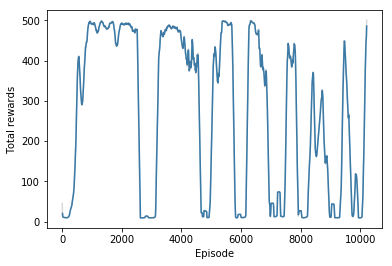

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

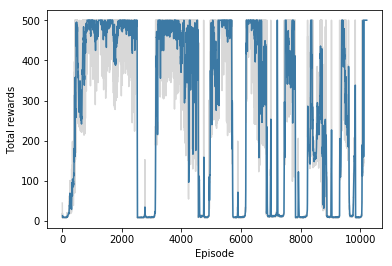

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

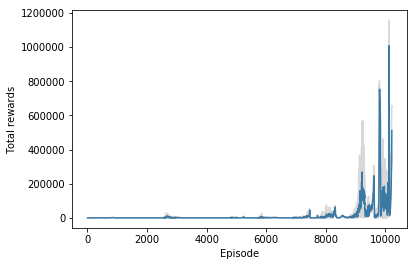

In [35]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
# Creating a gym env
import gym

# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action, _ = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.